In [1]:
import matplotlib.pyplot as plt
import numpy as np
from math import *
from uncertainties import *
from scipy.stats import chi2
from matplotlib import gridspec
import pandas
import sys
import statsmodels.api as sm
import warnings ## statsmodels.api is too old ... -_-#
# from tqdm import tqdm

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["font.family"] = "serif" 
plt.rcParams["mathtext.fontset"] = "dejavuserif" 
plt.close("all") # close all existing matplotlib plots
# plt.ion()        # interact with plots without pausing program


In [2]:
!python -V

Python 3.11.0


In [3]:
from joblib import Parallel, delayed

In [4]:
from tqdm.notebook import tqdm

In [5]:
# from numba import njit, prange, set_parallel_chunksize, get_parallel_chunksize,parallel_chunksize

In [6]:
import pyfftw

In [7]:
np.finfo(float).eps

2.220446049250313e-16

In [611]:
nx = 3000+1
nz = 2000+1
xmax = 80 #Micrometers
zmax = (nz/nx)*xmax
dt = 1e-5# Milliseconds
dx = 2*xmax/(nx-1)
dz = 2*zmax/(nz-1)
hb = 63.5078 #("AtomicMassUnit" ("Micrometers")^2)/("Milliseconds")
m3 = 3   # AtomicMassUnit
m4 = 4 

print(dx, dz, zmax)
print(1j*hb*dt/(2*m4*dx*dz)) #want this to be small

pxmax= (nx+1)/2 * 2*pi/(2*xmax)*hb # want this to be greater than p
pzmax= (nz+1)/2 * 2*pi/(2*zmax)*hb
print(pxmax,pzmax)
print(nx*nz/1000/1000,"million grid points")
print((nx*nz)*0.001*0.001/60/60,"hours (for 1μs per operation)")

0.05333333333333334 0.05334221926024658 53.34221926024658
0.02790405204624251j
3743.412156580006 3744.035331361133
6.005001 million grid points
0.0016680558333333334 hours (for 1μs per operation)


In [612]:
wavelength = 1.083 #Micrometers
k = (1/sqrt(2)) * 2*pi / wavelength
# k = 2*pi / wavelength
p = 2*hb*k
print("k =",k,"1/µm")
print("p =",p, "u*µm/ms")
print("v =",hb*k/m4, "µm/ms")

k = 4.102384984449092 1/µm
p = 521.0668902307921 u*µm/ms
v = 65.13336127884901 µm/ms


In [613]:
a4 = 0.007512
omega = 10 # I don't know, the nature paper used 50 for Rb
V0 = 2*hb*omega
tBraggCenter = 1
tBraggPi = np.sqrt(2*pi*hb)/V0
print(V0)
print(tBraggPi*1000,"µs")

def V(t):
    return V0 * (2*pi)**-0.5 * tBraggPi**-1 * np.exp(-0.5*(t-tBraggCenter)**2 * tBraggPi**-2)


1270.156
15.727018740679478 µs


In [614]:
print(1j*(dt/hb), "term infront of Bragg potential")
print(1j*(dt/hb)*V(tBraggCenter), "max size of this thing")

1.5746097329776815e-07j term infront of Bragg potential
0.005073336364374378j max size of this thing


In [615]:
xlin = np.linspace(-xmax,+xmax, nx)
zlin = np.linspace(-zmax,+zmax, nz)
psi=np.zeros((nx,nz),dtype=complex)
print(psi.nbytes/1000/1000, "MB of data used")


zones = np.ones(nz)
xgrid = np.tensordot(xlin,zones,axes=0)
cosGrid = np.cos(2*k*xgrid)

96.080016 MB of data used


In [616]:
# sanity check
assert (pxmax > p*2.5 or pzmax > p*2.5), "momentum resolution too small"

##### Checking parameters reasonable

In [617]:
V0

1270.156

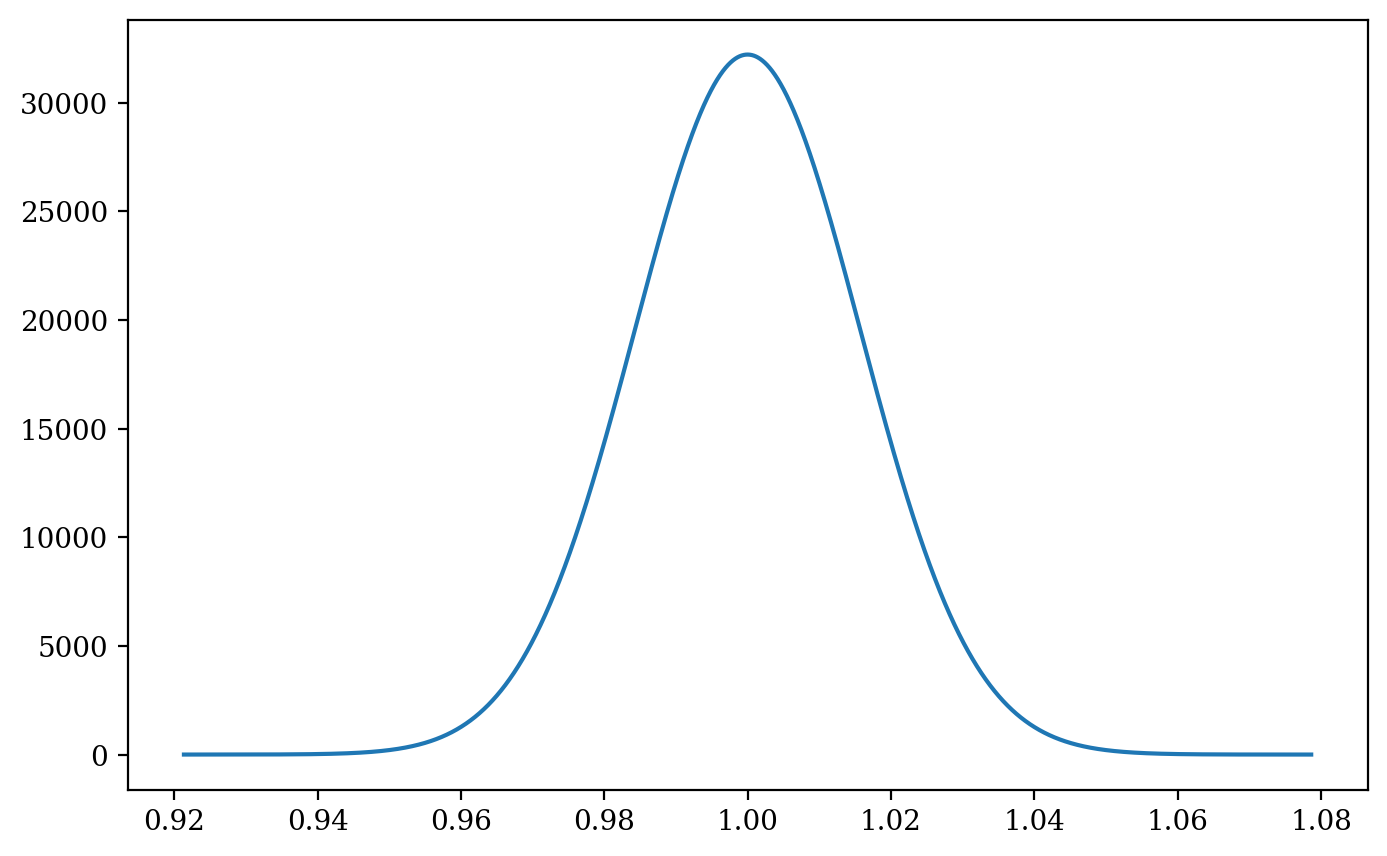

In [618]:
tbtest = np.arange(tBraggCenter-5*tBraggPi,tBraggCenter+5*tBraggPi,dt)
plt.plot(tbtest, V(tbtest))

In [619]:
np.trapz(V(tbtest),tbtest)

1270.1552717924328

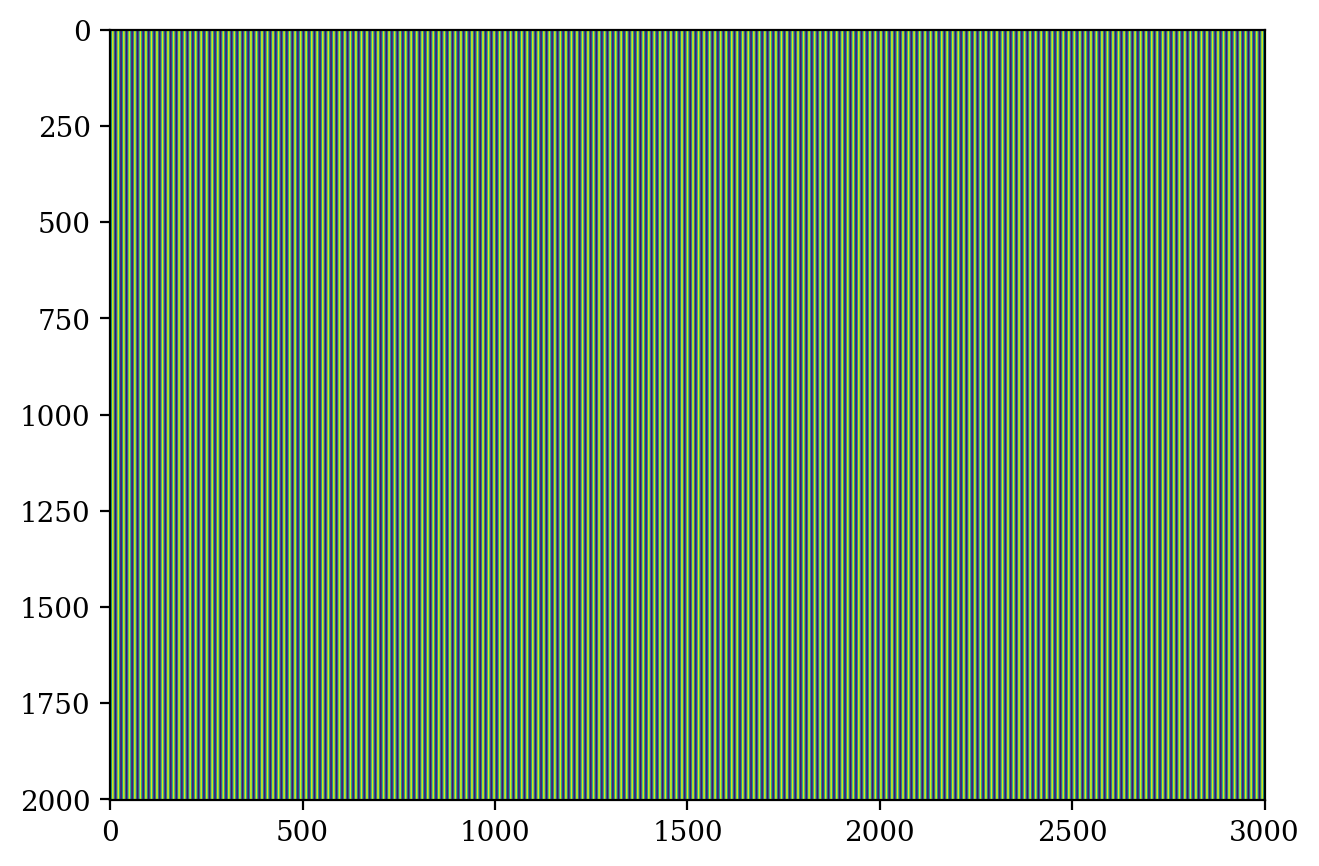

In [620]:
# vtest = np.cos(2*k*xlin)
plt.imshow(cosGrid.T)
plt.show()

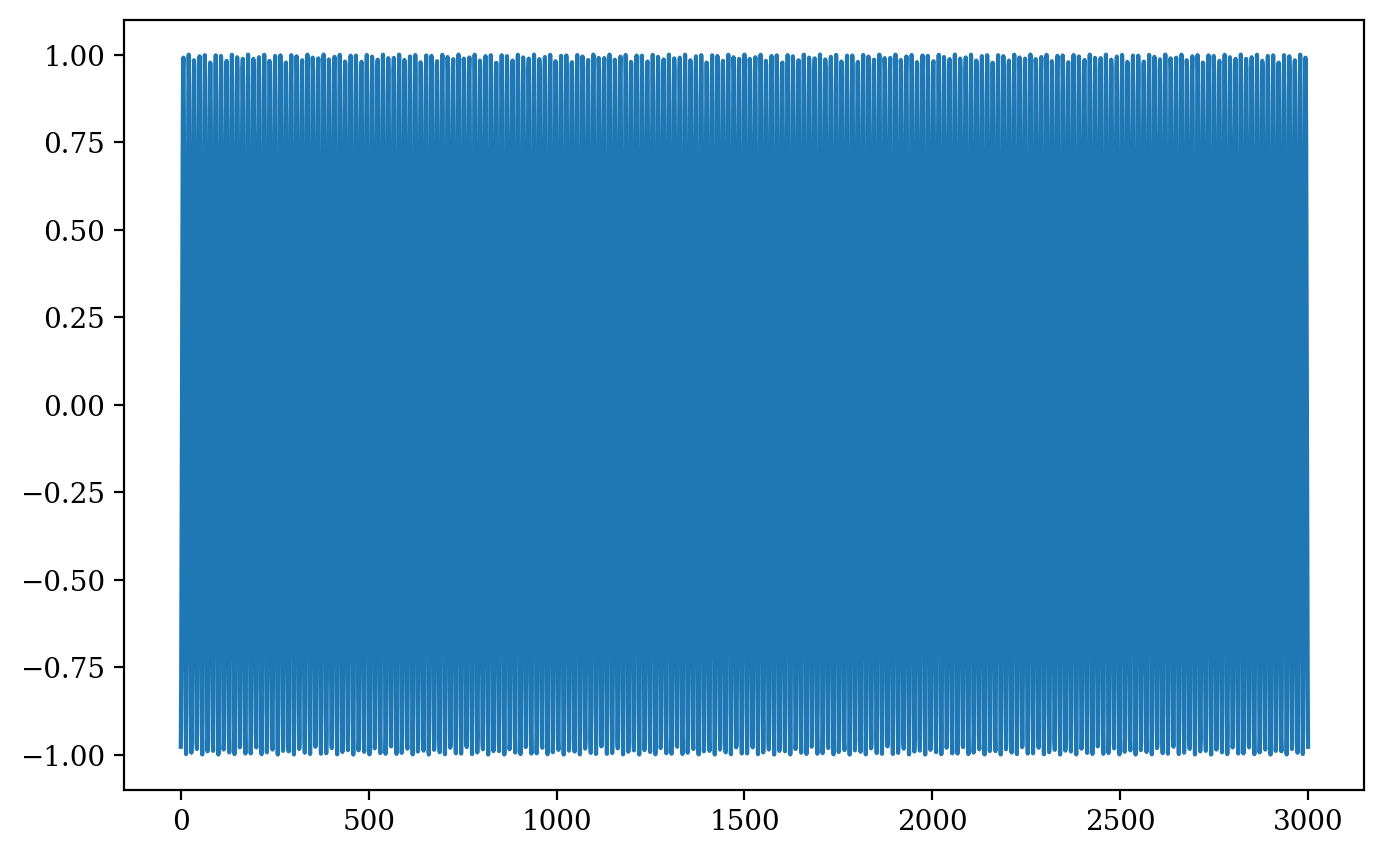

In [621]:
plt.plot(cosGrid[:,0])

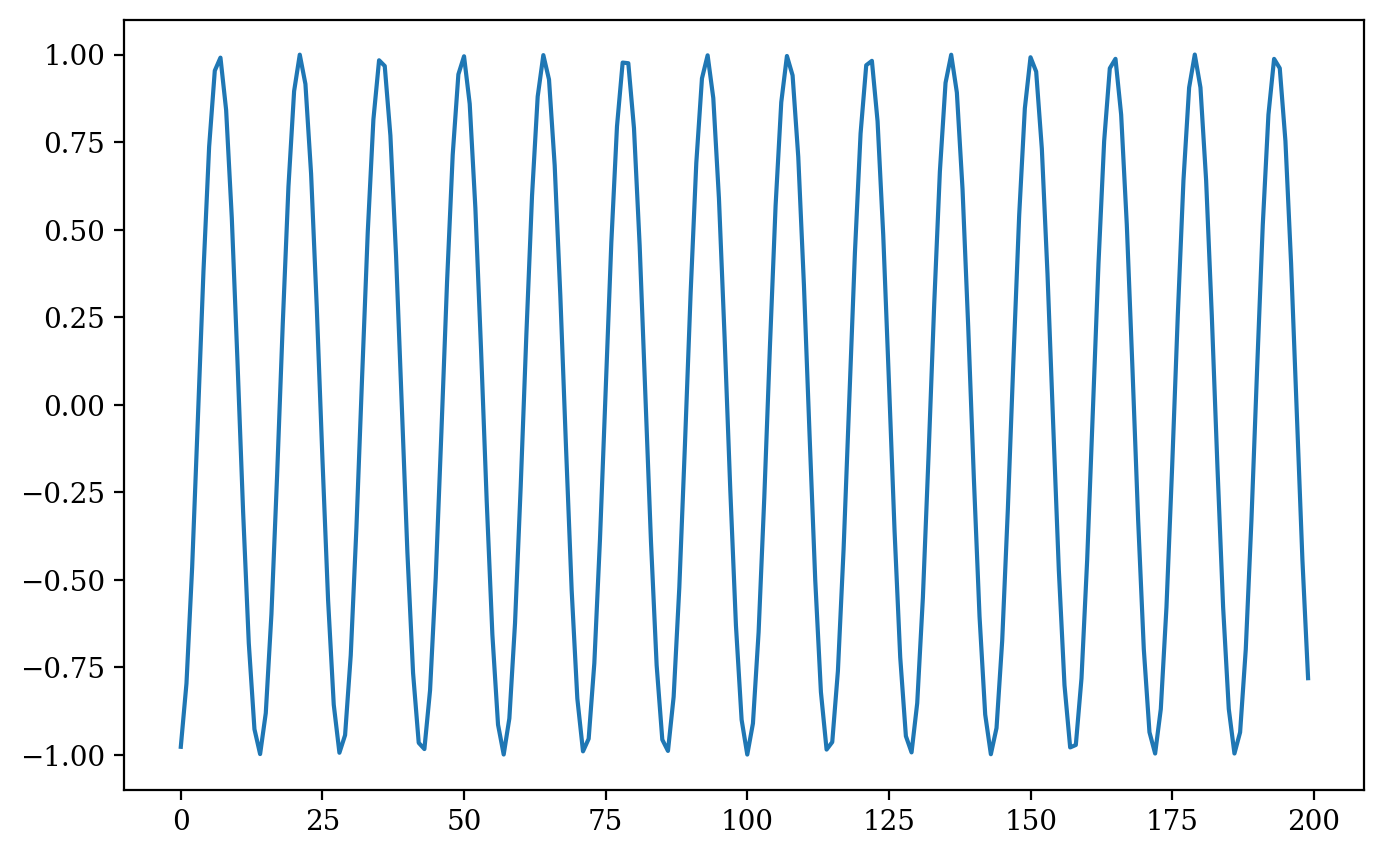

In [622]:
plt.plot(cosGrid[:200,0])

#### Initial State

In [623]:
def plot_psi(psi):
    plt.figure(figsize=(12,6))
    extent = np.array([-xmax,+xmax,-zmax,+zmax])
    plt.subplot(1,3,1)
    plt.imshow(np.abs(psi.T)**2,extent=extent)
    plt.ylabel("$z$ (µm)")
    plt.subplot(1,3,2)
    plt.imshow(np.real(psi.T),extent=extent)
    plt.subplot(1,3,3)
    plt.imshow(np.imag(psi.T),extent=extent)
    plt.show()

In [624]:
def plot_mom(psi):
    plt.figure(figsize=(11,5))
    pspace = np.fft.fftfreq(nx)
    extent = np.array([-pxmax,+pxmax,-pzmax,+pzmax])
    psifft = np.fft.fftshift(np.fft.fft2(psi))
    psiAbsSq = np.abs(psifft)**2
    plotdata = np.flipud(psiAbsSq.T)
    
    plt.subplot(1,3,1)
    plt.imshow(plotdata,extent=extent) 
    plt.ylabel("$p_z$ (u*µm/ms)")
    
    plt.subplot(1,3,2)
    nxm = int((nx-1)/2)
    nzm = int((nz-1)/2)
    nx2 = int((nx-1)/10)
    nz2 = int((nz-1)/10)
    plotdata = np.flipud(psiAbsSq[nxm-nx2:nxm+nx2,nzm-nz2:nzm+nz2].T)
    plt.imshow(plotdata,extent=extent*0.1) 
    
    plt.subplot(1,3,3)
    nx3 = int((nx-1)/100)
    nz3 = int((nz-1)/100)
    plotdata = np.flipud(psiAbsSq[nxm-nx3:nxm+nx3,nzm-nz3:nzm+nz3].T)
    plt.imshow(plotdata,extent=extent*0.01) 
#     print(nx2,nz2,nx3,nz3)
    
    plt.show()

In [625]:
sg=0.2

def psi0(x,z,sx=sg,sz=sg,px=0,pz=0):
    return (1/np.sqrt(pi*sx*sz)) \
            * np.exp(-0.5*x**2/sx**2) \
            * np.exp(-0.5*z**2/sz**2) \
            * np.exp(+(1j/hb)*(px*x + pz*z))

0.9999999999999521 normalisation check


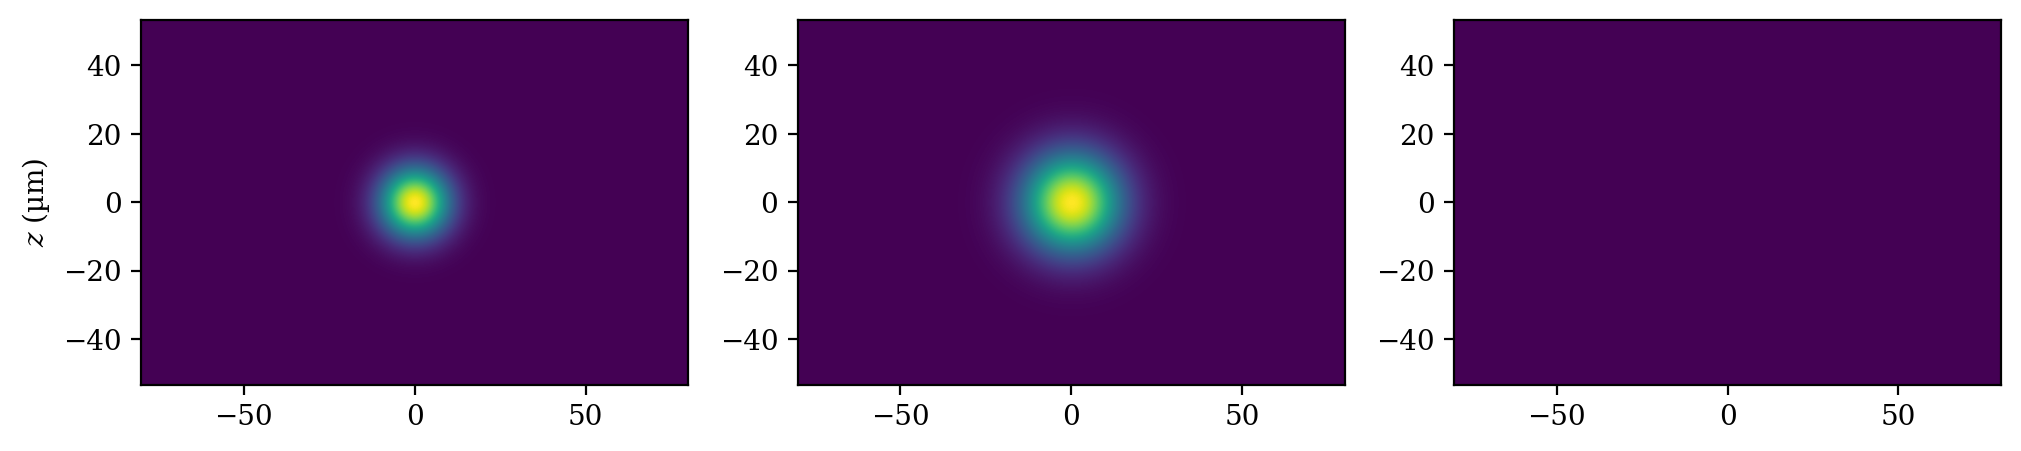

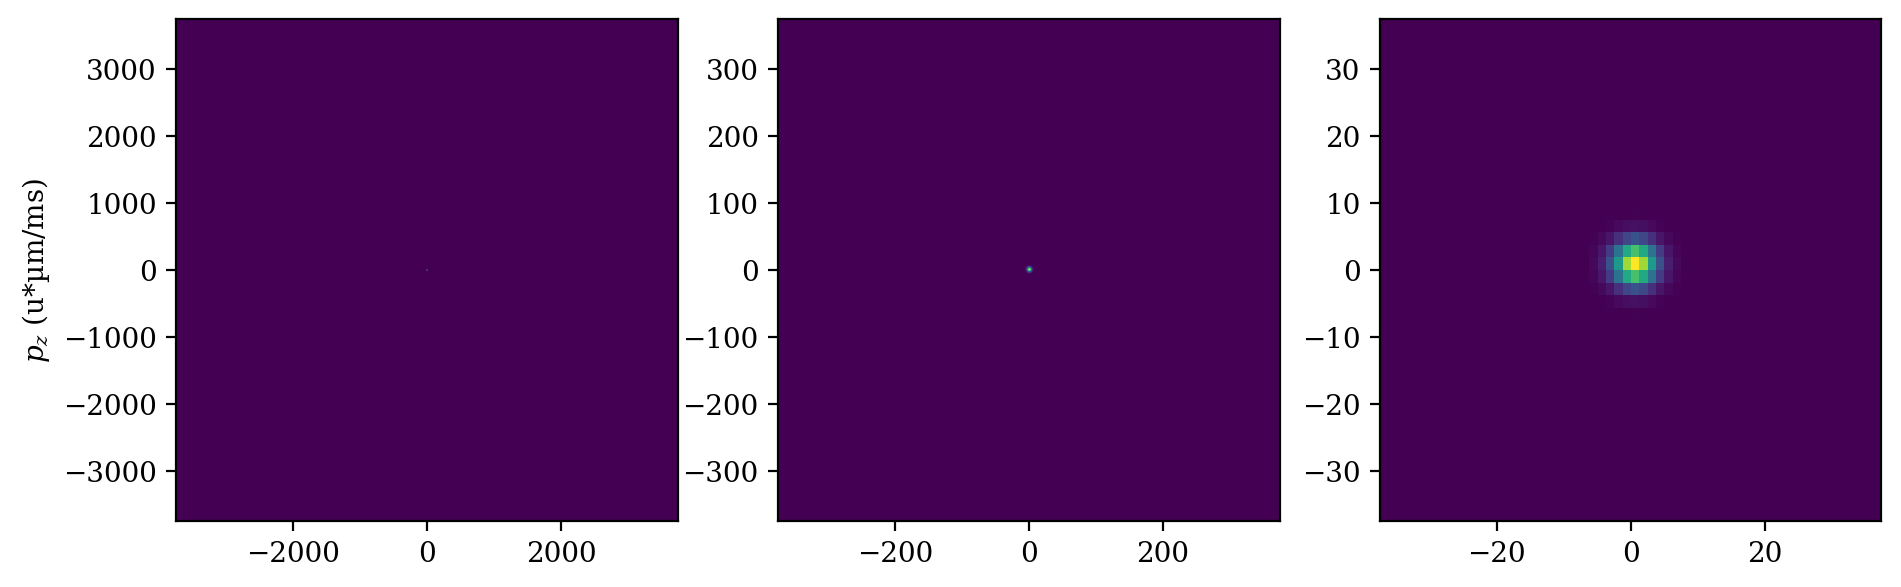

In [627]:
def psi0np(mux=10,muz=10,p0x=0,p0z=0):
    psi=np.zeros((nx,nz),dtype=complex)
    for ix in range(1,nx-1):
        x = xlin[ix]
        psi[ix][1:-1] = psi0(x,zlin[1:-1],mux,muz,p0x,p0z)
    return psi
psi = psi0np(10,10,0,0)
t = 0

print(np.trapz(np.trapz(np.abs(psi)**2,xlin,axis=0),zlin), "normalisation check")
plot_psi(psi)
plot_mom(psi)

In [628]:
V00 = 100000
# dt=0.01
VxExpGrid = np.exp(-(1j/hb) * 0.5*dt * V00 * cosGrid )
pxlin = np.linspace(-pxmax,+pxmax,nx)
pzlin = np.linspace(-pzmax,+pzmax,nz)

expPGrid = np.zeros((nx,nz),dtype=complex)
for indx in range(nx):
    expPGrid[indx, :] = np.exp(-(1j/hb) * (0.5/m4) * (dt) * (pxlin[indx]**2 + pzlin**2)) 
        

In [629]:
-(1j/hb) * 0.5*dt * V00

-0.007873048664888407j

In [630]:
sqrt(2*pi*hb)/(V00*2)

9.987883607793241e-05

In [631]:
2*pi*hb/(V00)

0.003990312758512997

In [632]:
2*pi*hb/(V00*2)

0.0019951563792564987

In [633]:
2*pi*hb/(V00*0.5)

0.007980625517025995

In [634]:
nthreads=3

  0%|          | 0/500 [00:00<?, ?it/s]

time = 0 µs
0.9999999999999519 |psi|^2


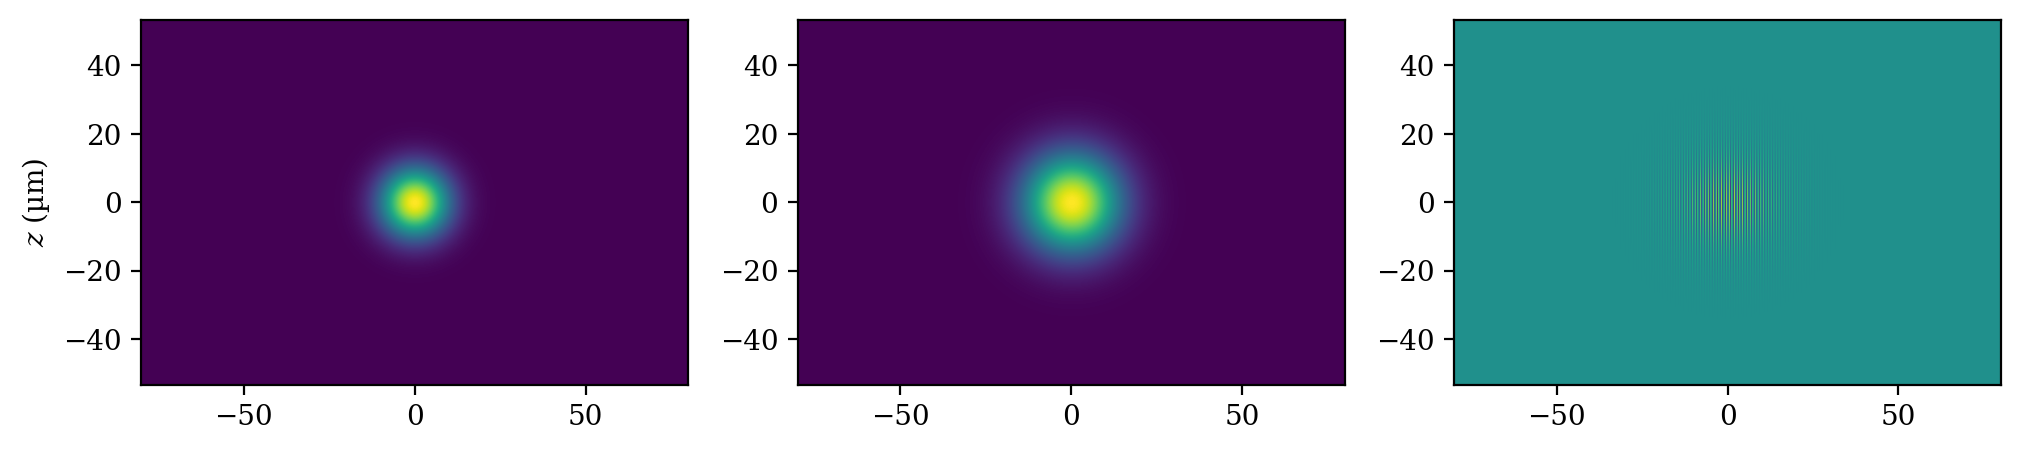

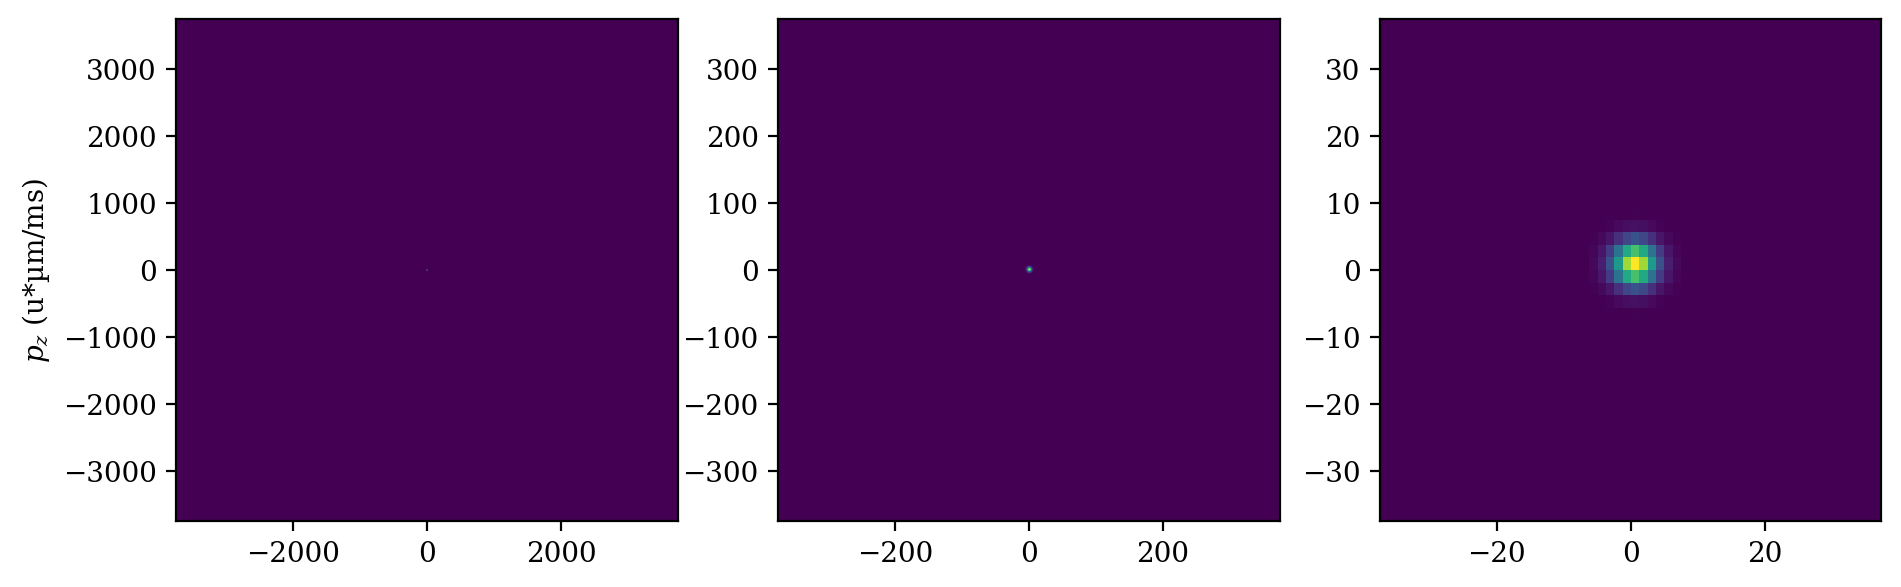

time = 0.05 µs
0.999999999999952 |psi|^2


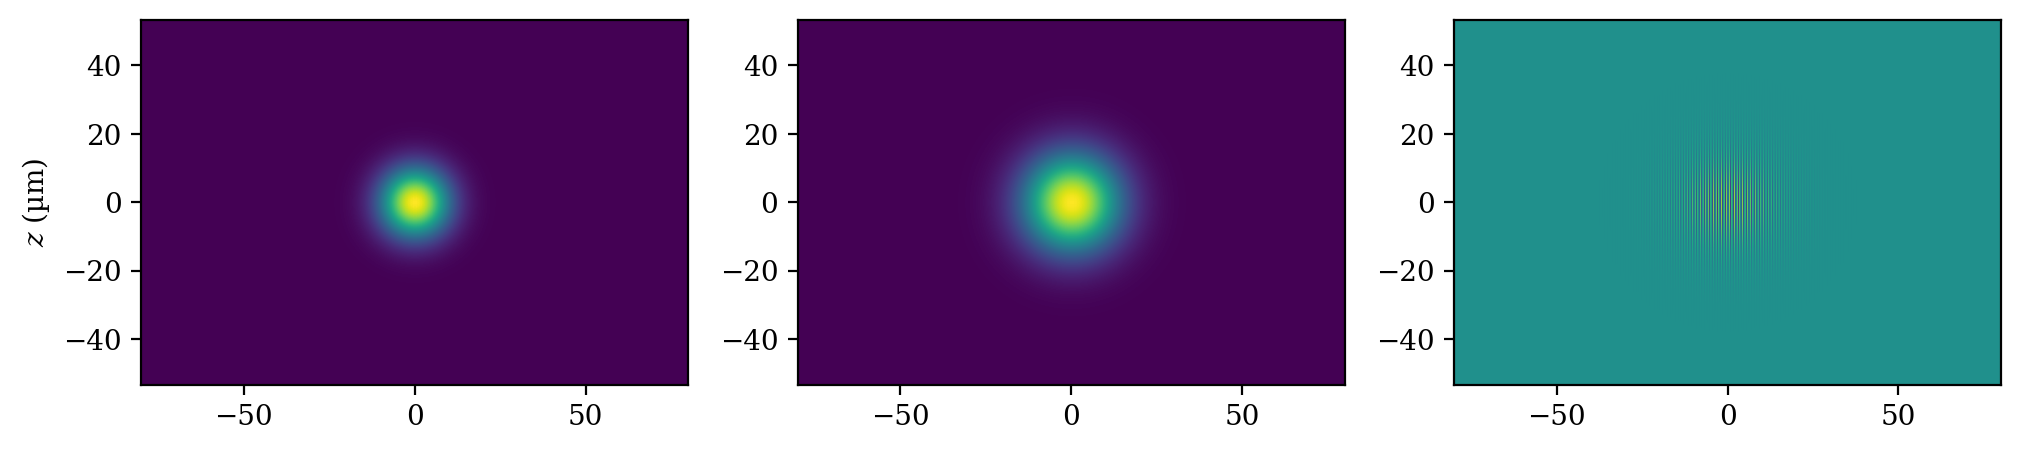

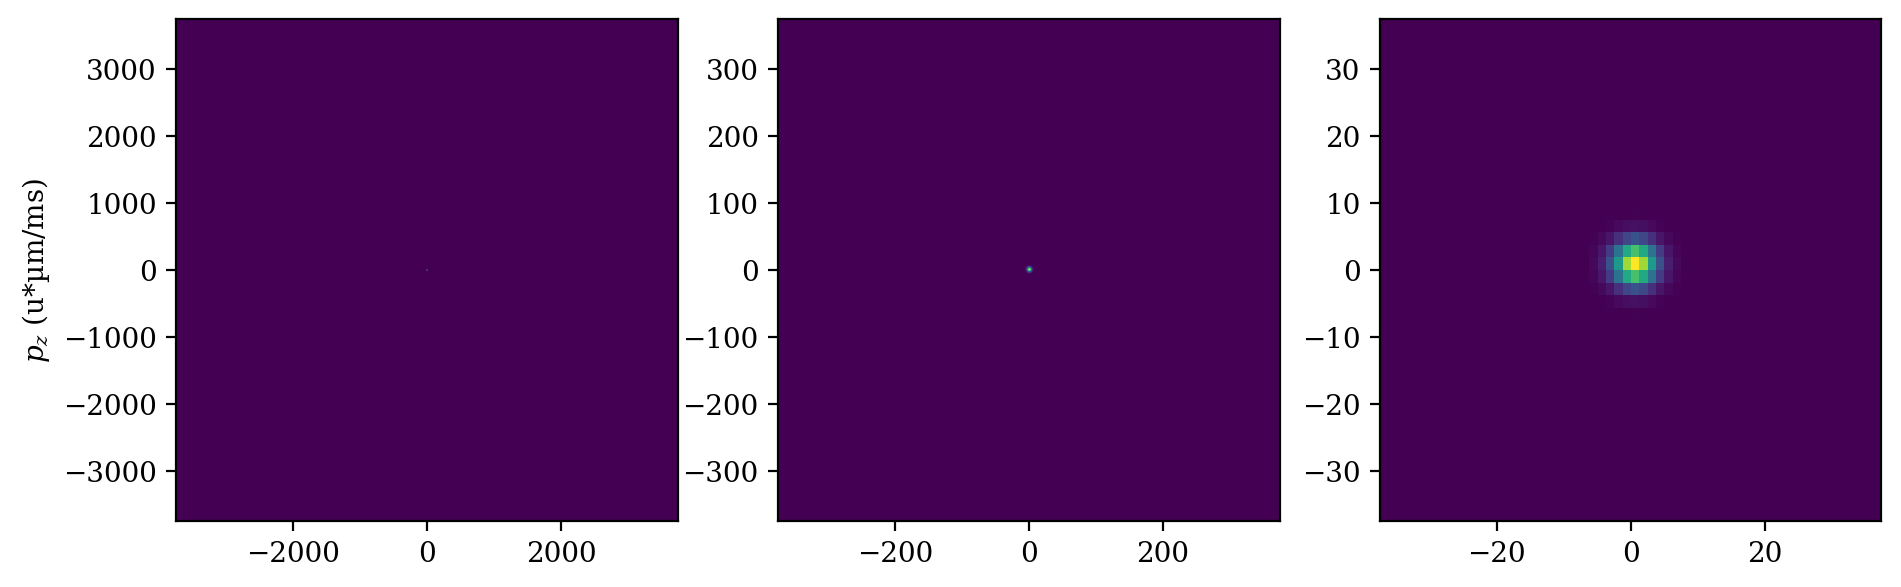

time = 0.1 µs
0.999999999999952 |psi|^2


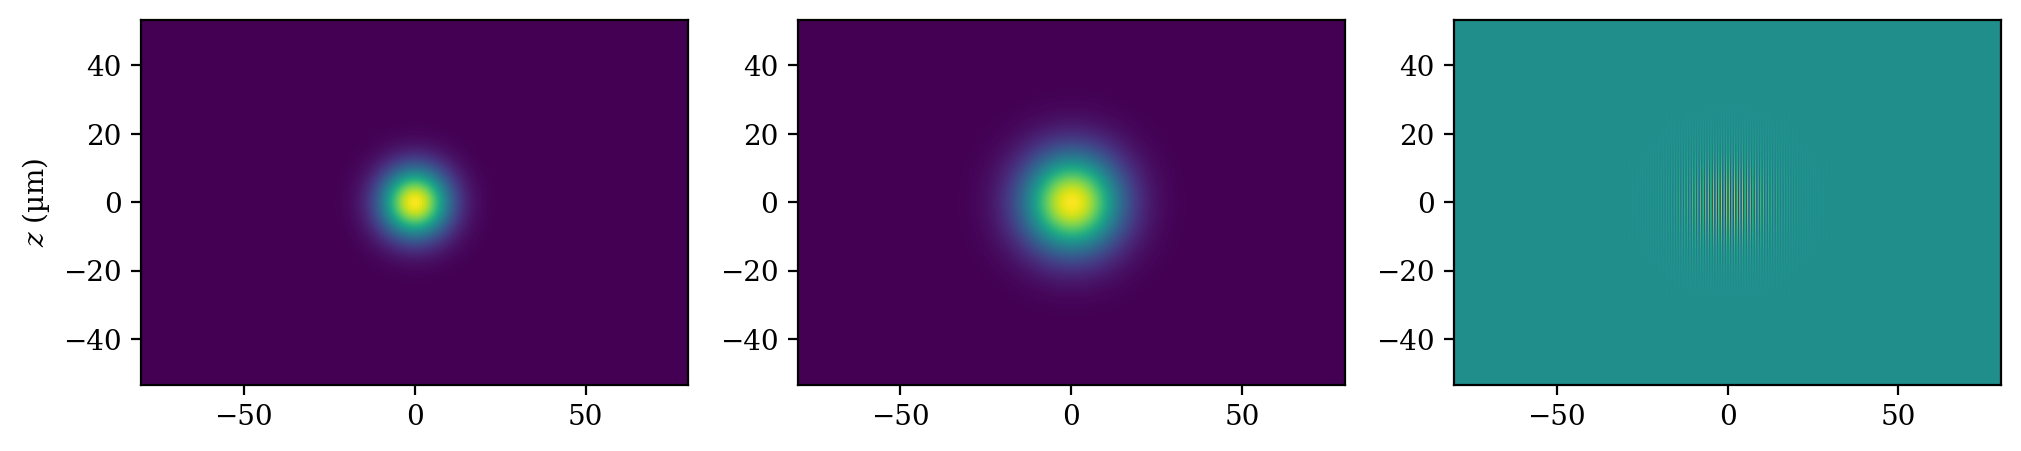

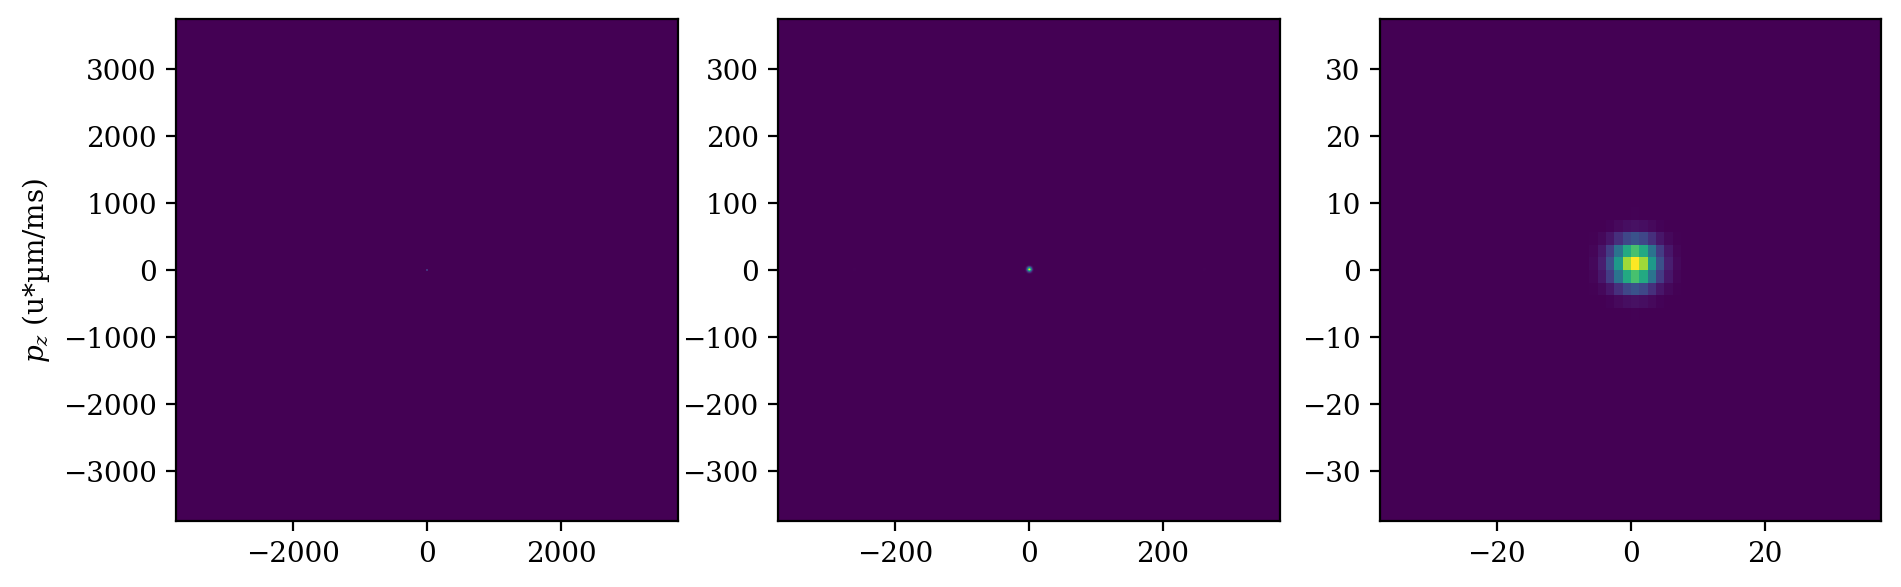

time = 0.15 µs
0.9999999999999519 |psi|^2


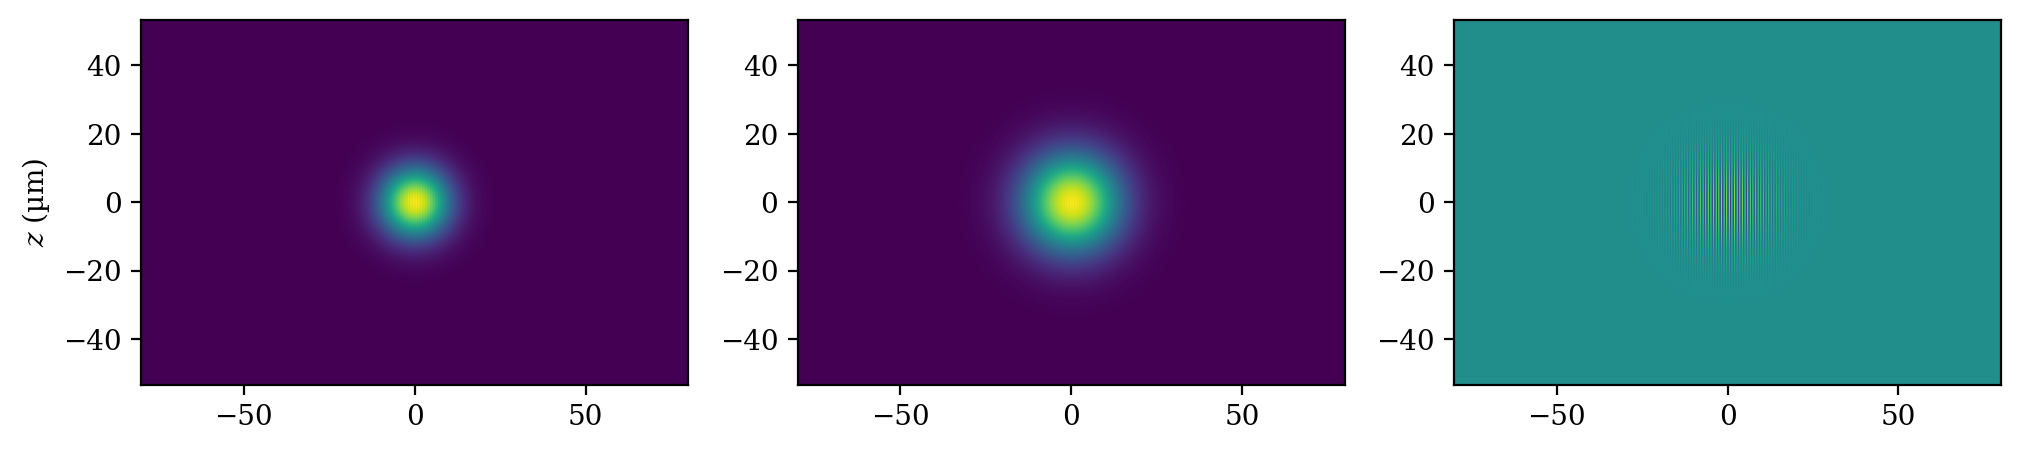

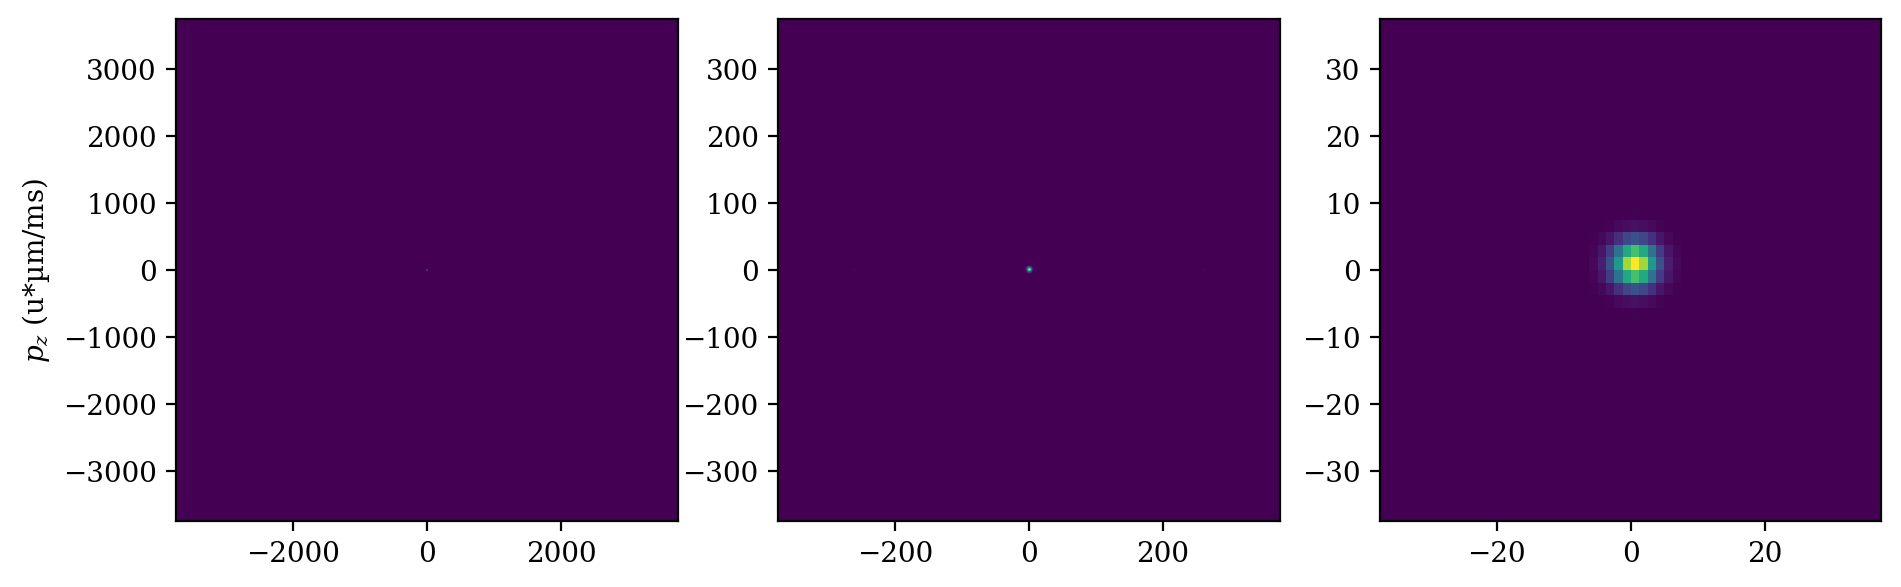

time = 0.2 µs
0.9999999999999516 |psi|^2


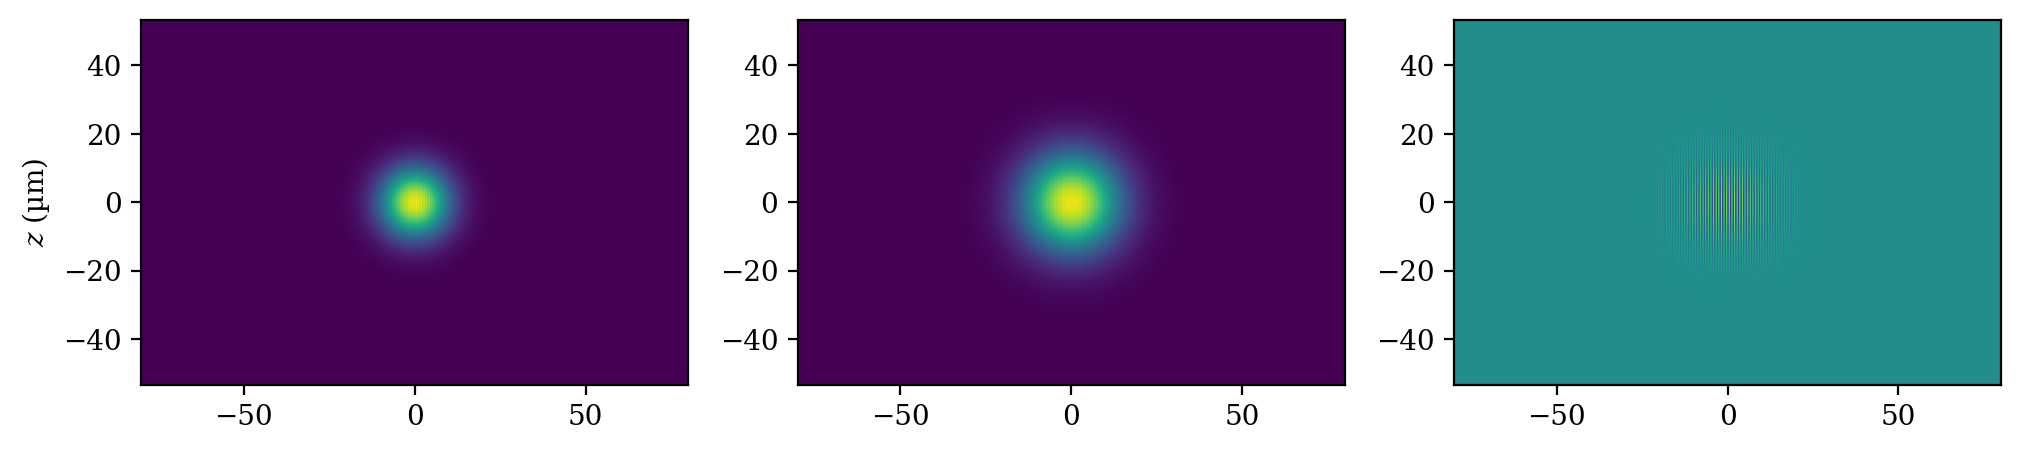

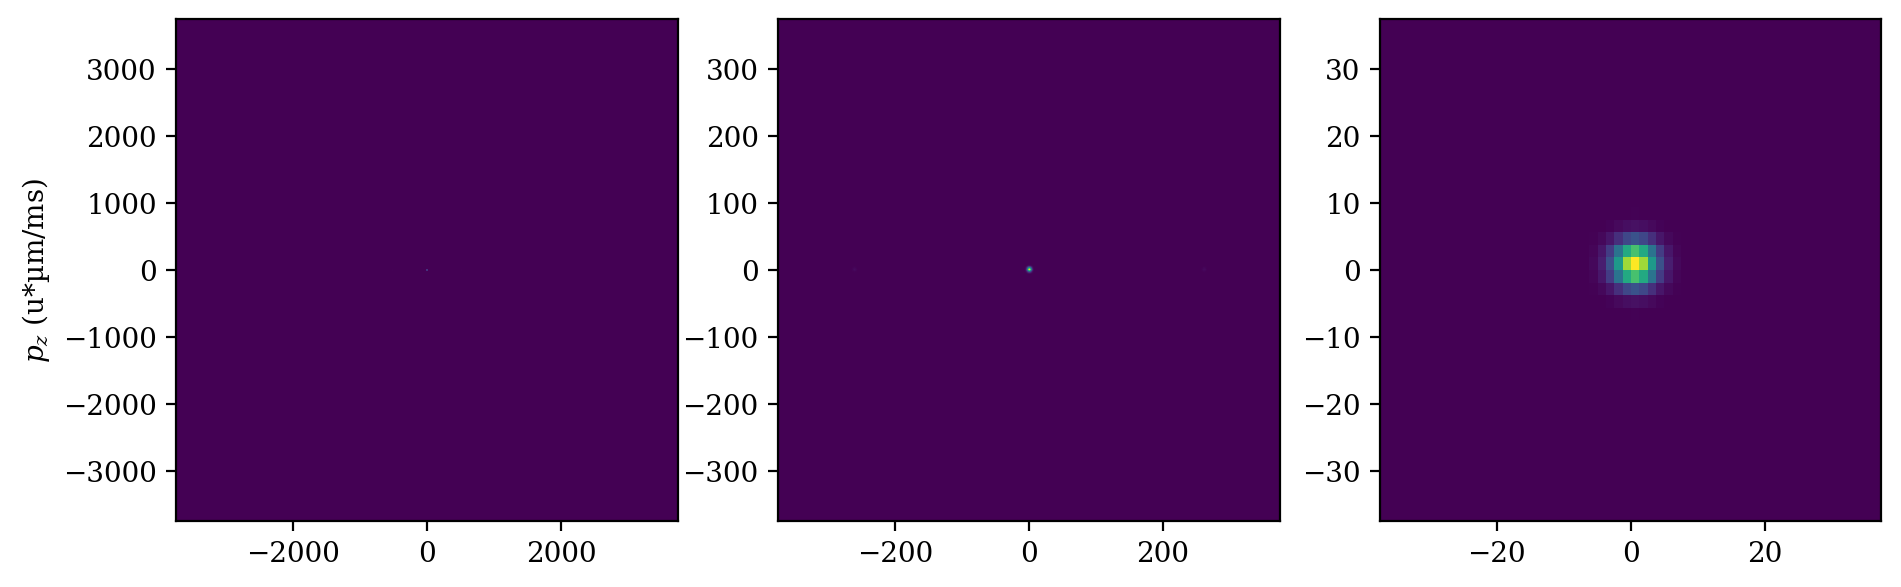

time = 0.25 µs
0.9999999999999514 |psi|^2


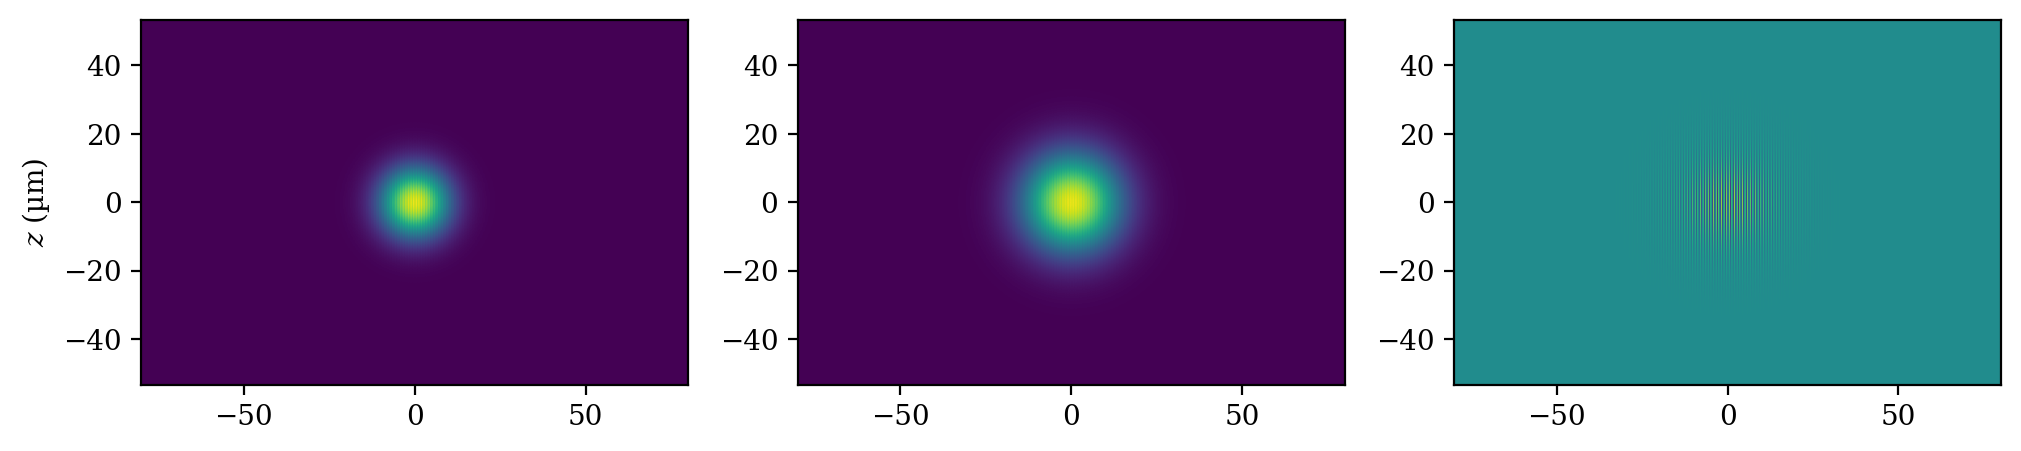

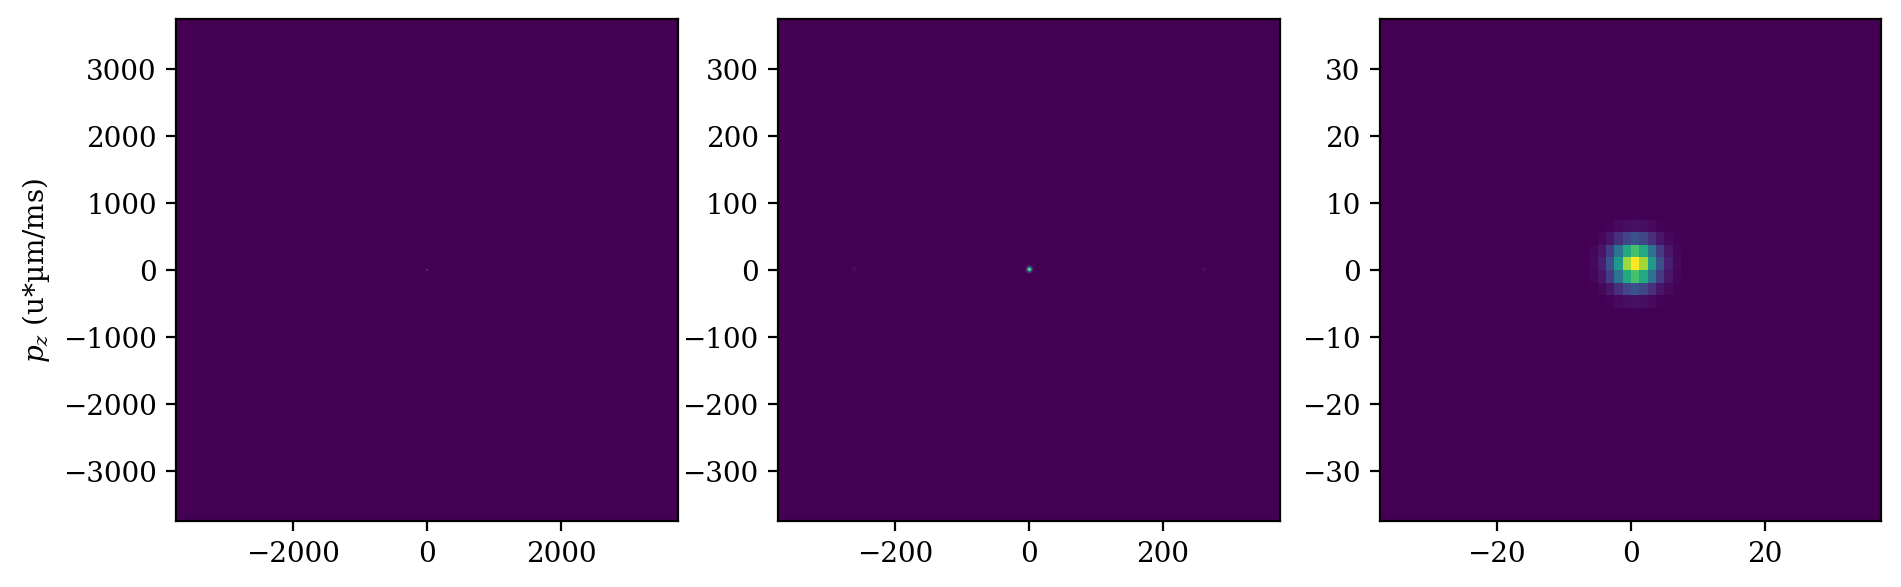

time = 0.3 µs
0.9999999999999514 |psi|^2


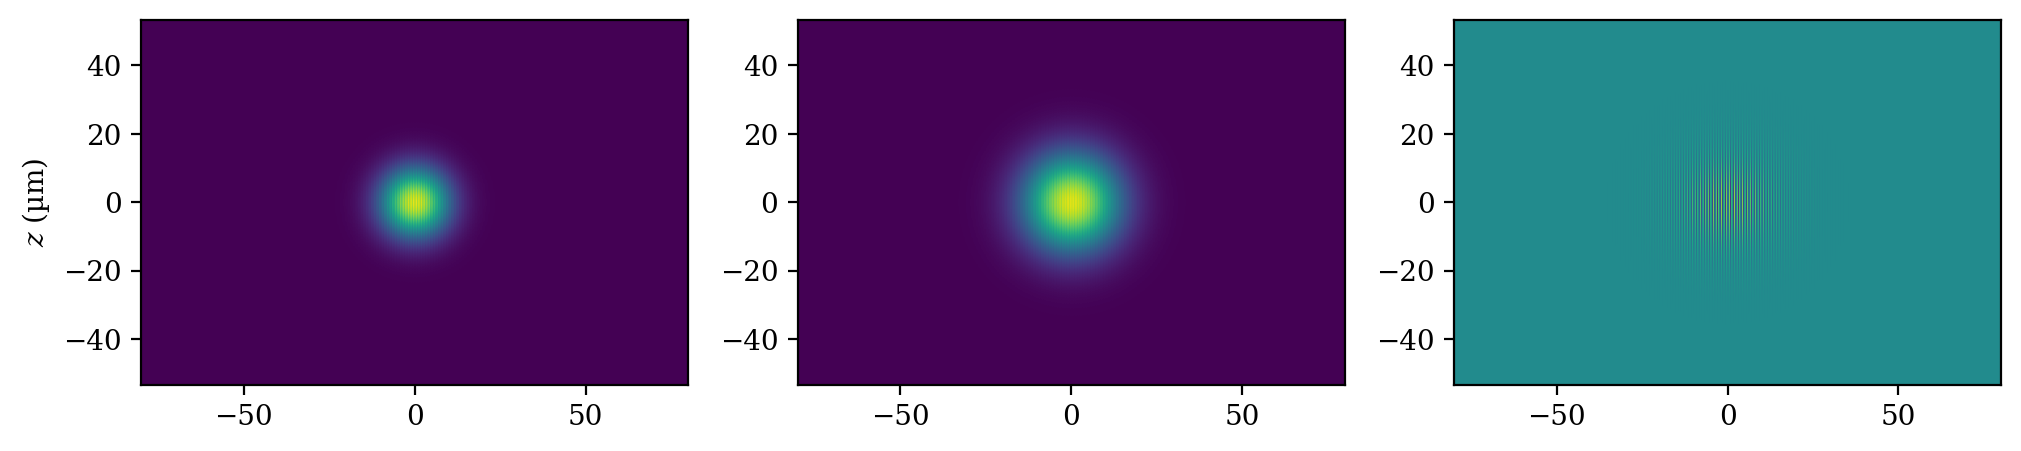

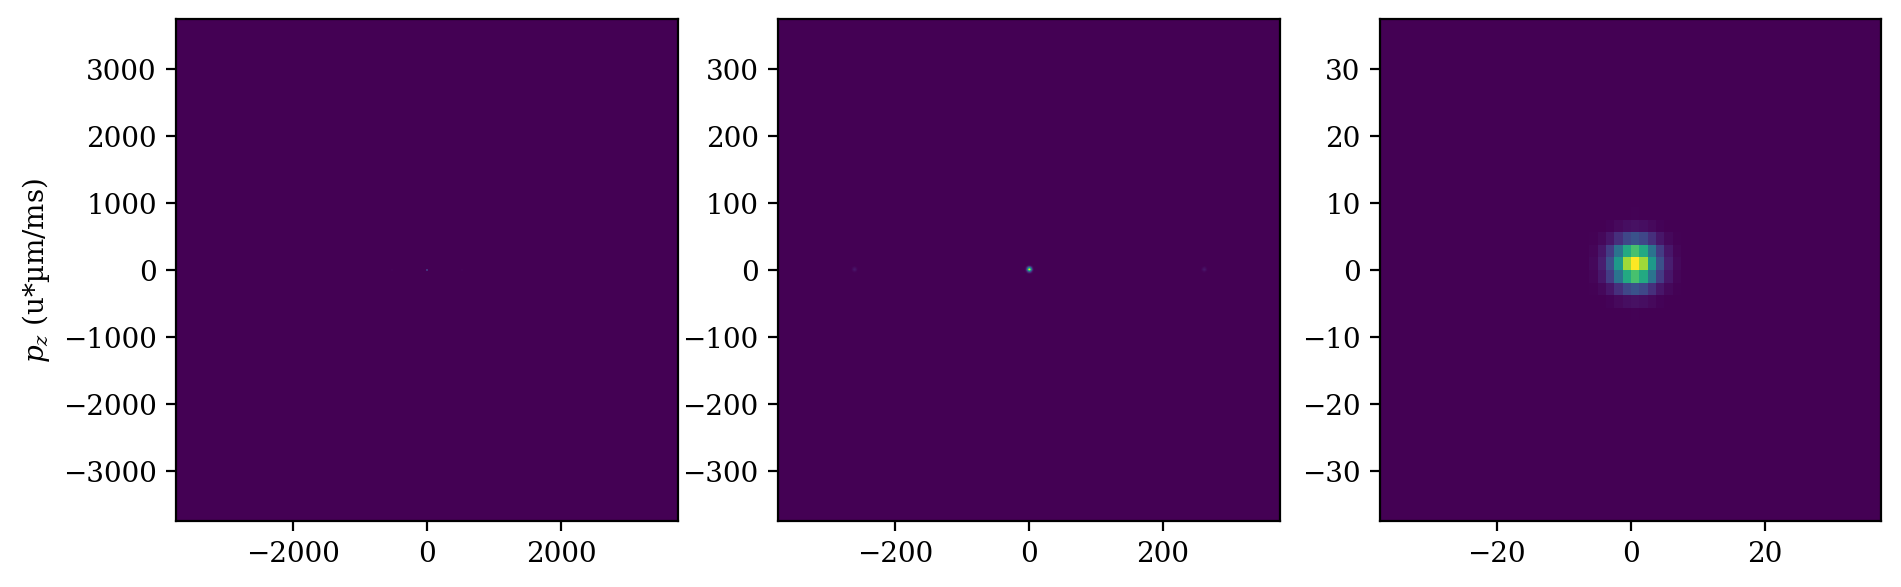

time = 0.35 µs
0.9999999999999509 |psi|^2


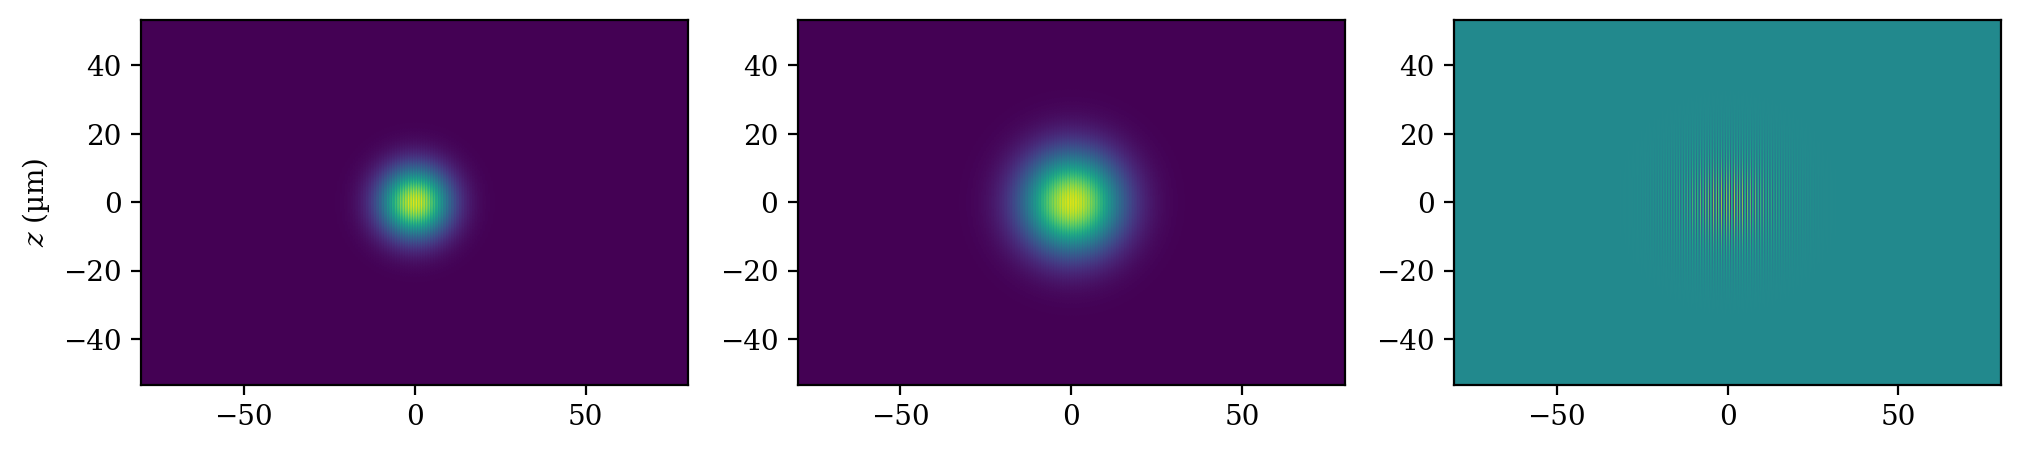

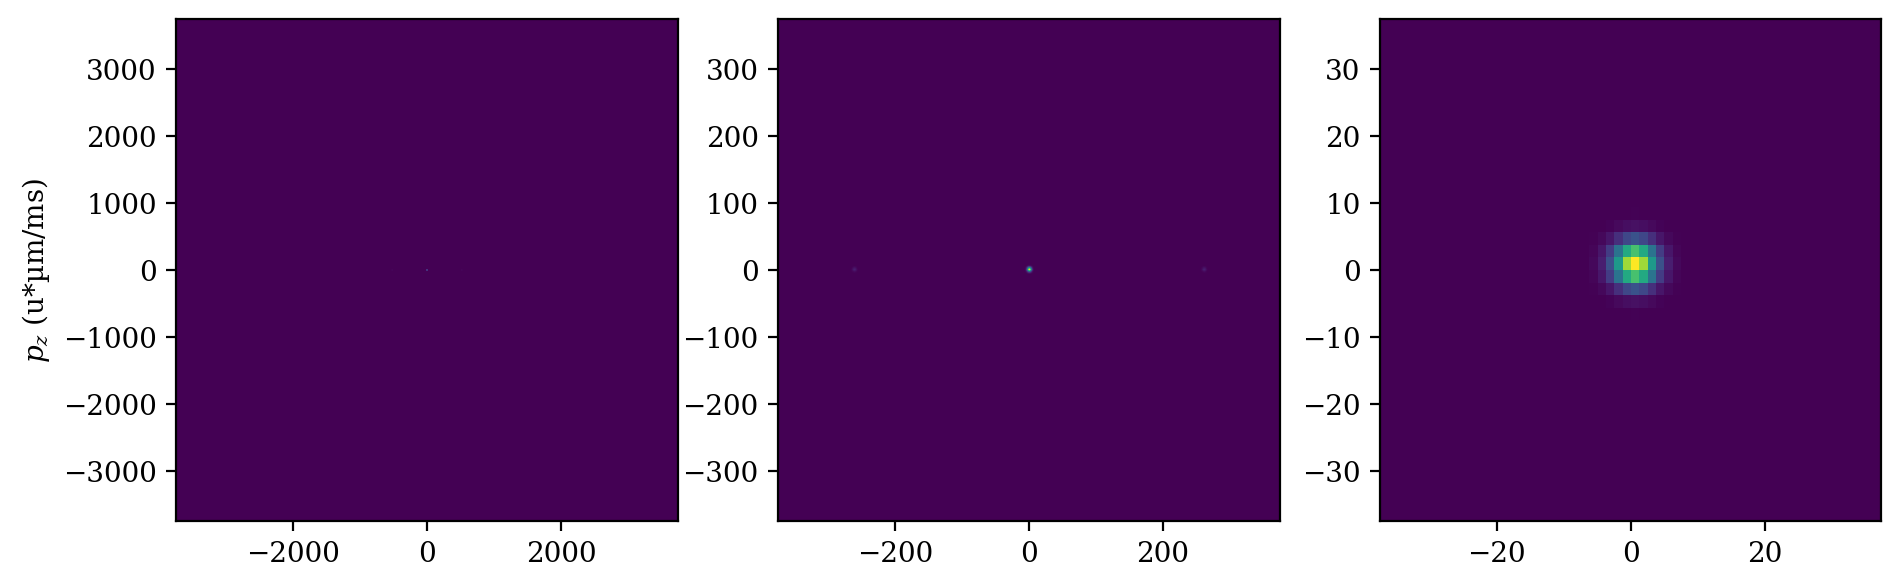

time = 0.4 µs
0.9999999999999509 |psi|^2


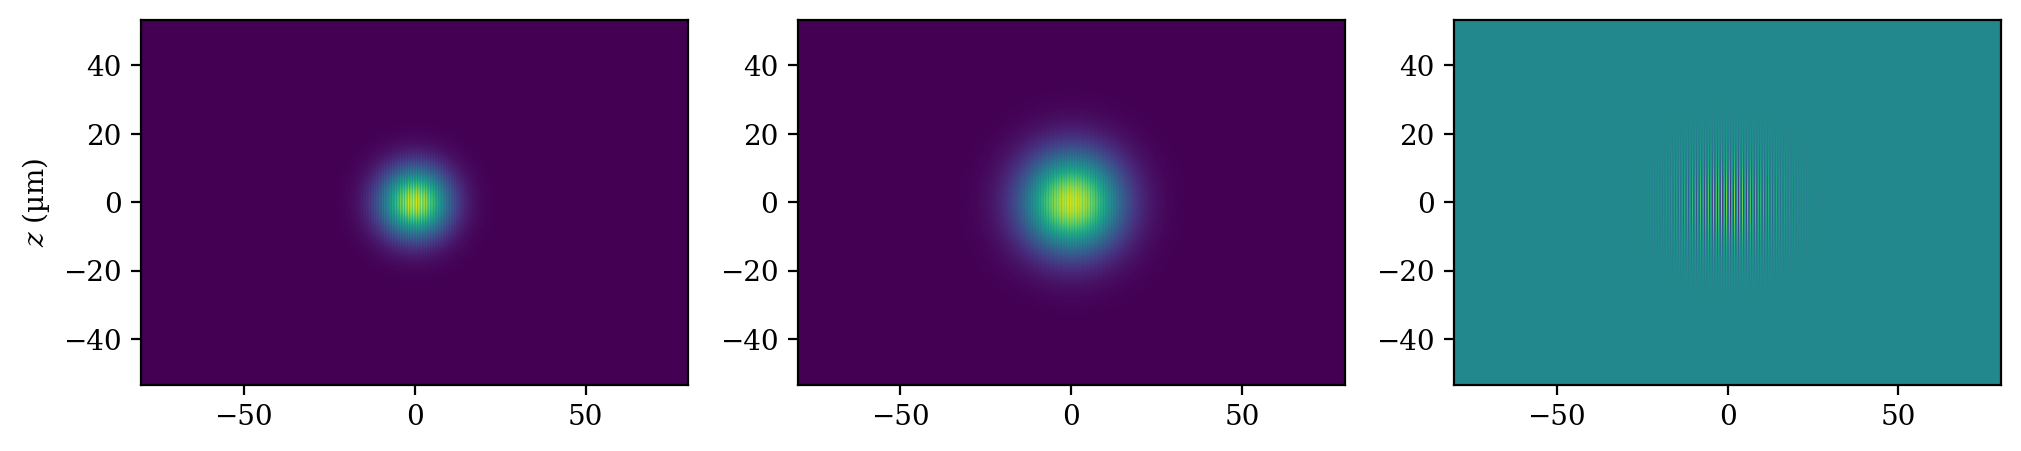

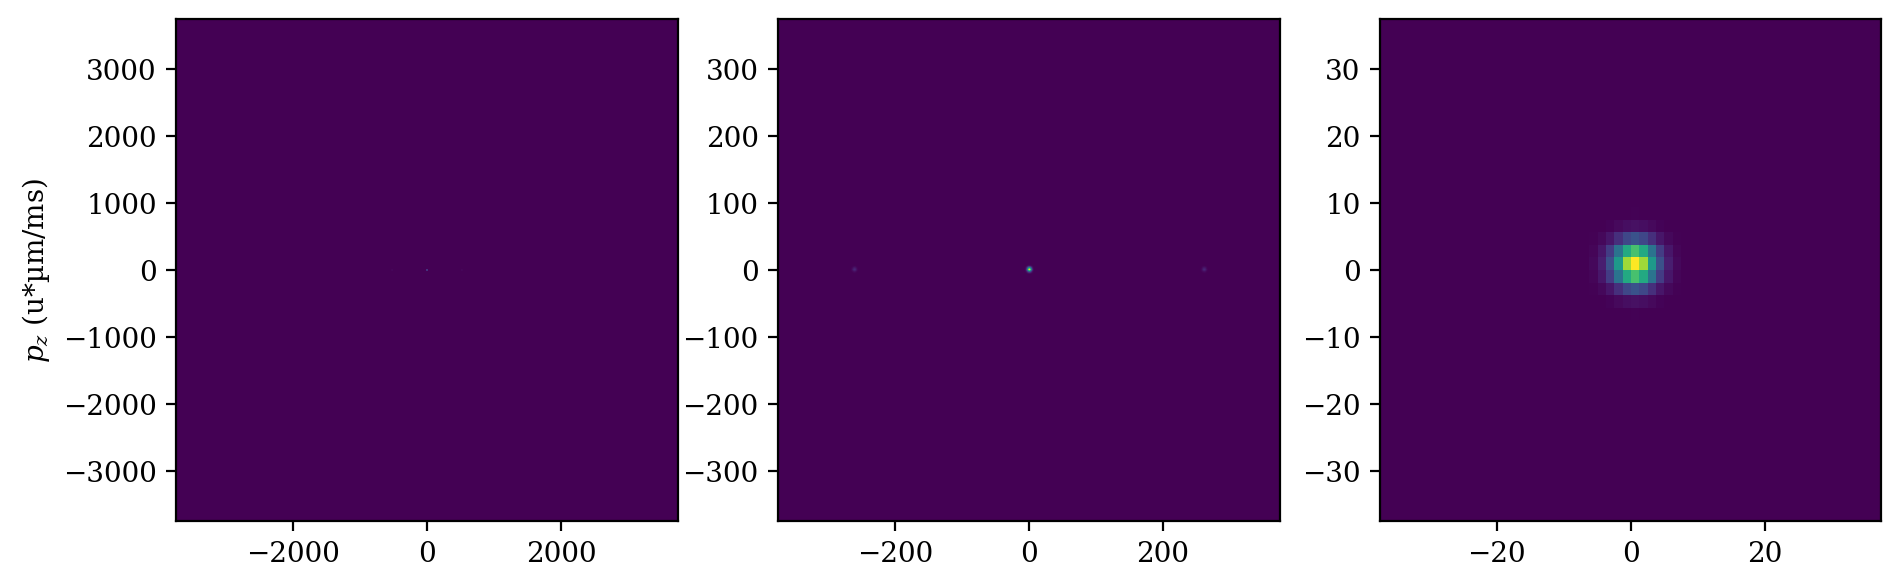

time = 0.45 µs
0.9999999999999512 |psi|^2


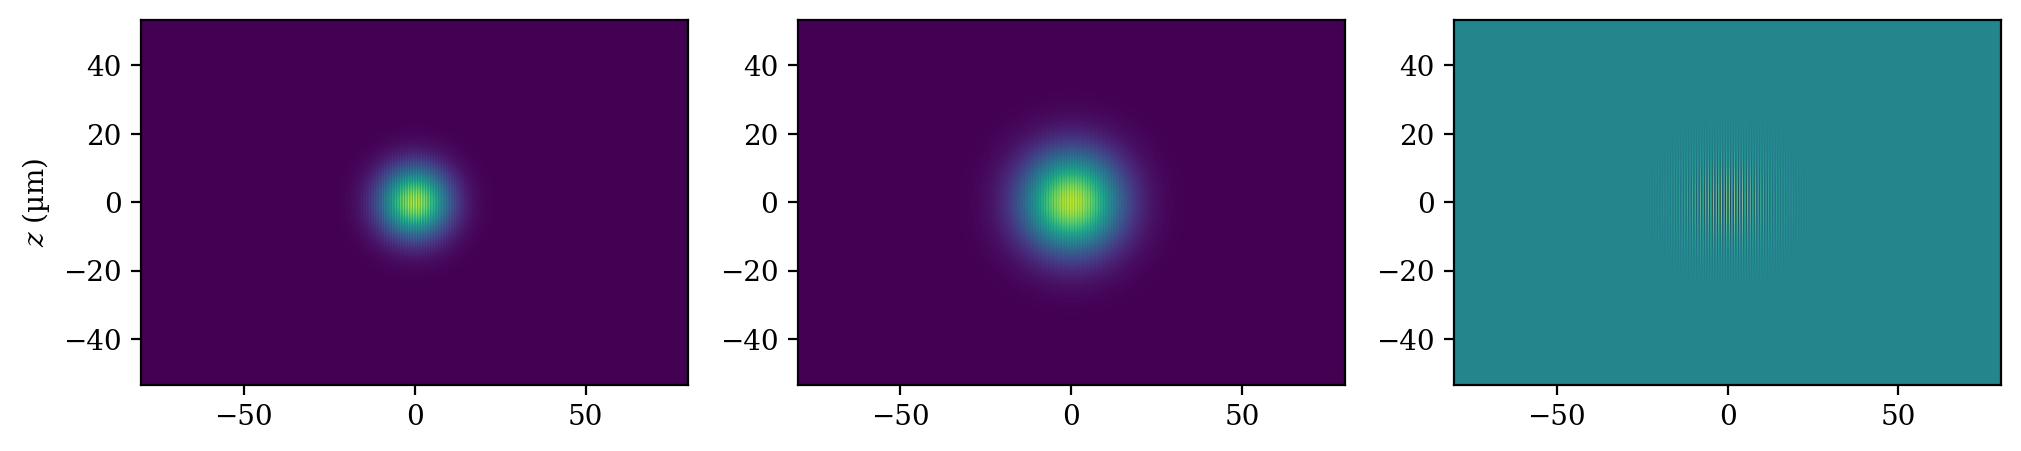

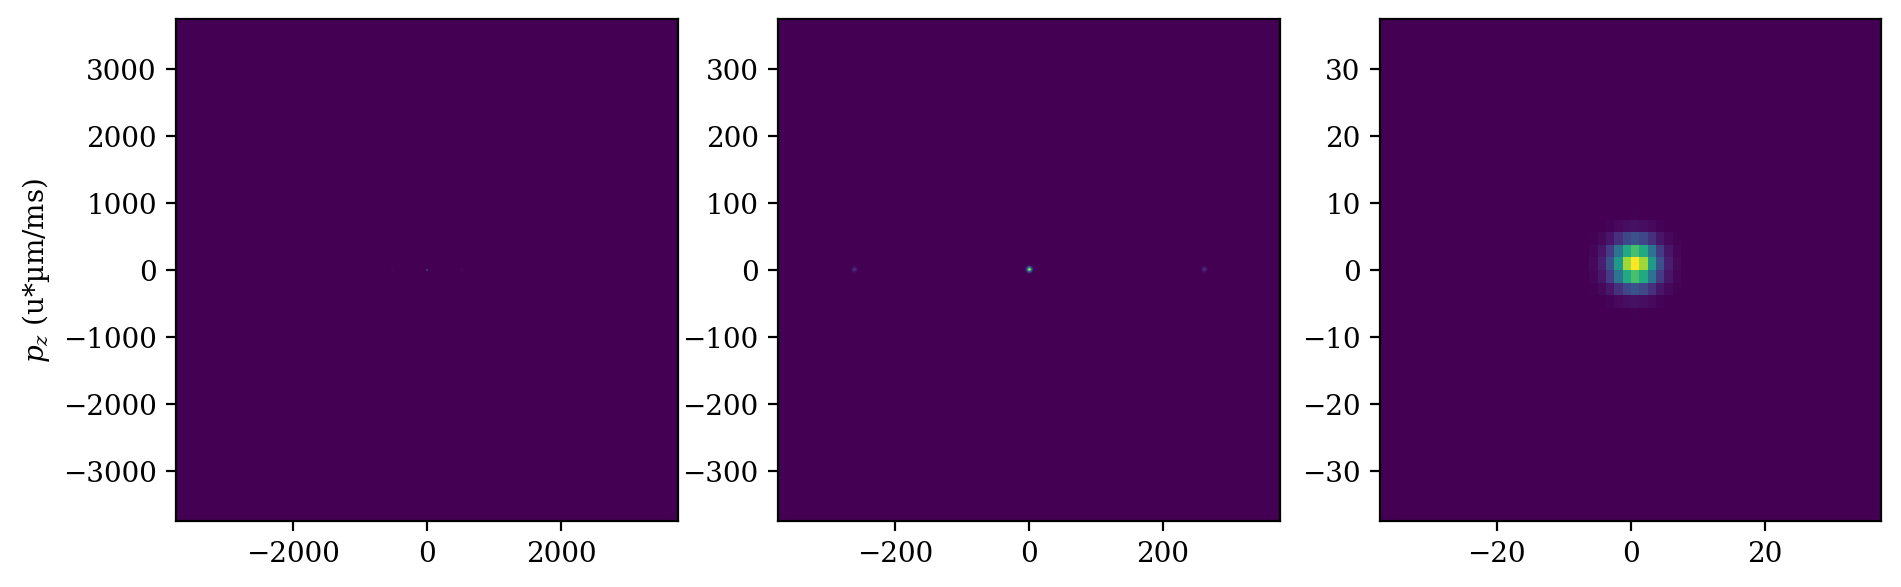

time = 0.5 µs
0.9999999999999509 |psi|^2


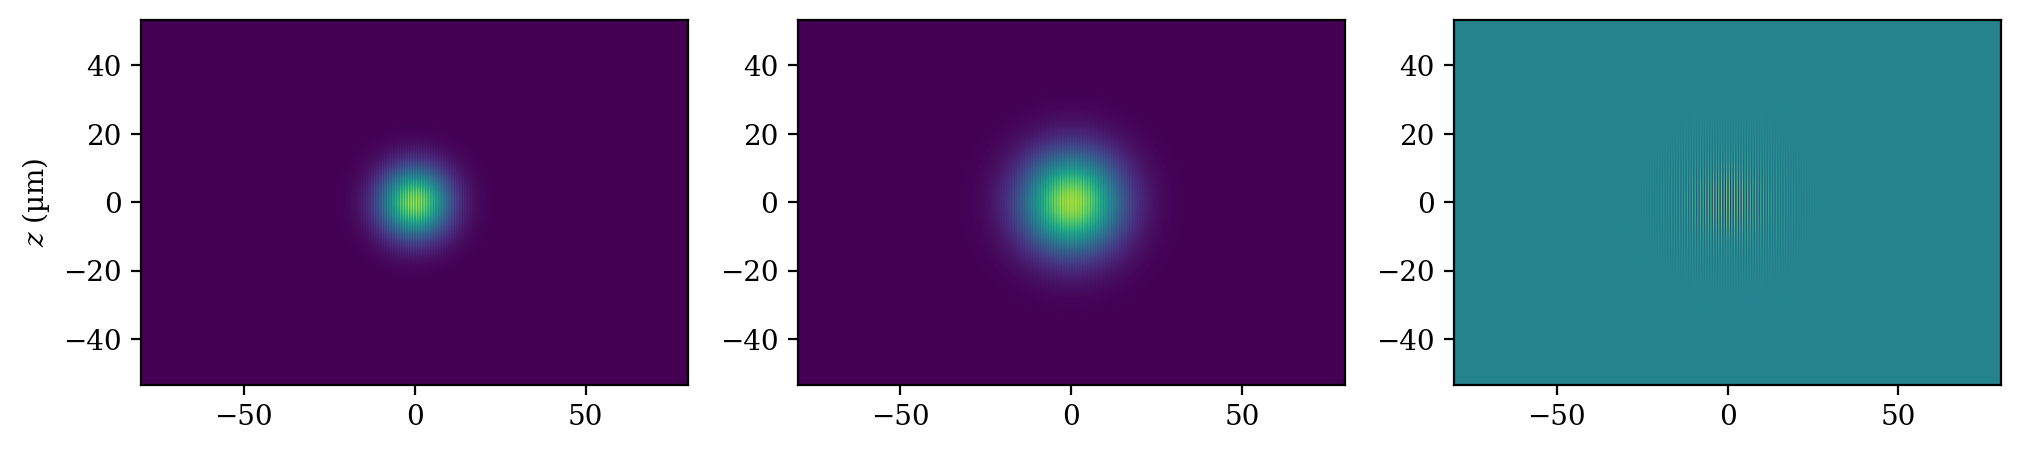

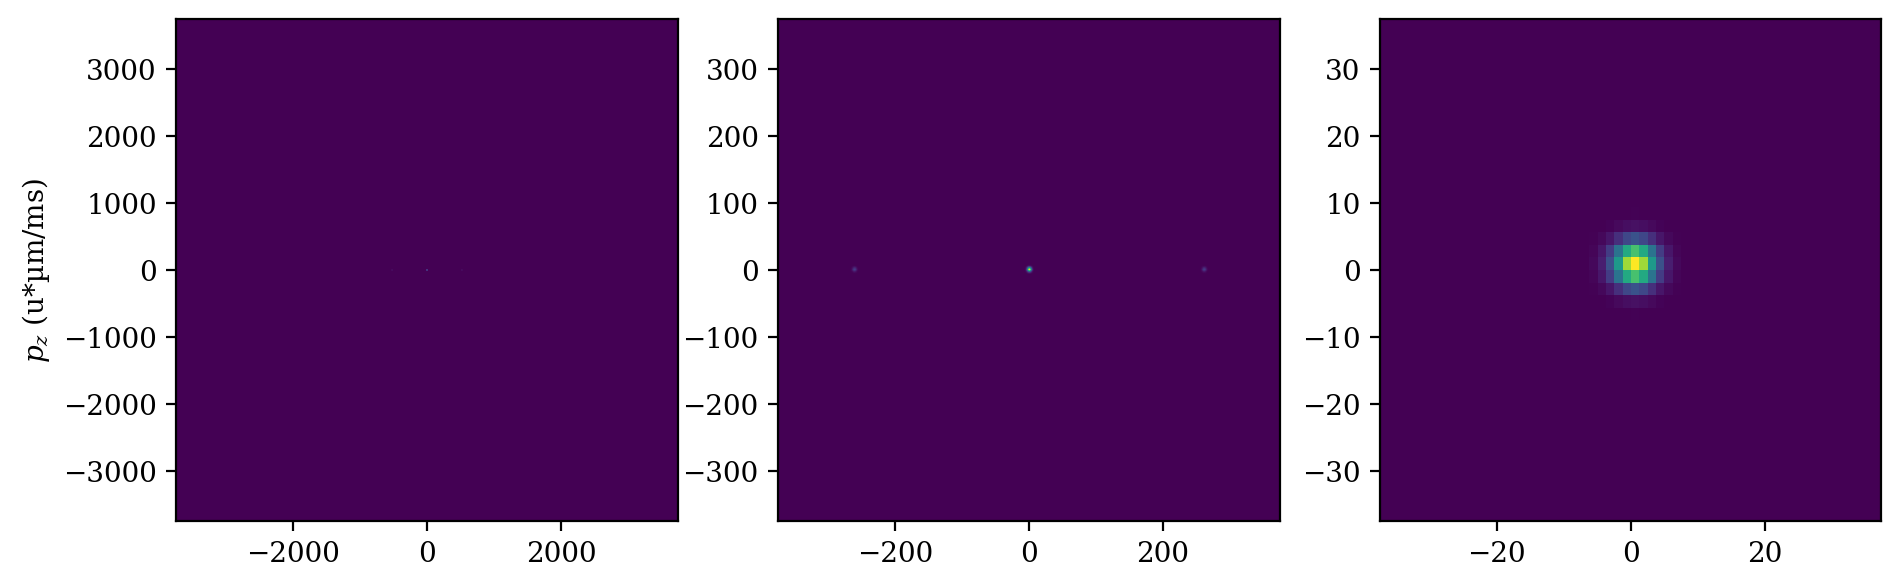

time = 0.55 µs
0.9999999999999507 |psi|^2


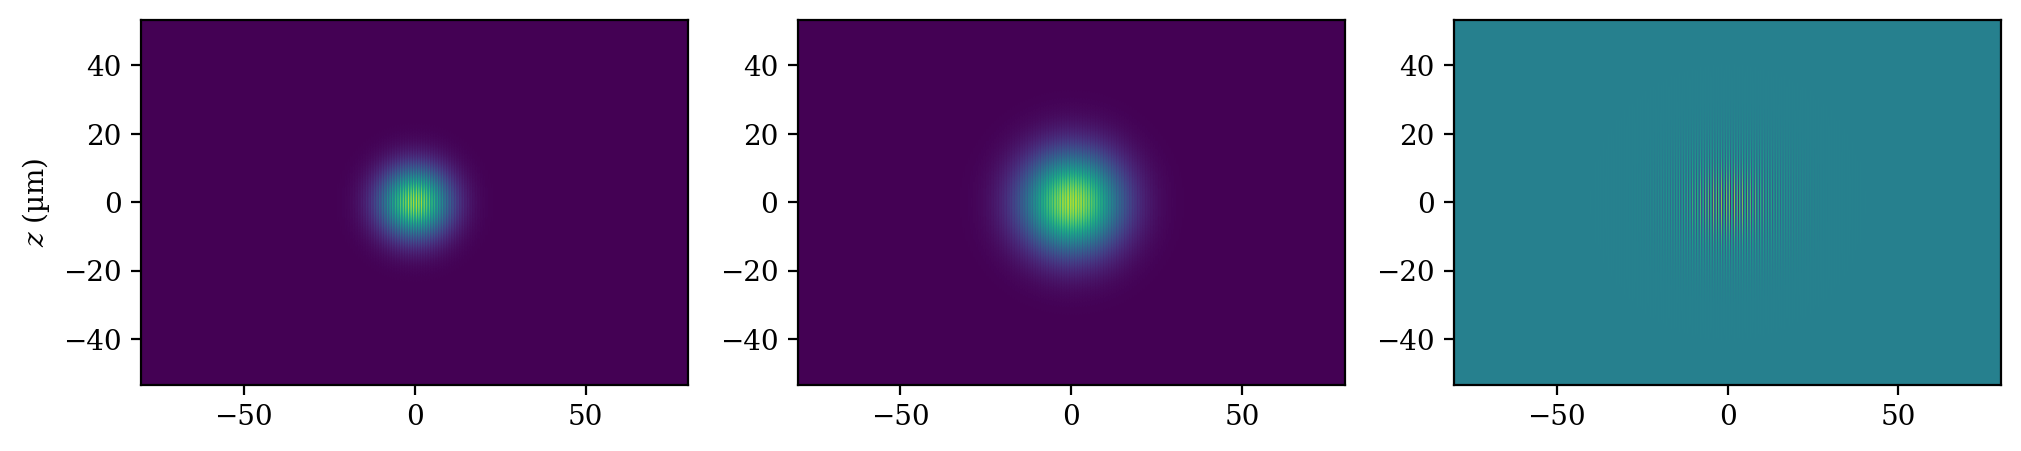

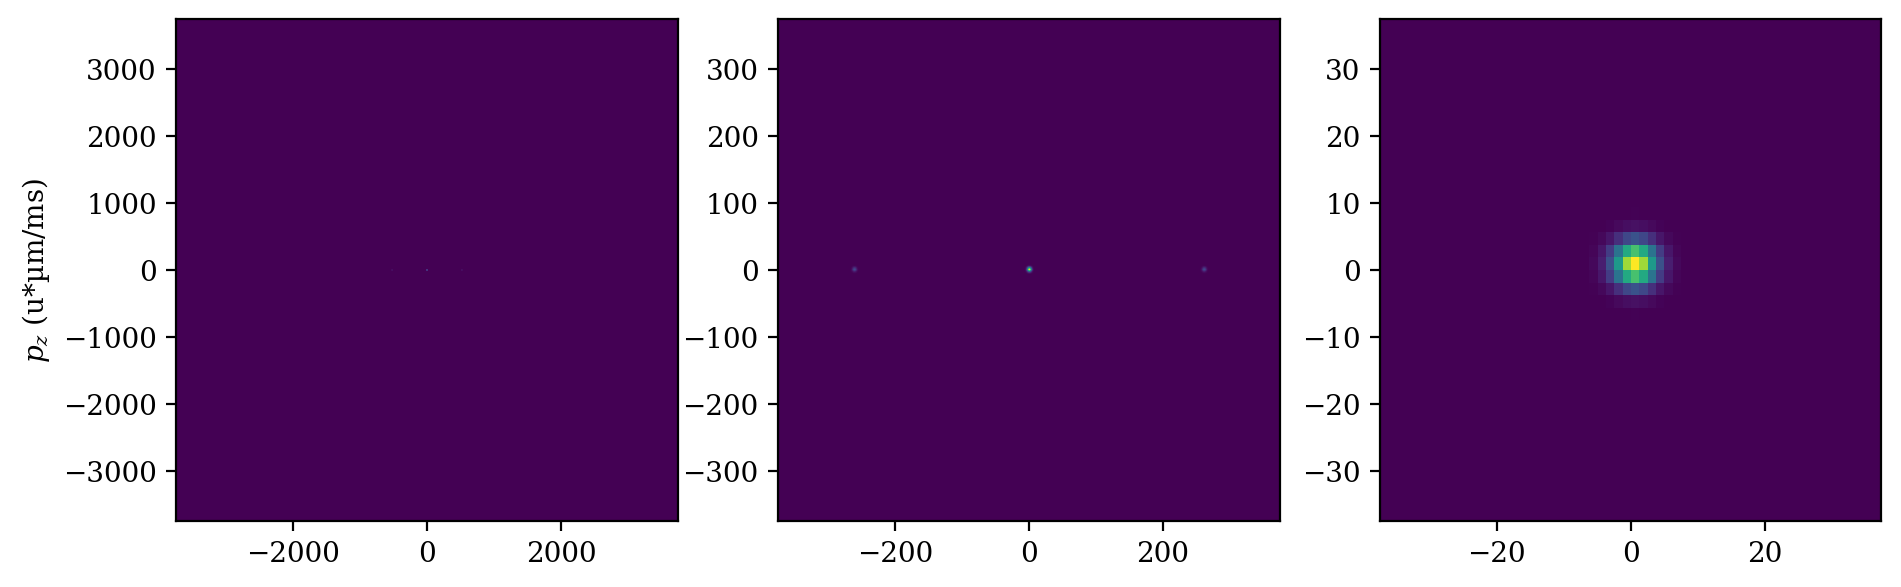

time = 0.6 µs
0.9999999999999509 |psi|^2


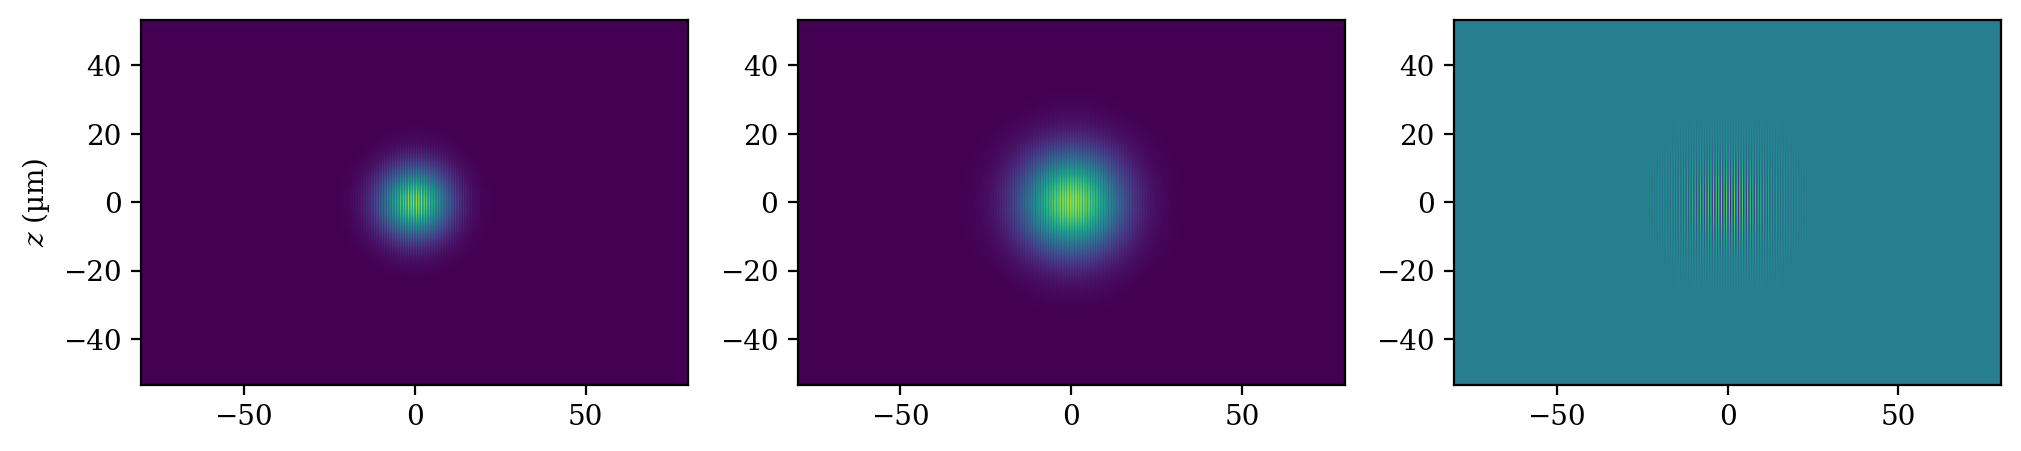

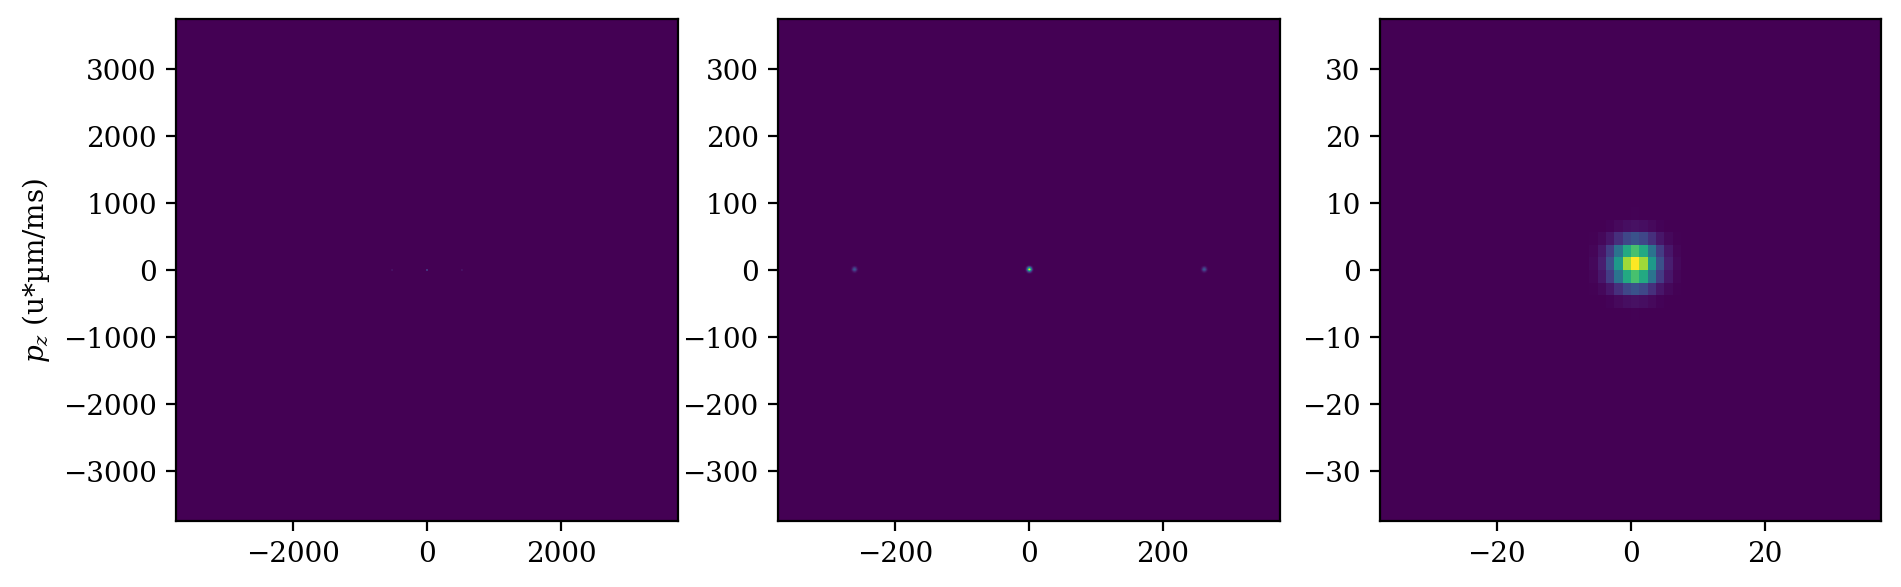

time = 0.65 µs
0.9999999999999507 |psi|^2


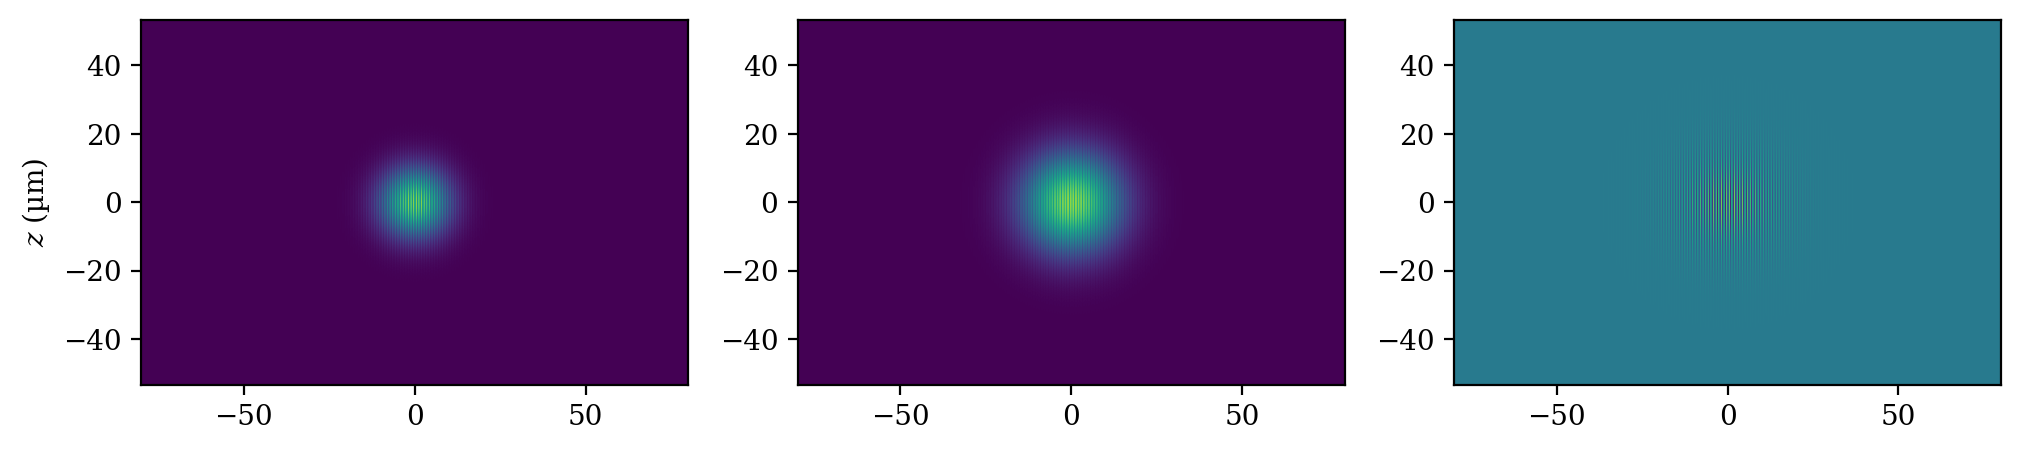

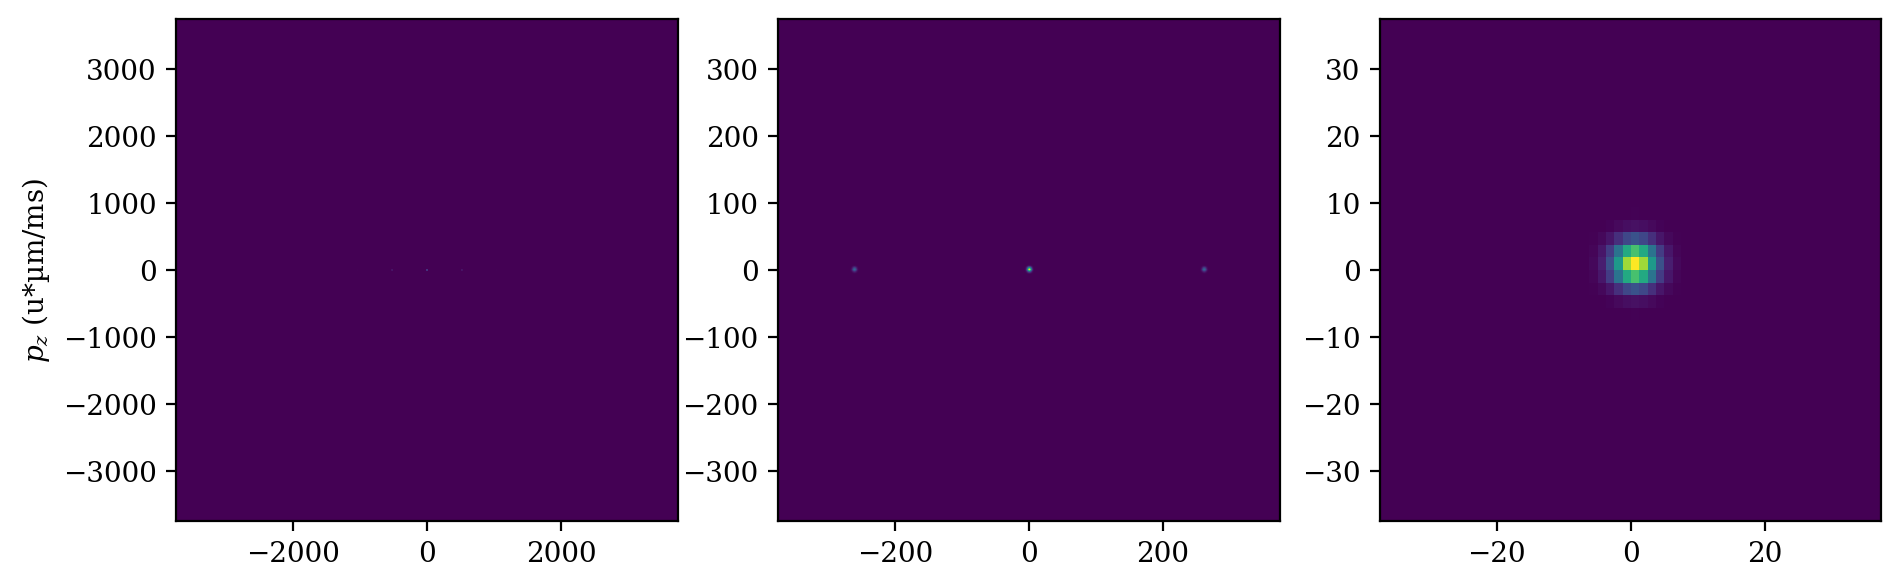

time = 0.7 µs
0.9999999999999512 |psi|^2


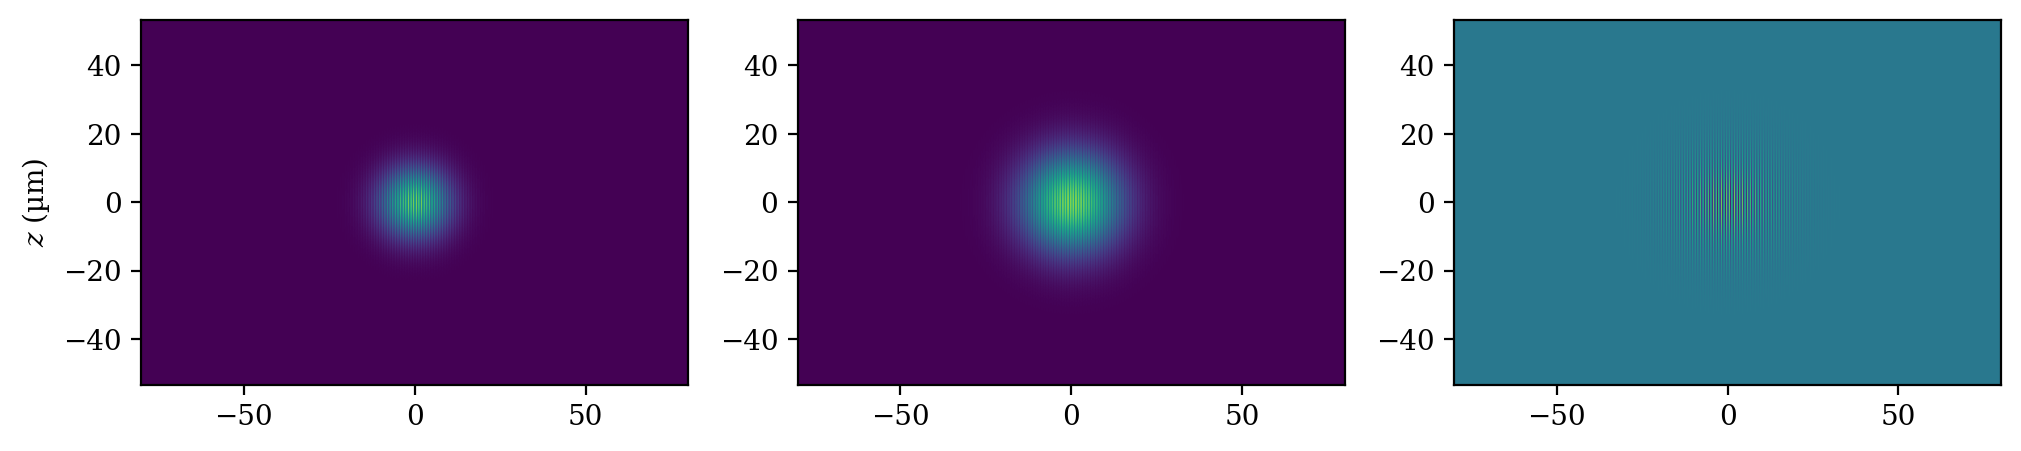

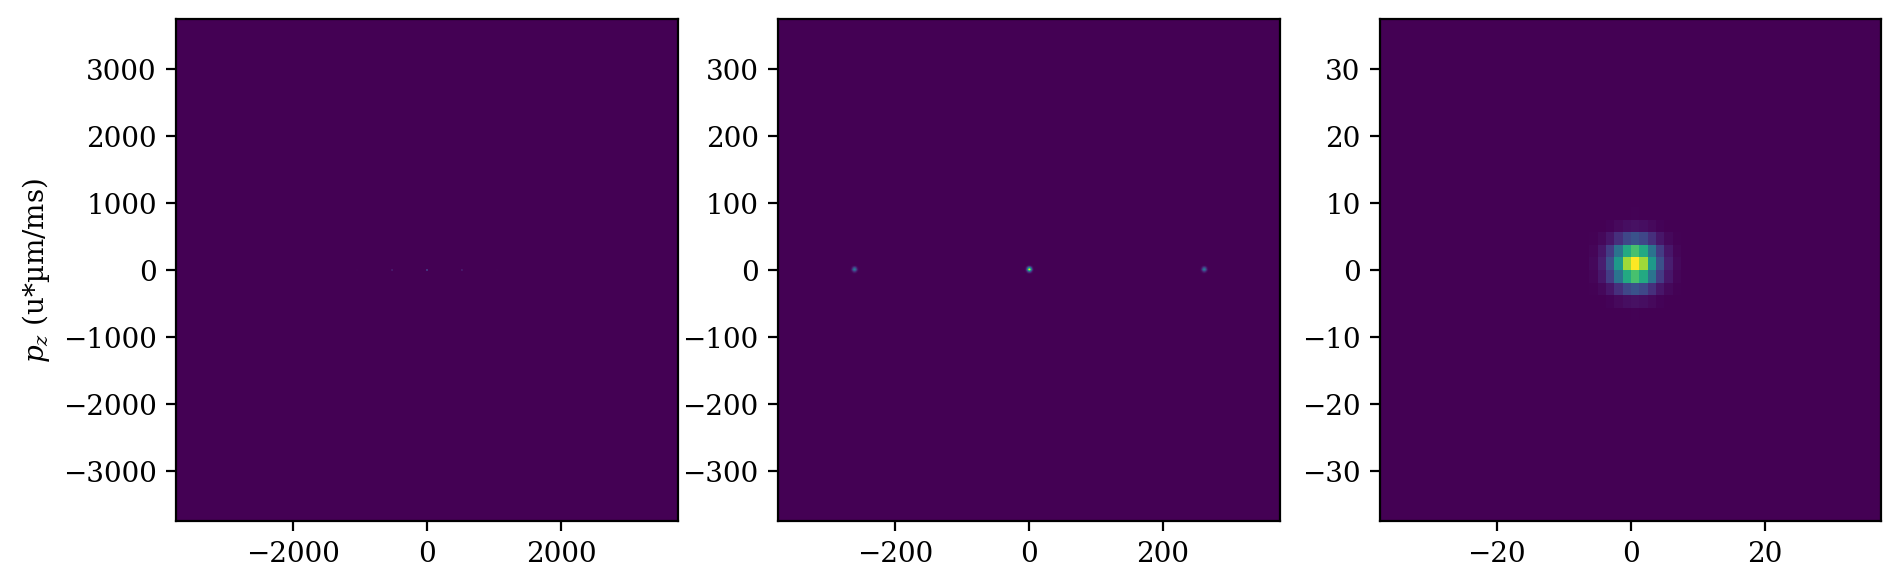

time = 0.75 µs
0.999999999999951 |psi|^2


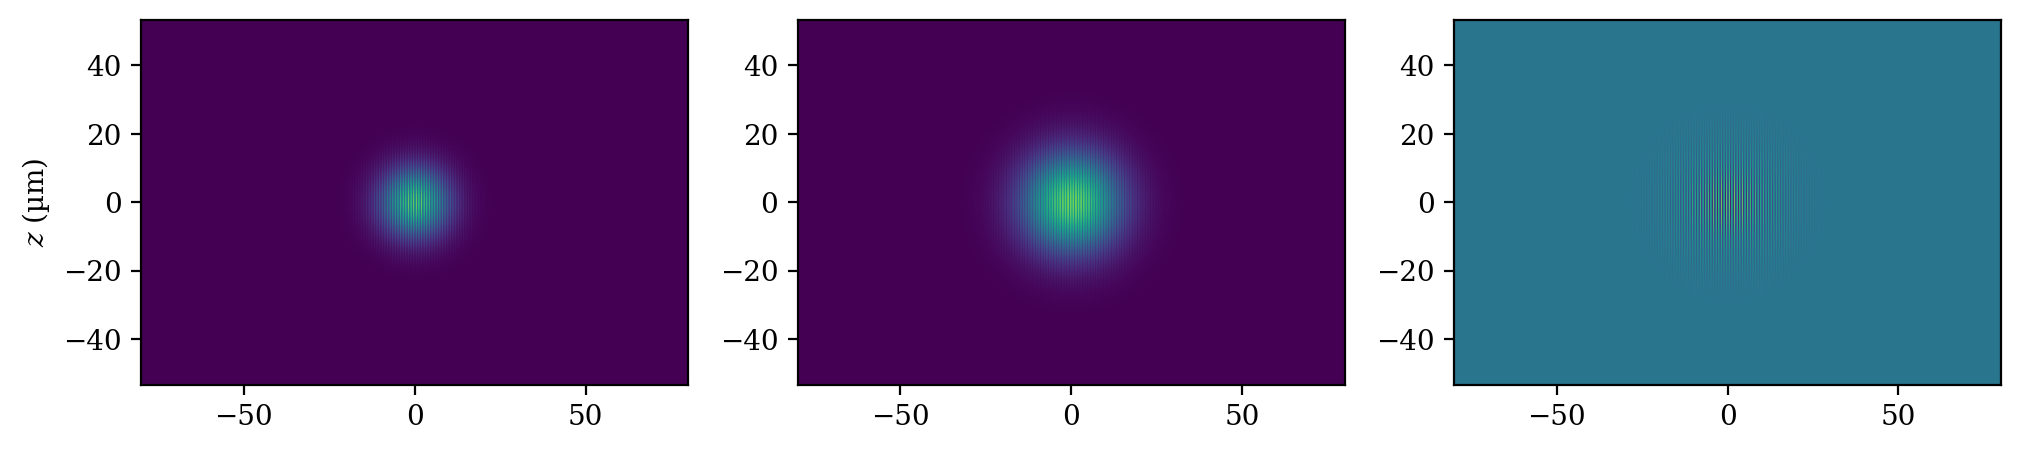

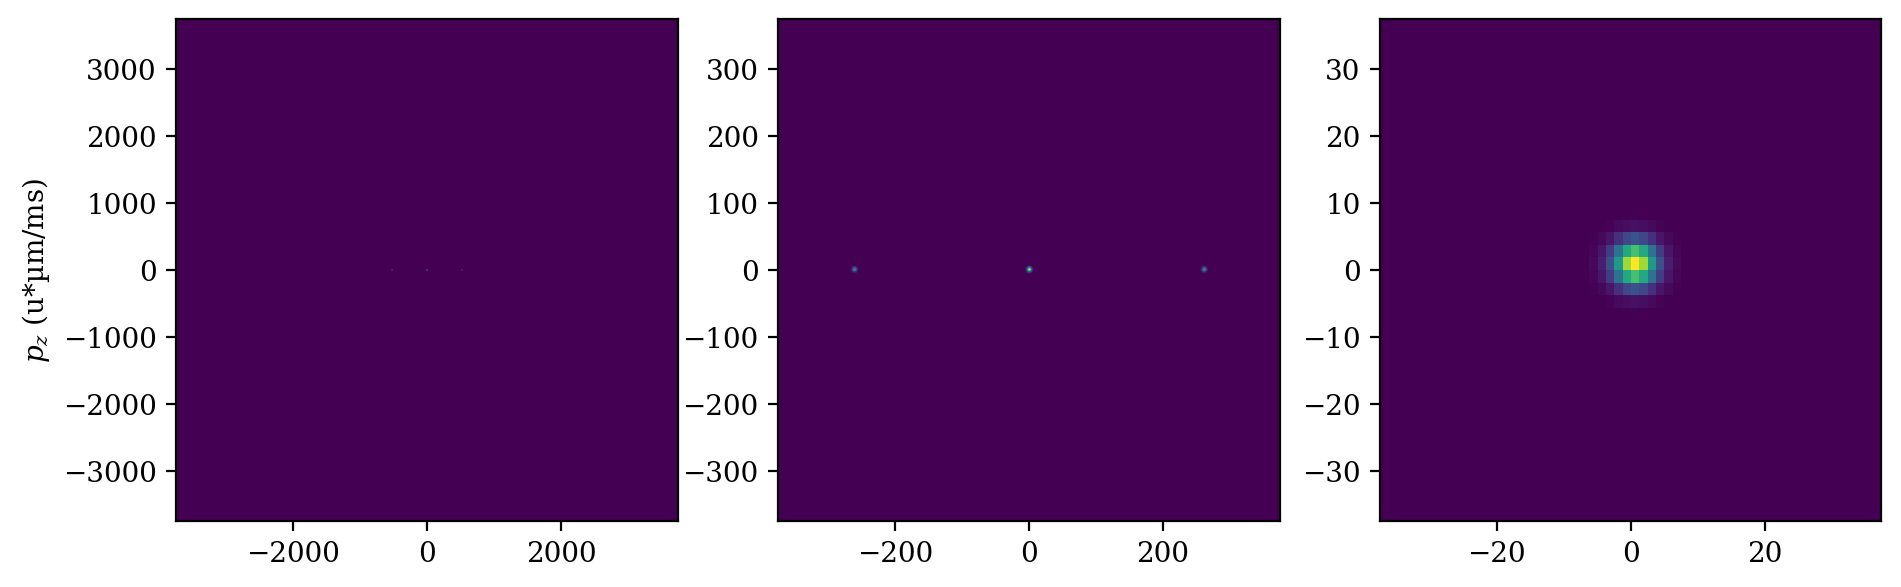

time = 0.8 µs
0.9999999999999512 |psi|^2


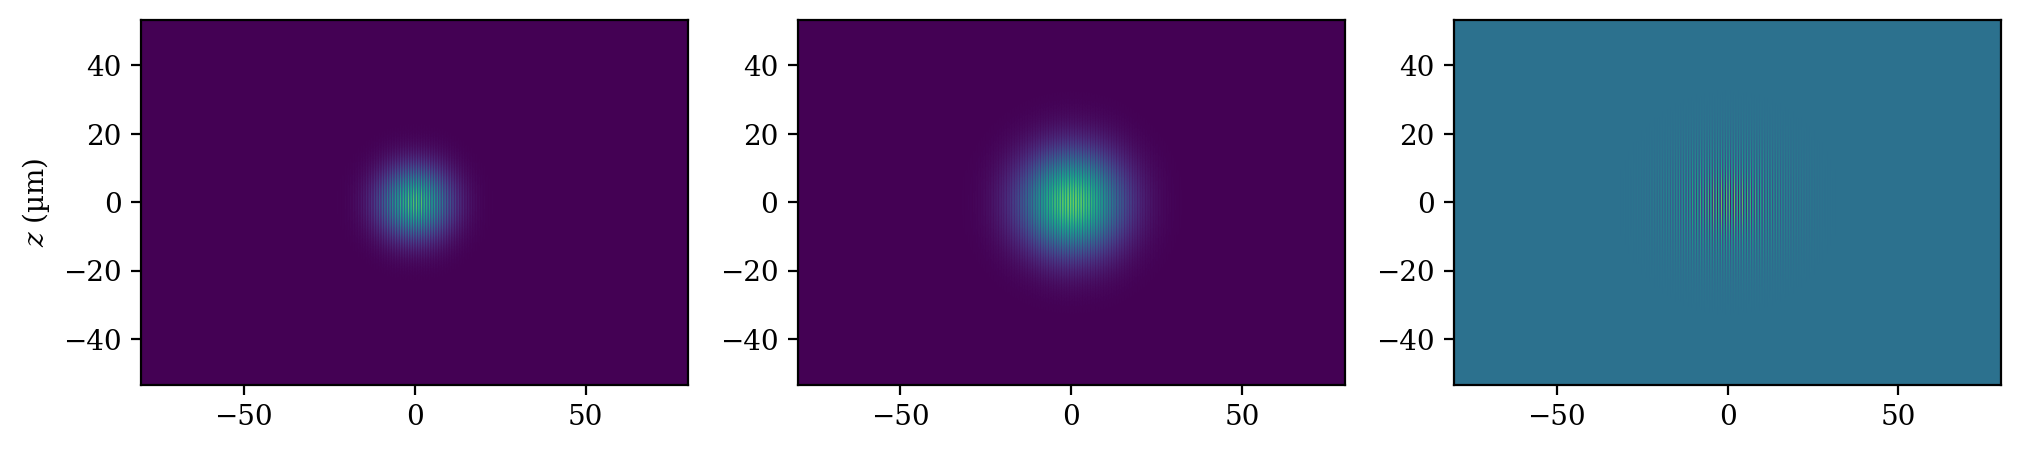

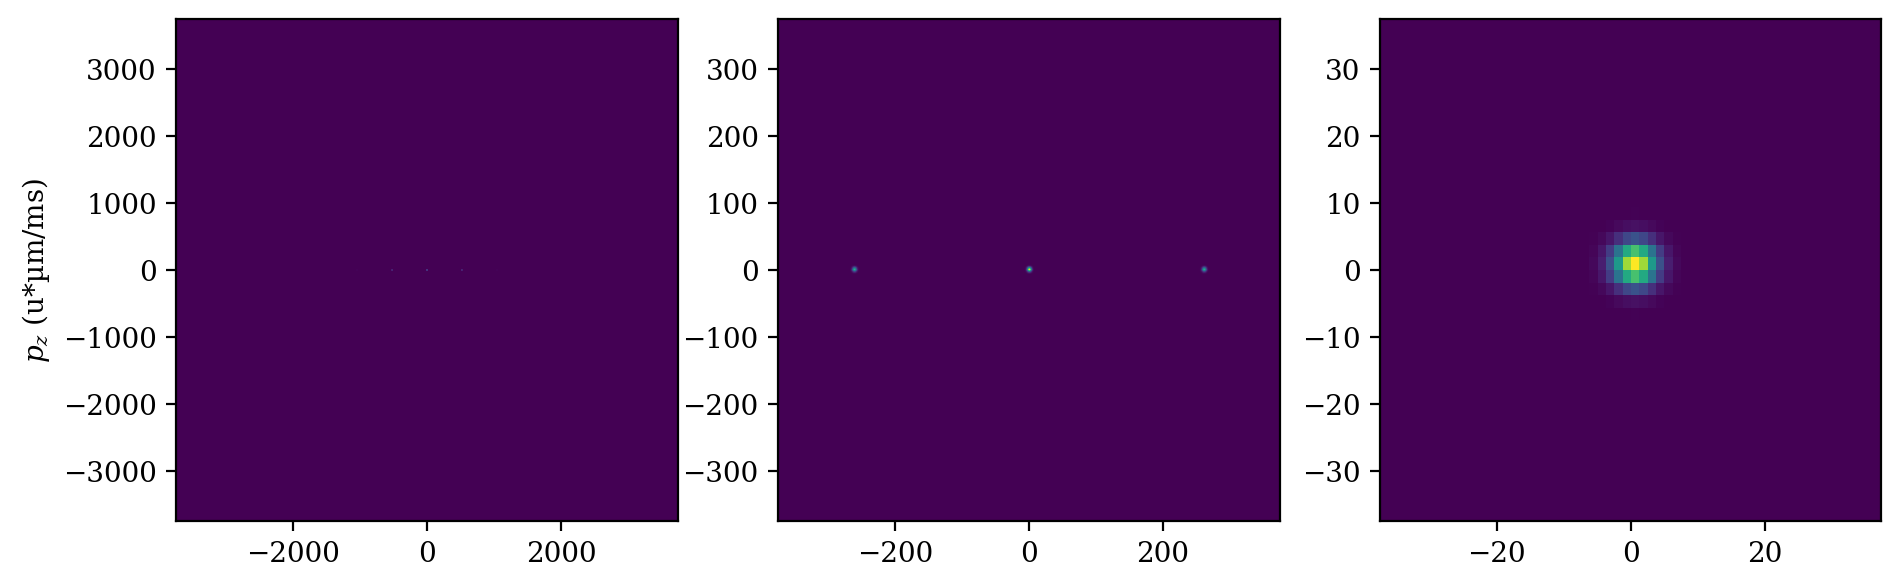

time = 0.85 µs
0.9999999999999514 |psi|^2


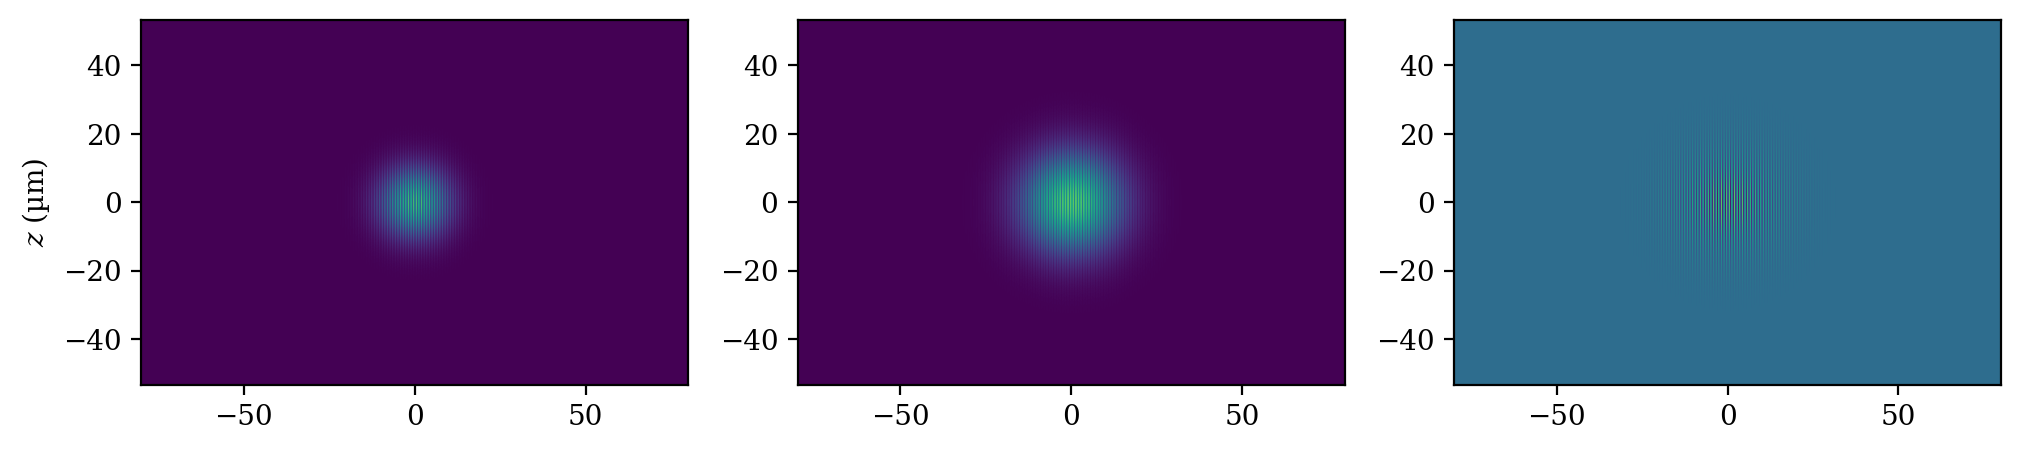

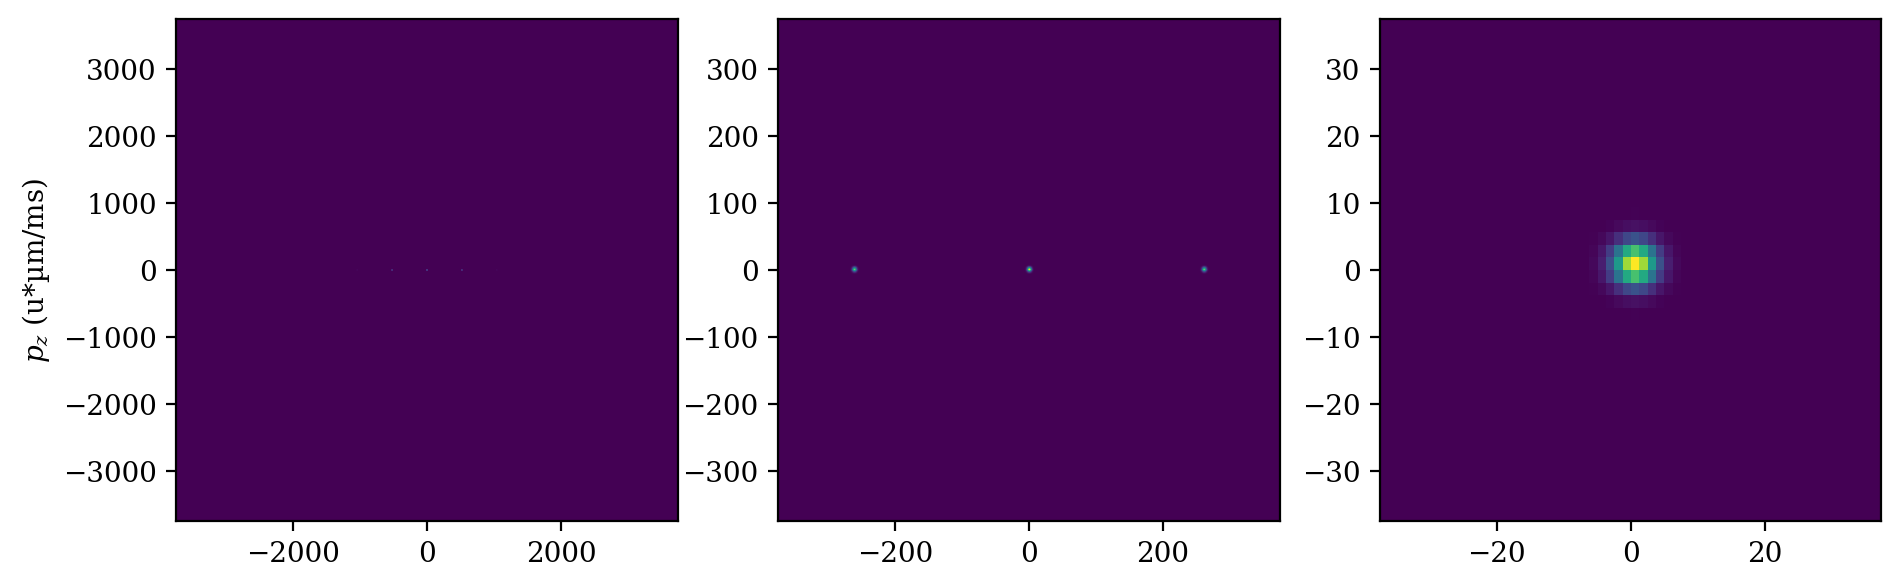

time = 0.9 µs
0.9999999999999512 |psi|^2


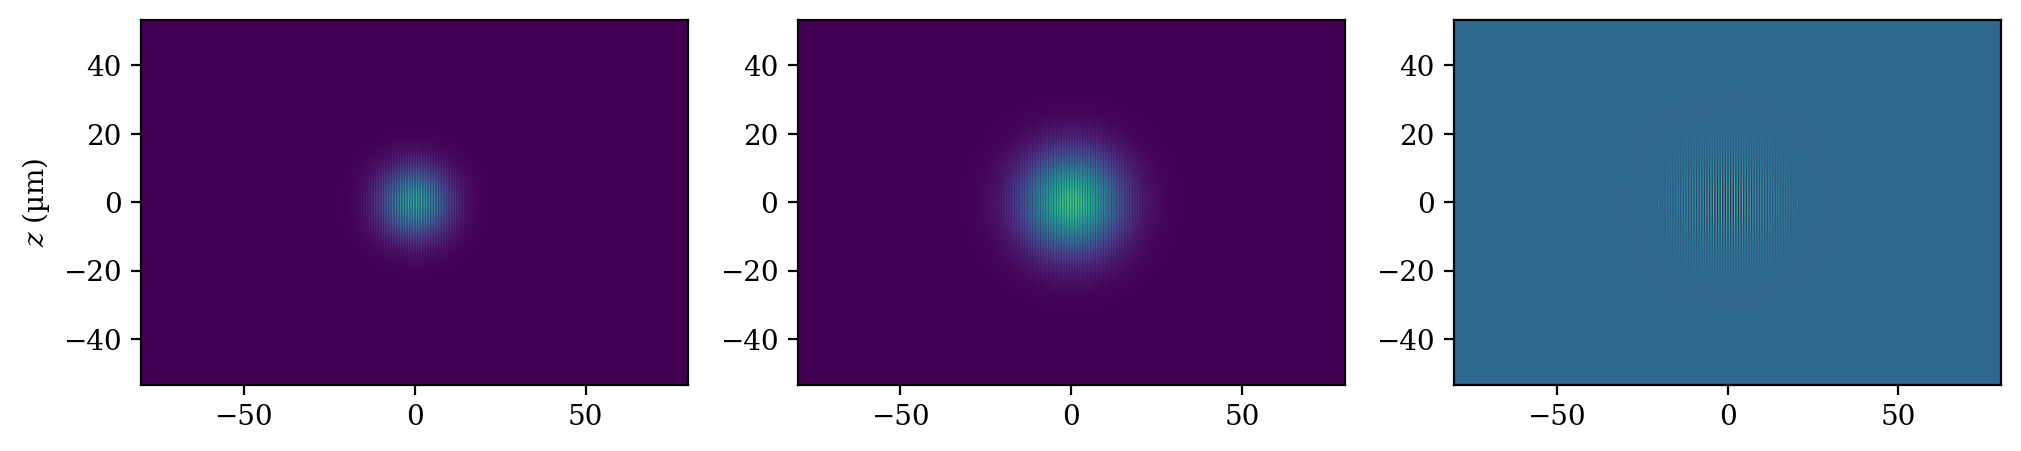

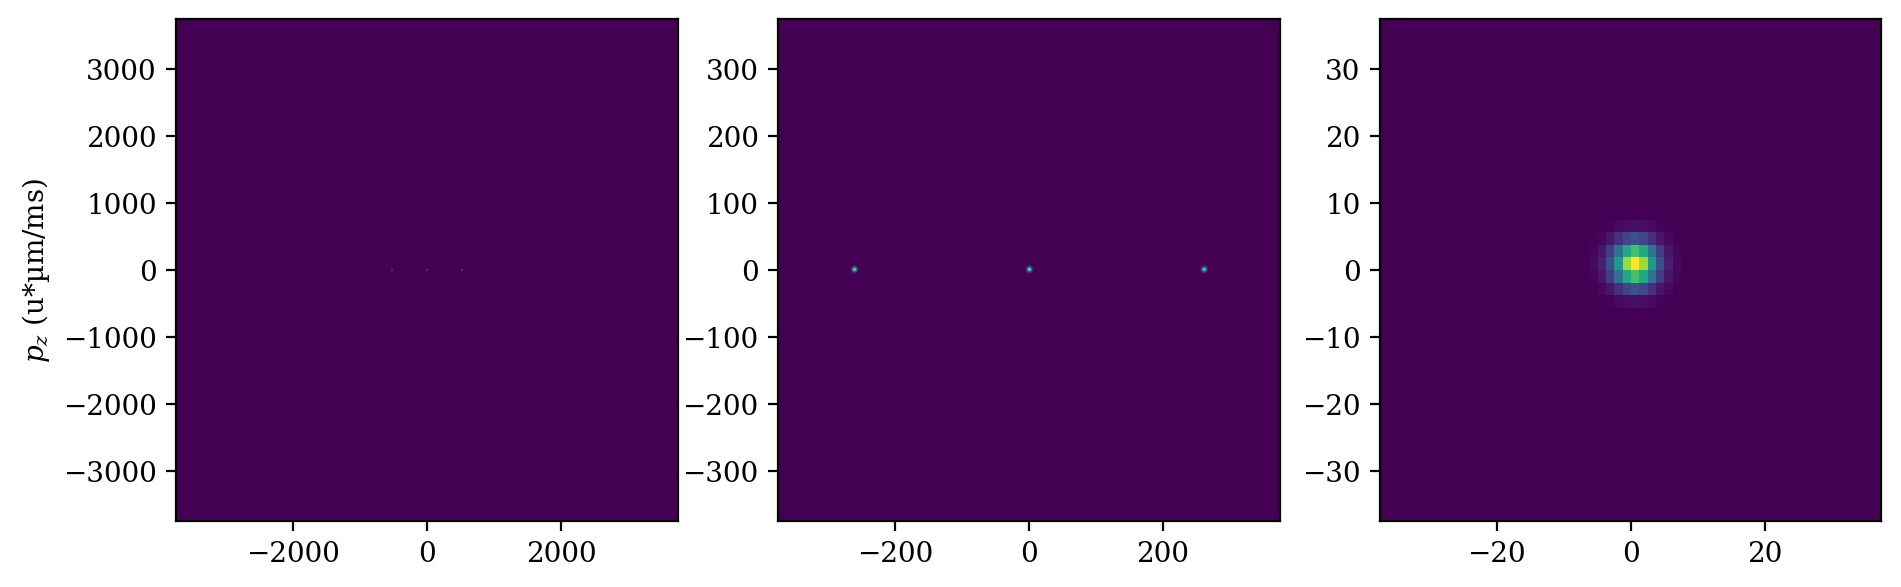

time = 0.95 µs
0.9999999999999514 |psi|^2


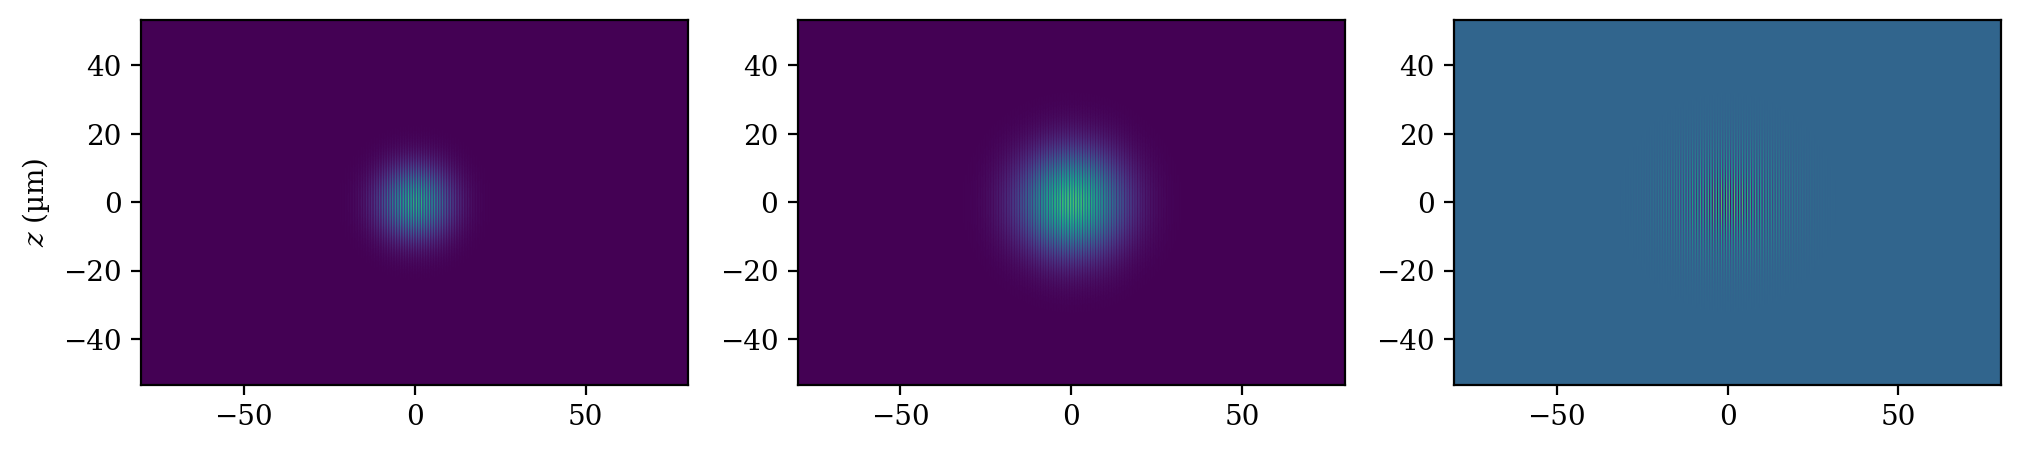

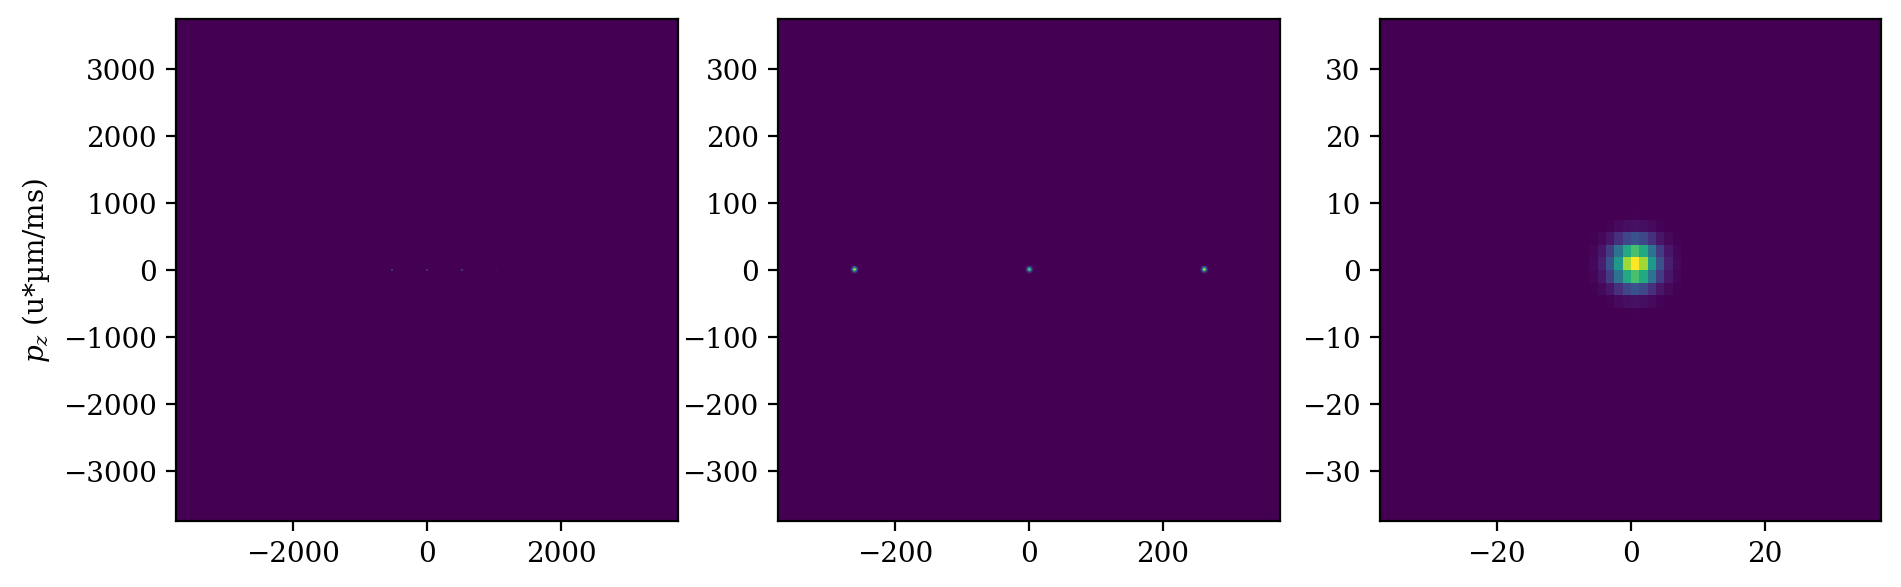

time = 1.0 µs
0.9999999999999513 |psi|^2


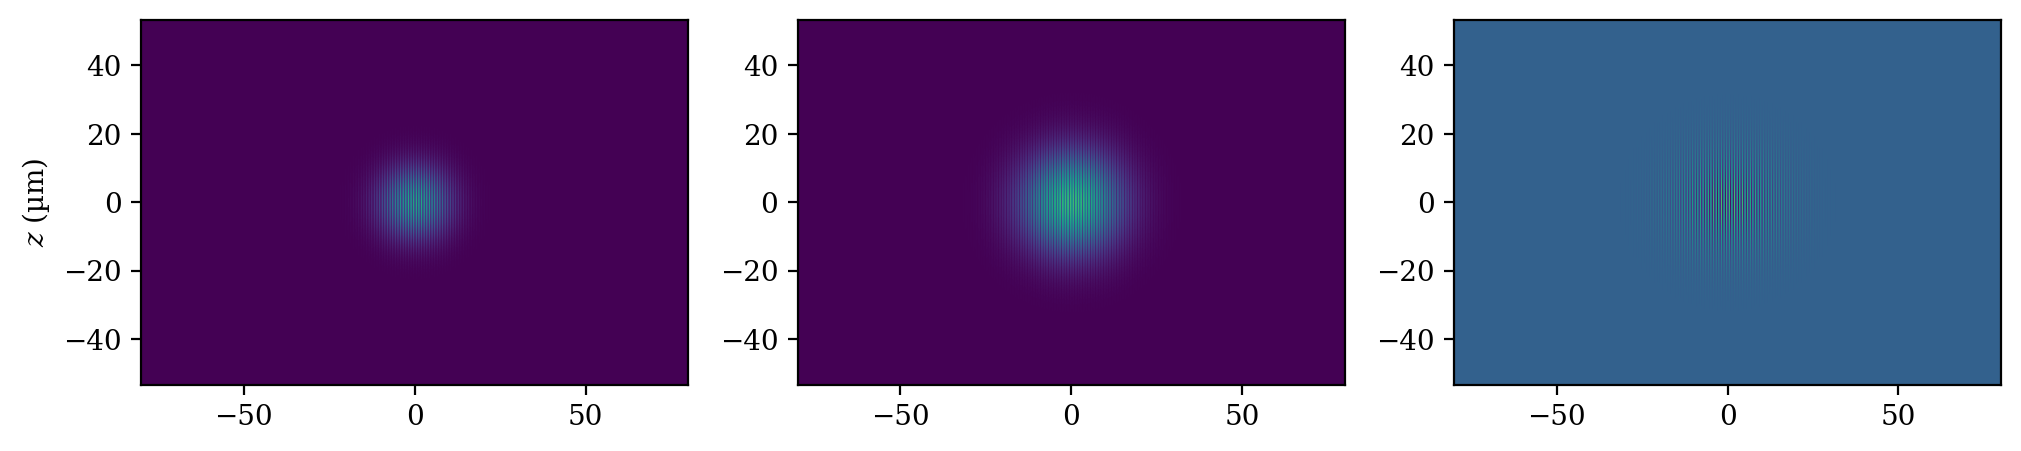

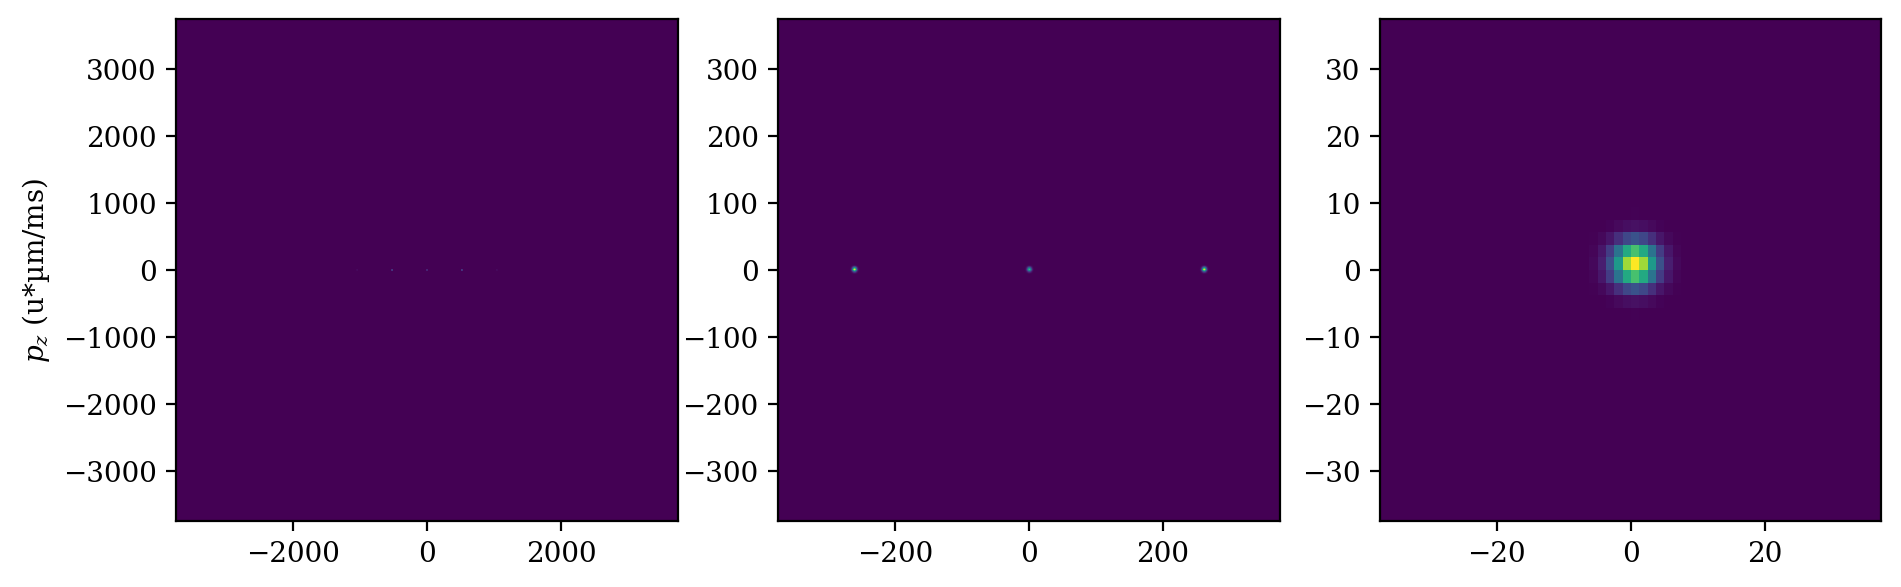

time = 1.05 µs
0.9999999999999514 |psi|^2


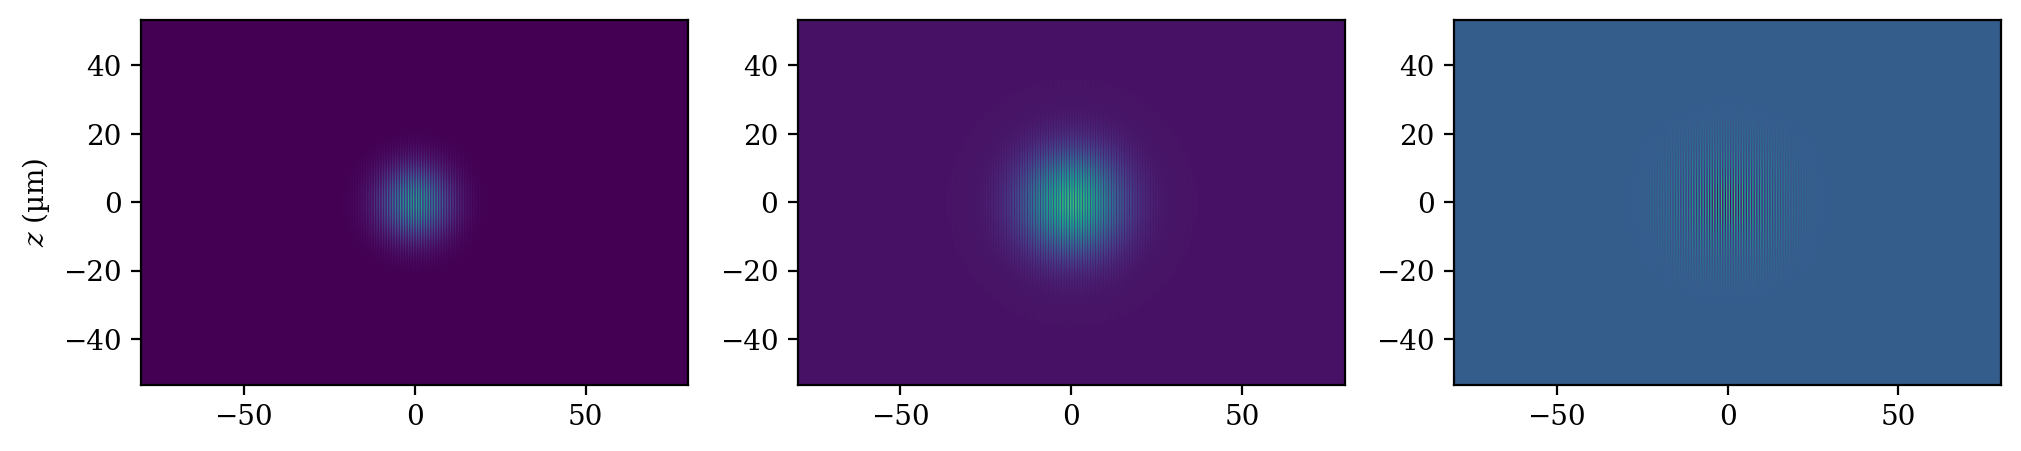

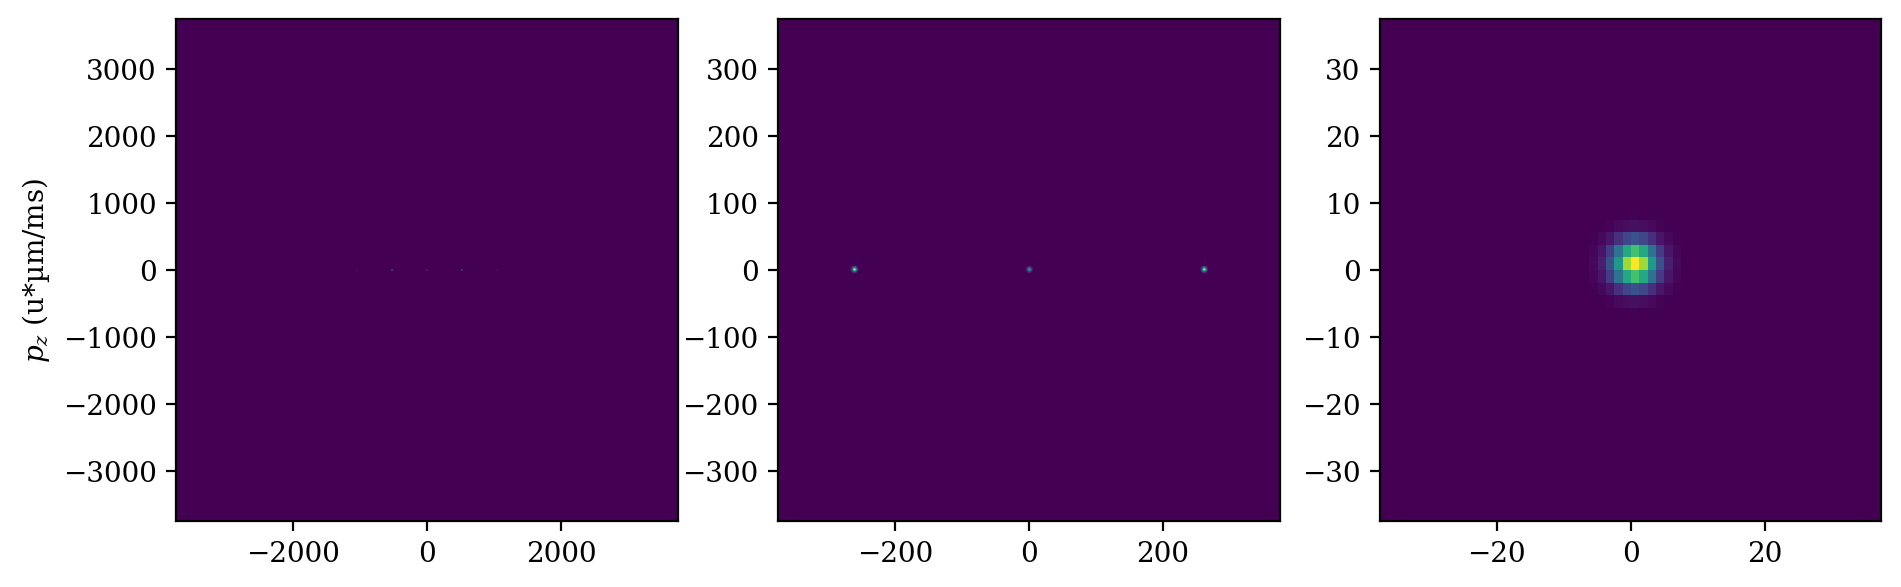

time = 1.1 µs
0.9999999999999512 |psi|^2


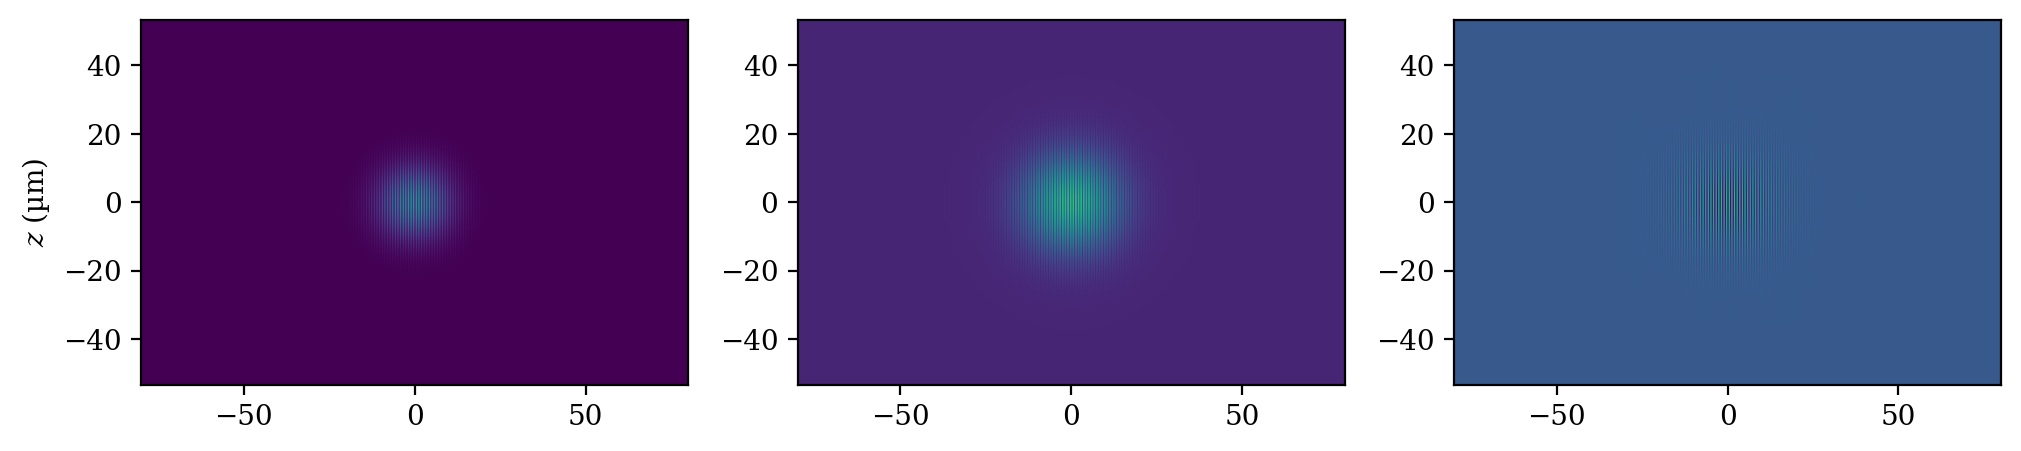

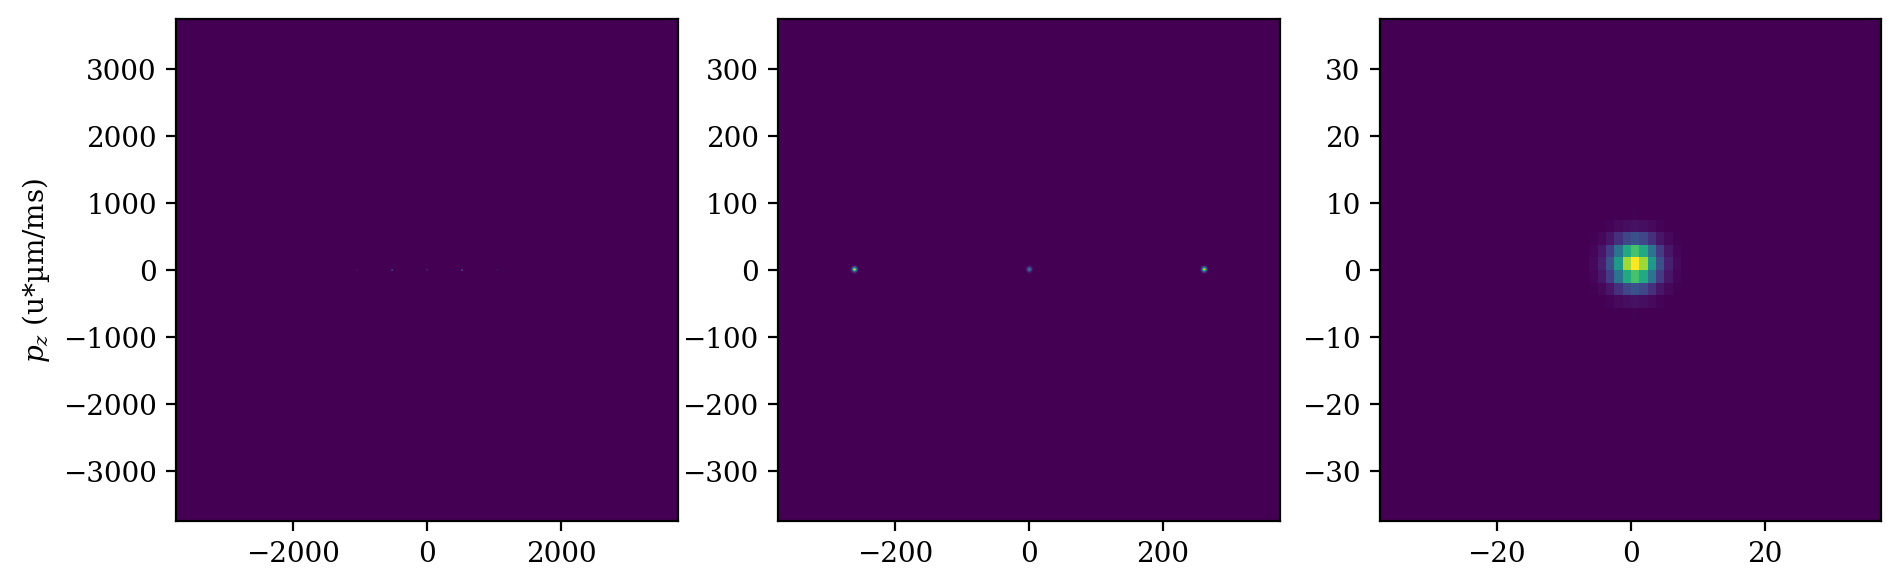

time = 1.15 µs
0.9999999999999514 |psi|^2


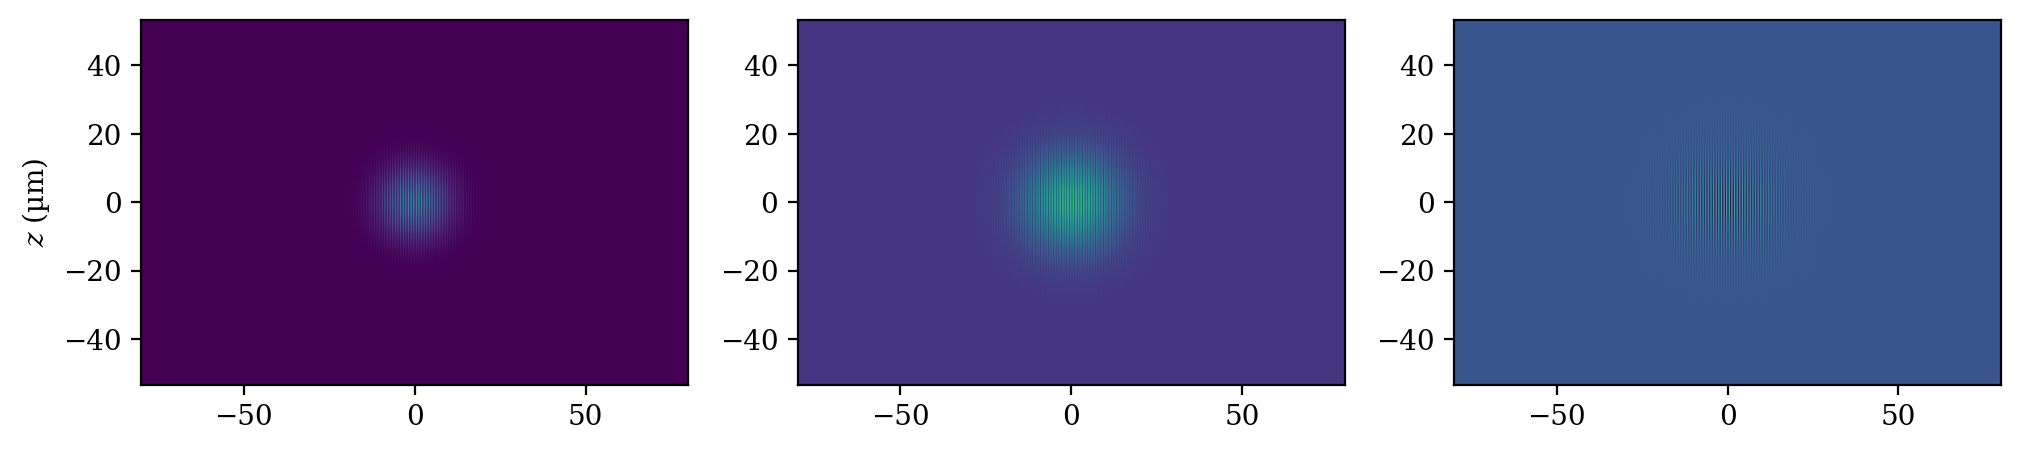

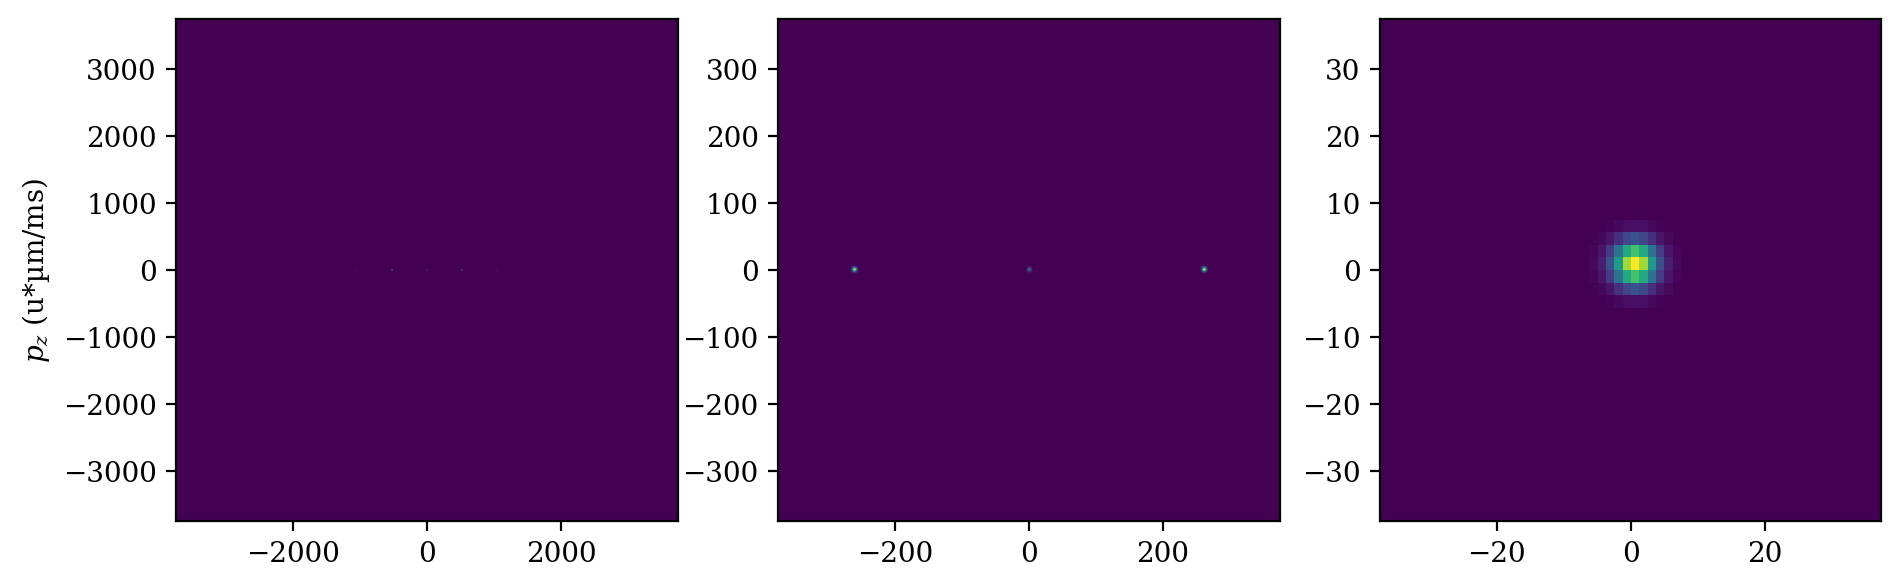

time = 1.2 µs
0.9999999999999509 |psi|^2


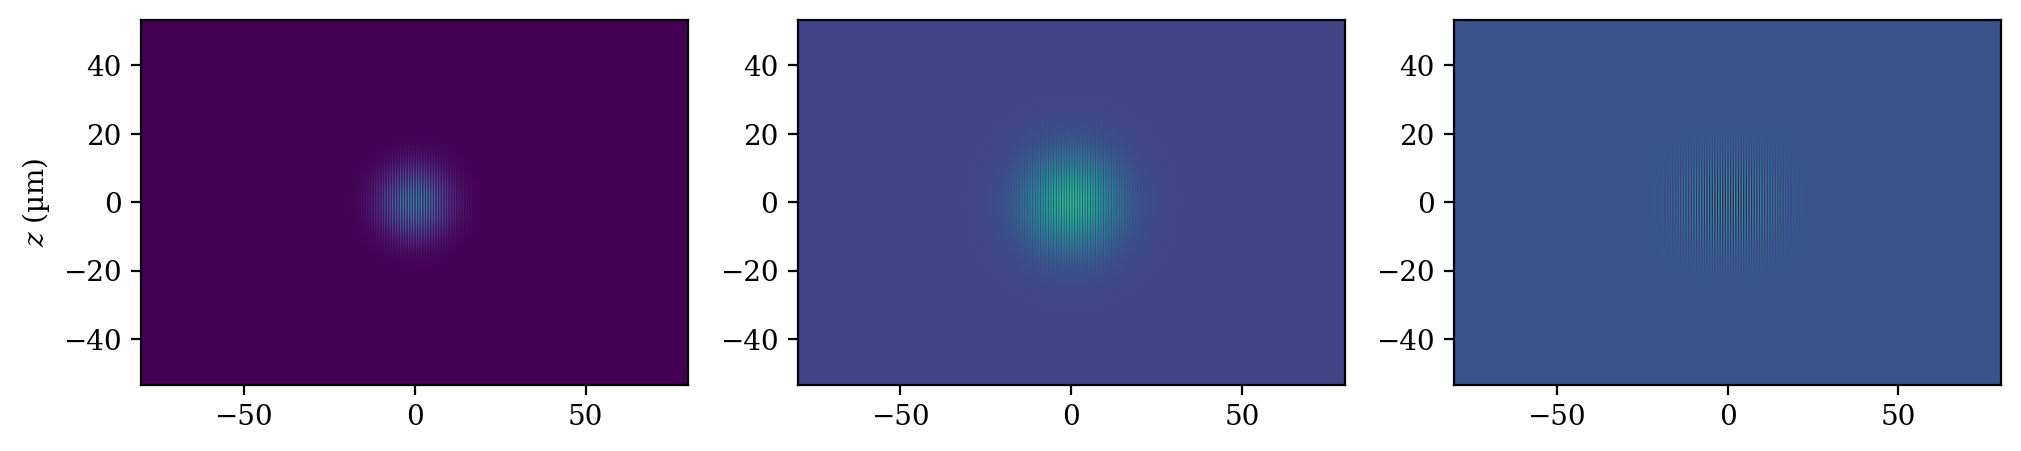

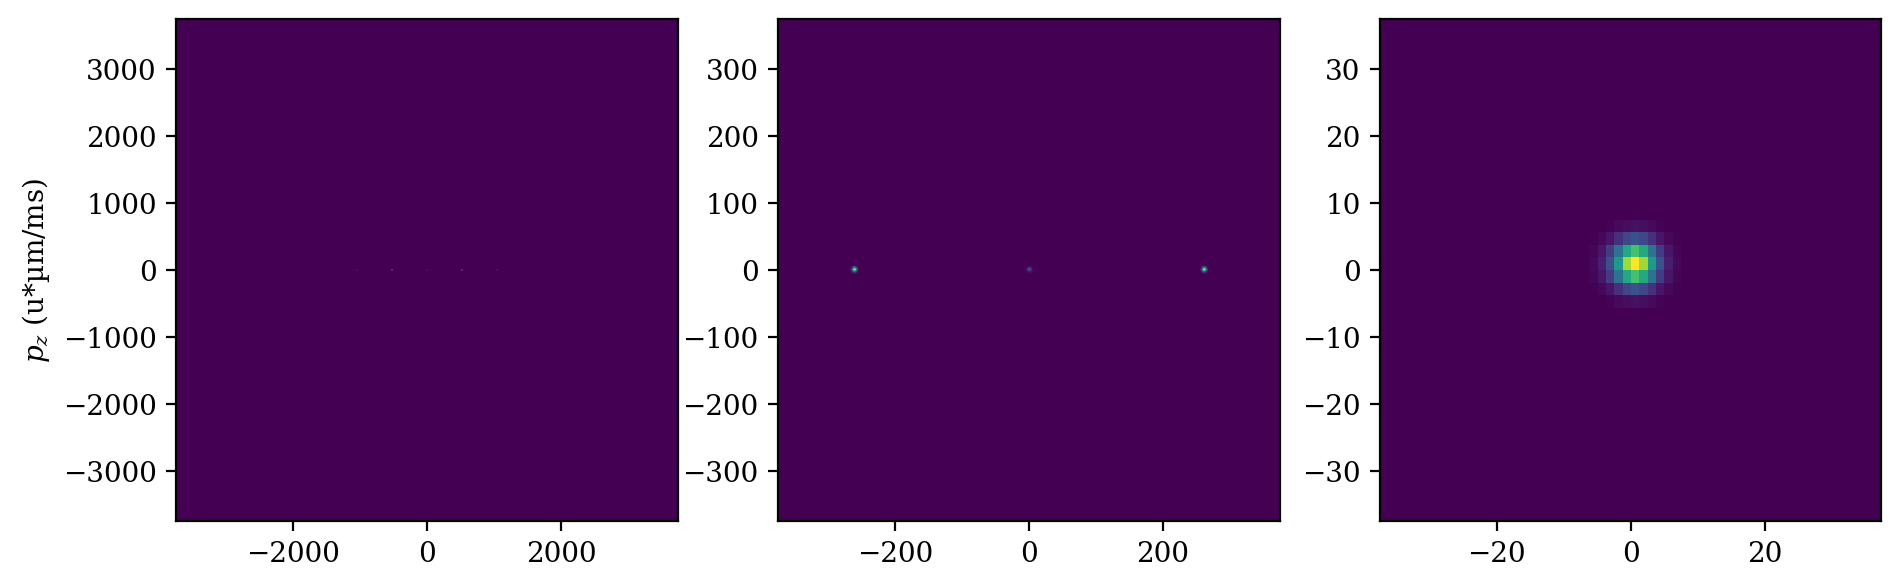

time = 1.25 µs
0.9999999999999507 |psi|^2


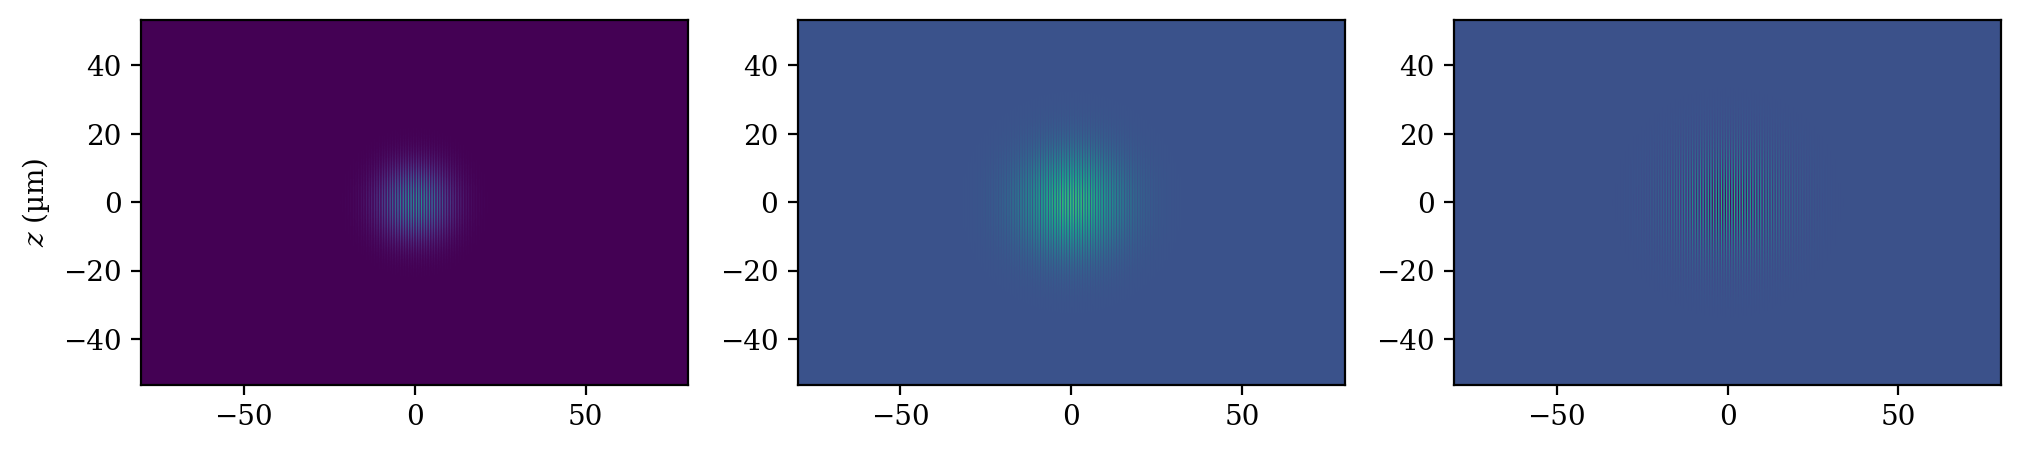

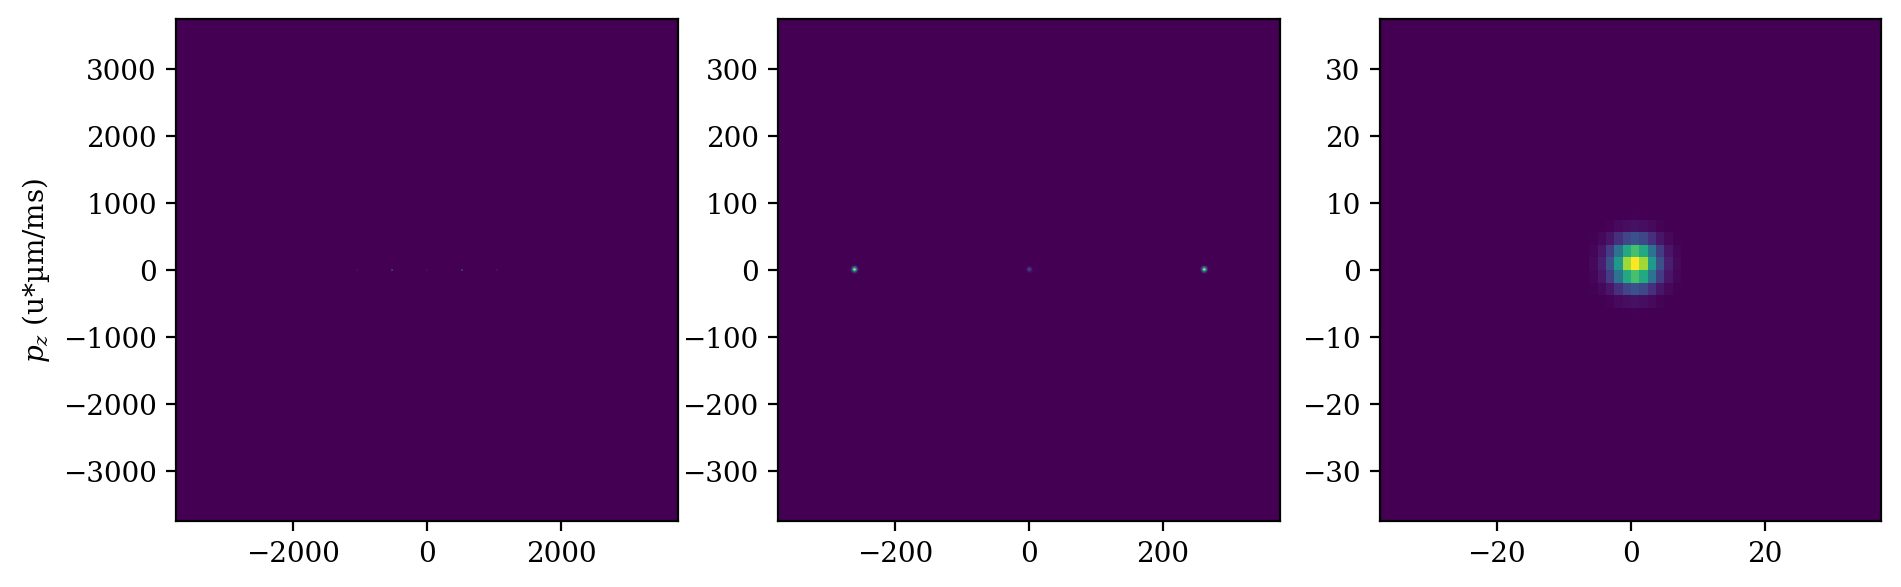

time = 1.3 µs
0.9999999999999507 |psi|^2


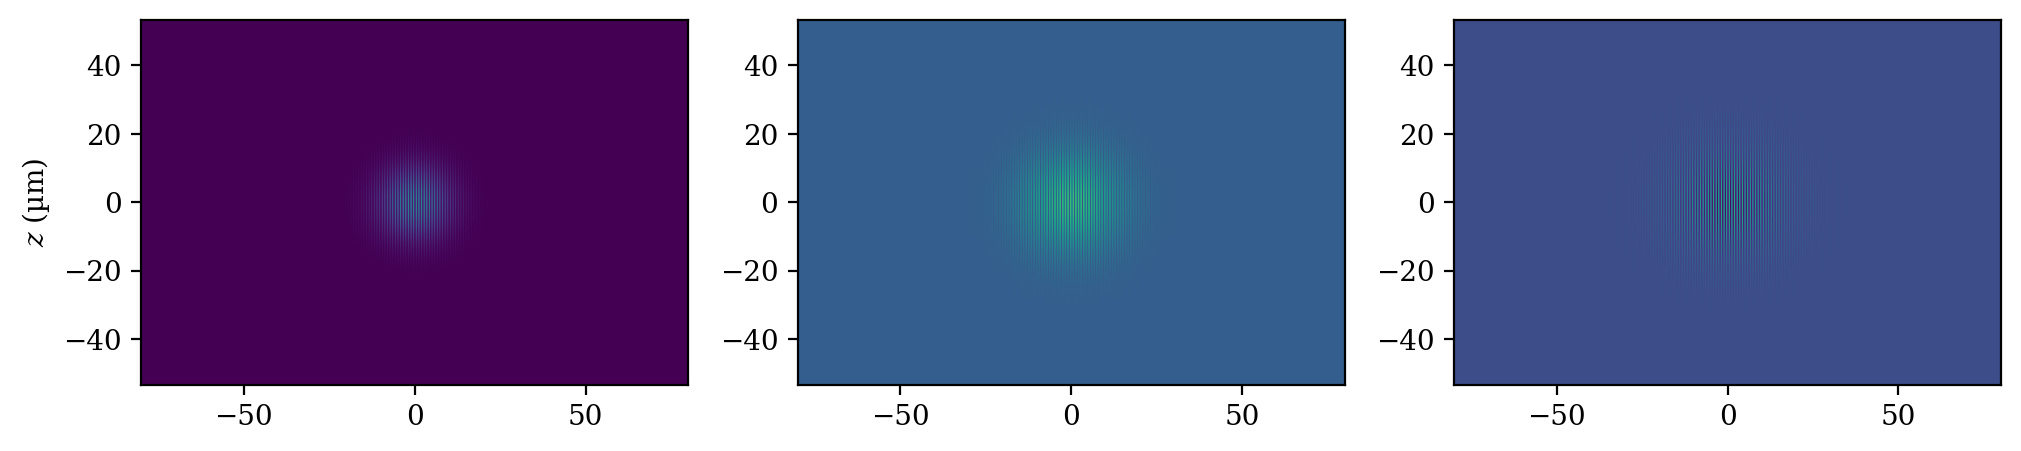

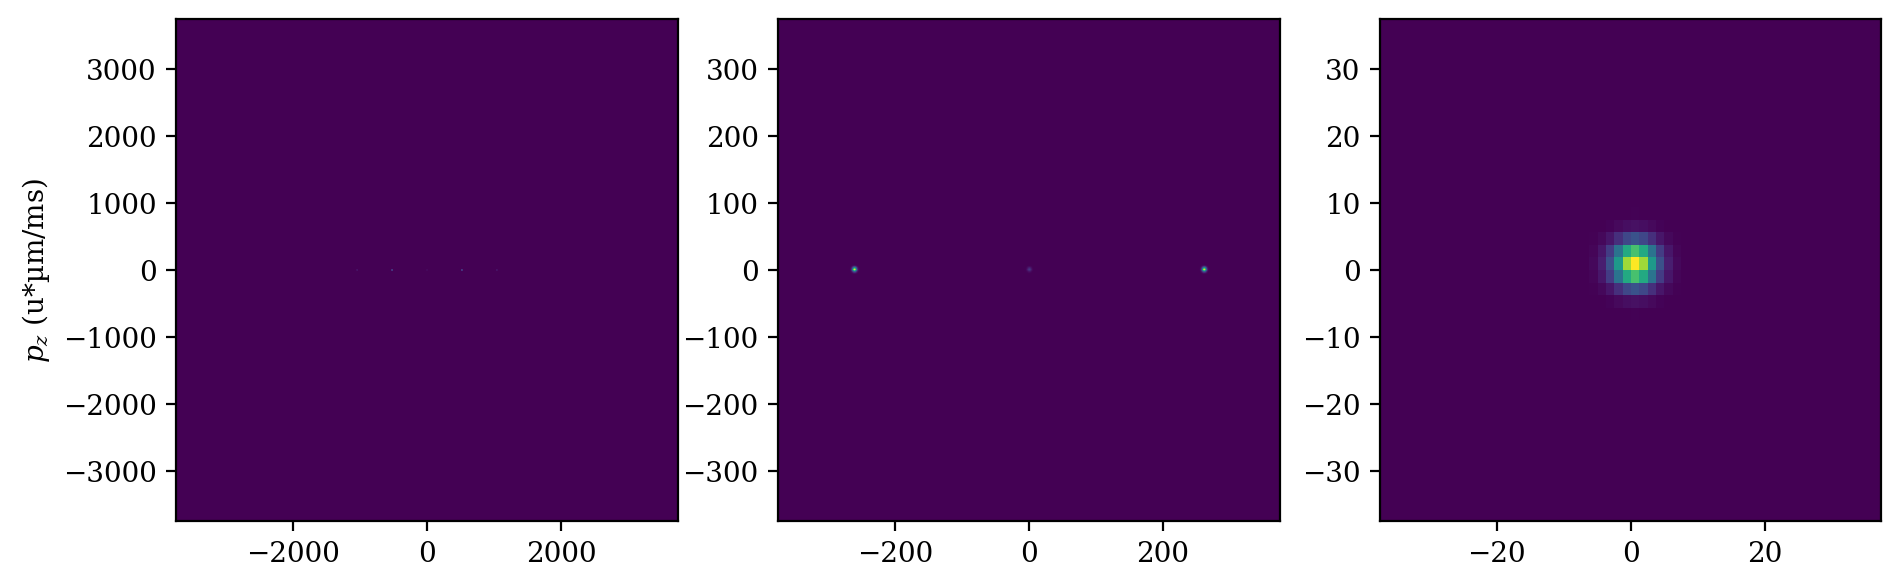

time = 1.35 µs
0.9999999999999509 |psi|^2


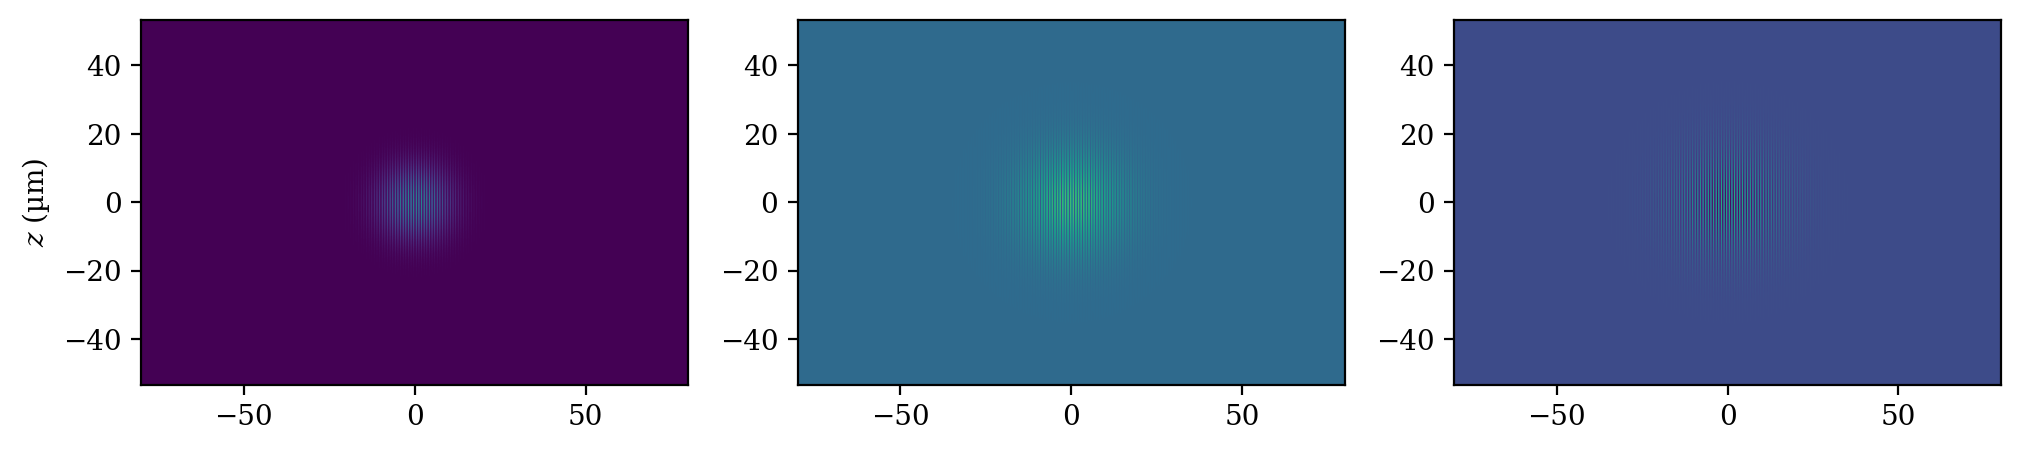

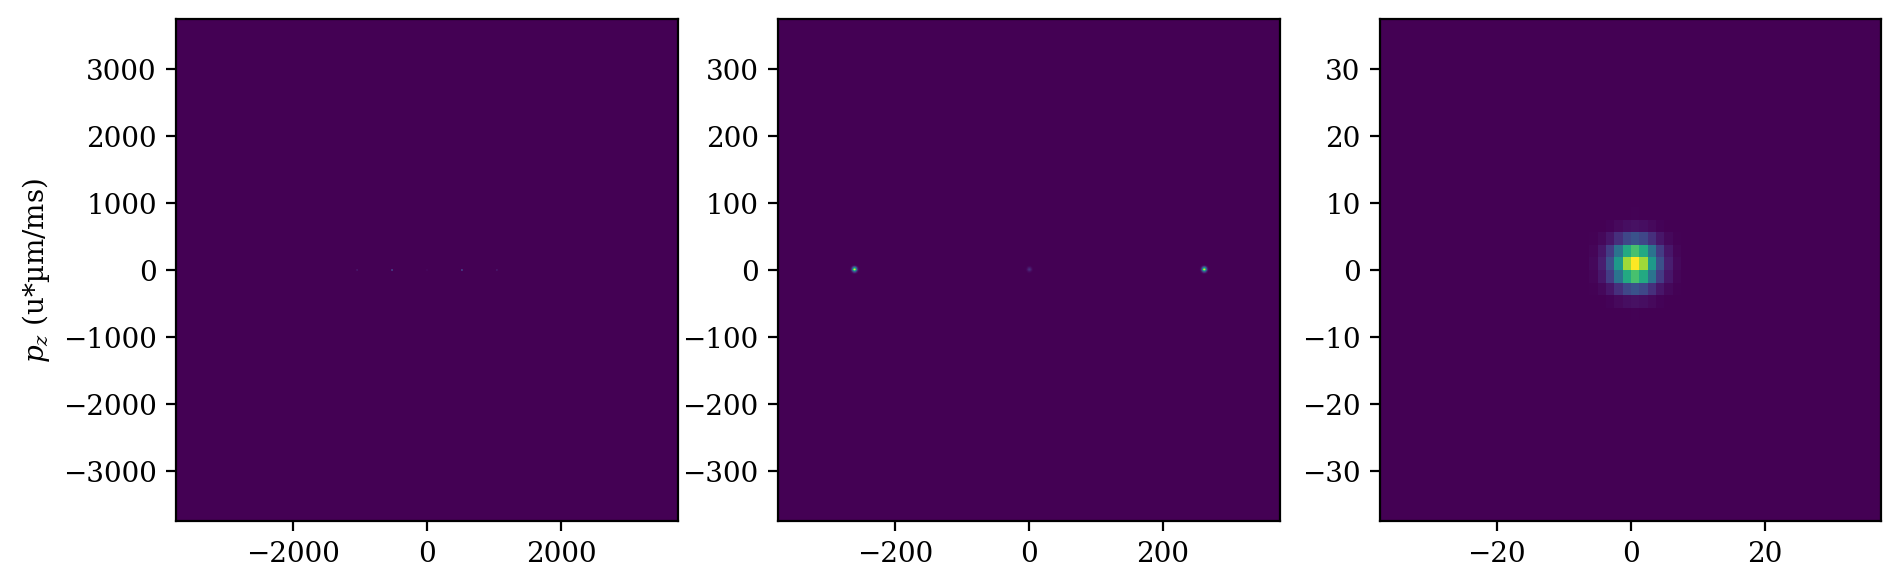

time = 1.4 µs
0.9999999999999507 |psi|^2


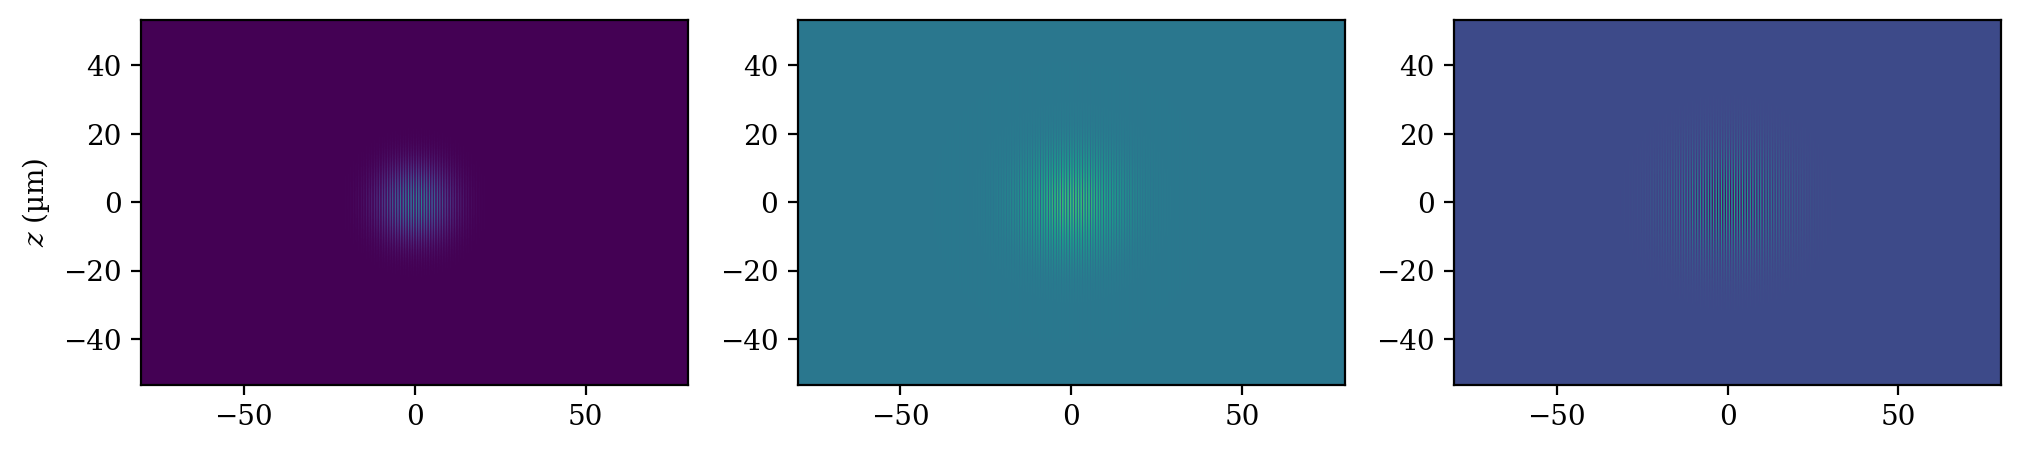

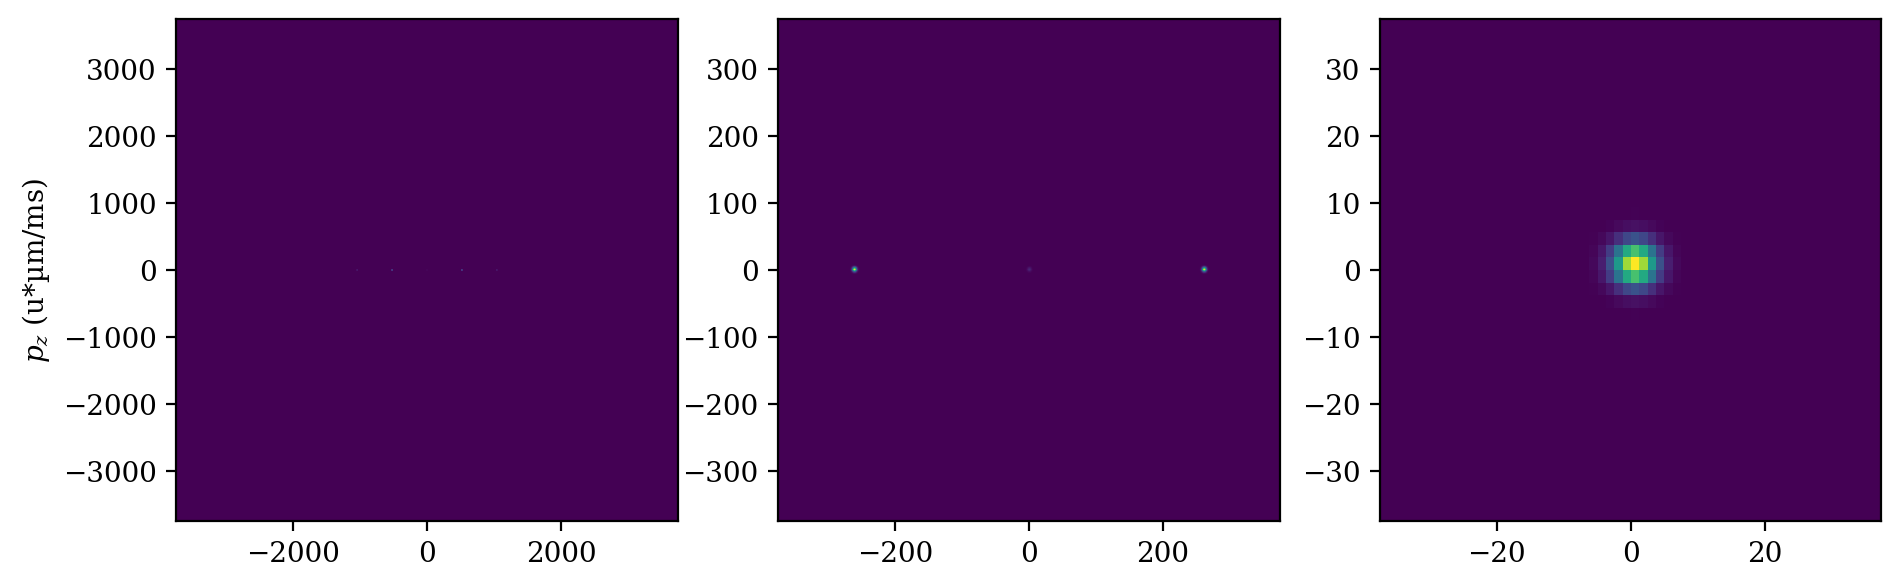

time = 1.45 µs
0.9999999999999505 |psi|^2


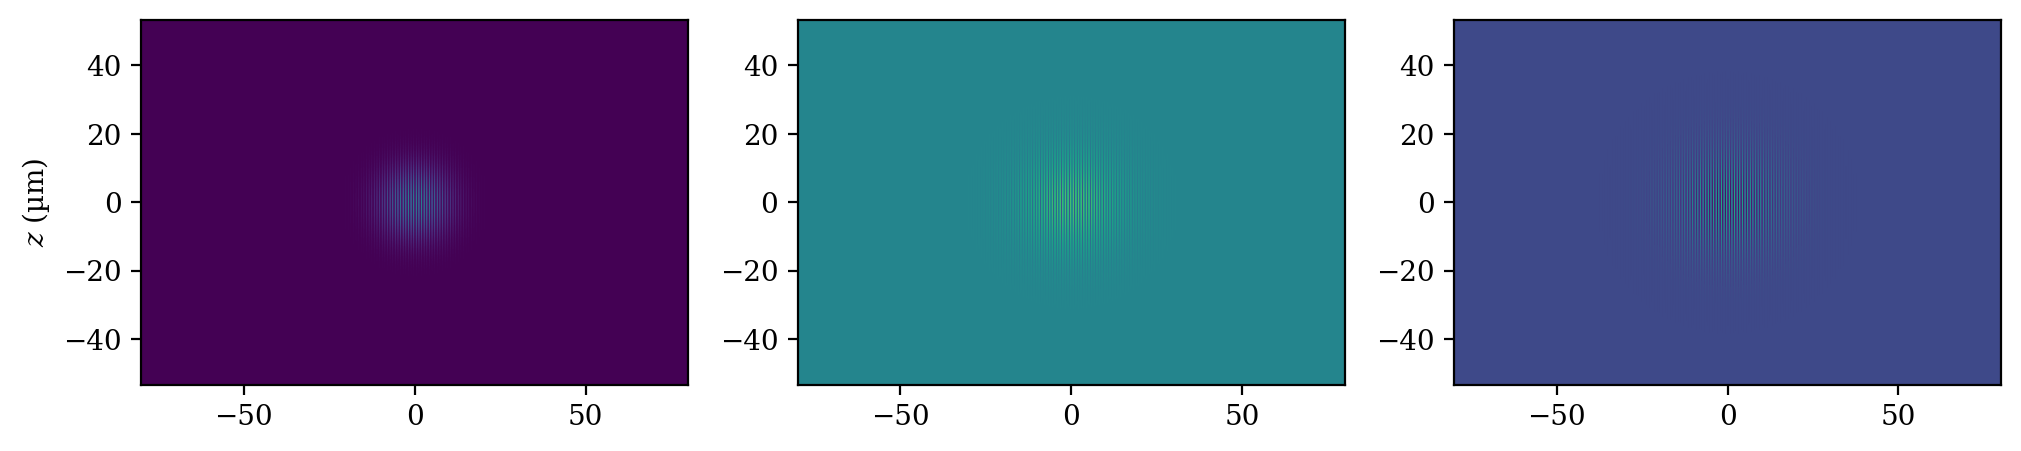

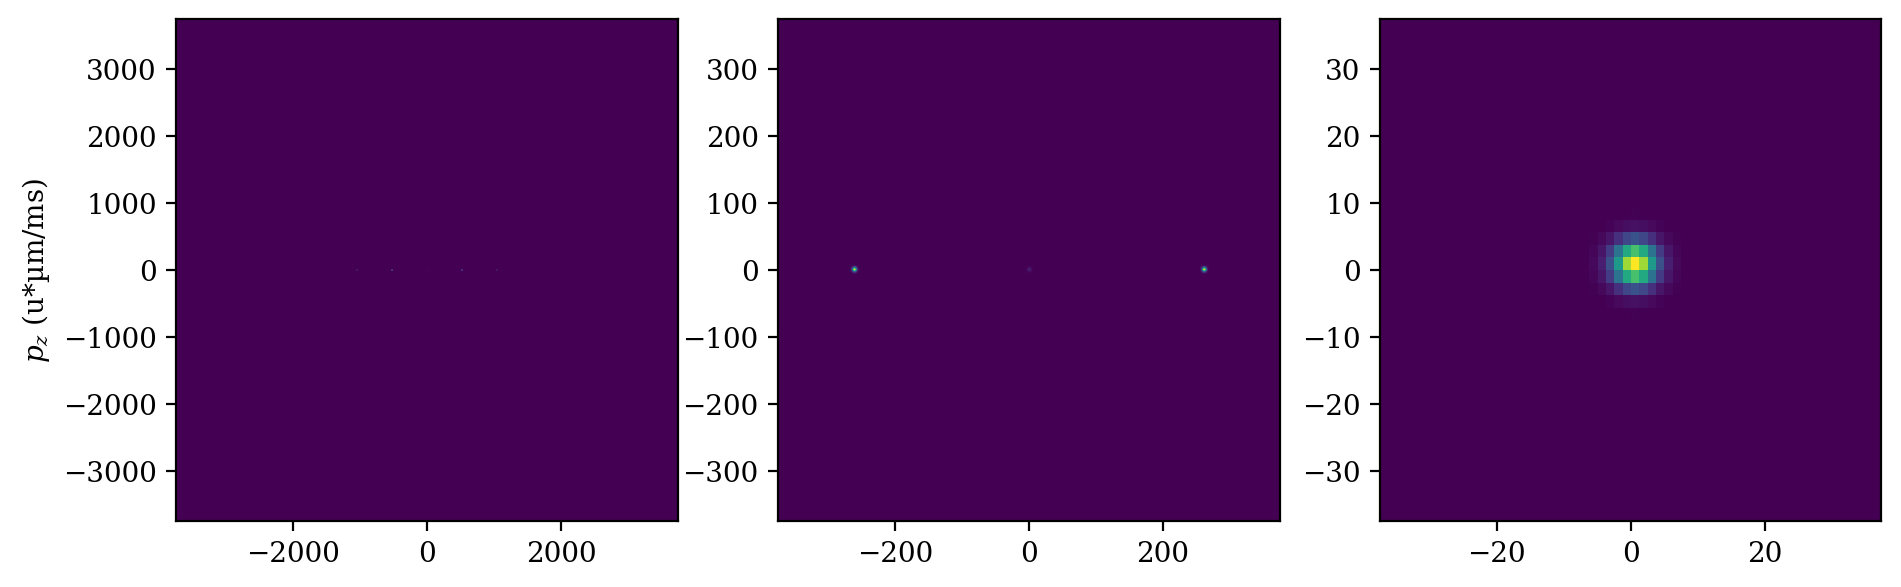

time = 1.5 µs
0.9999999999999505 |psi|^2


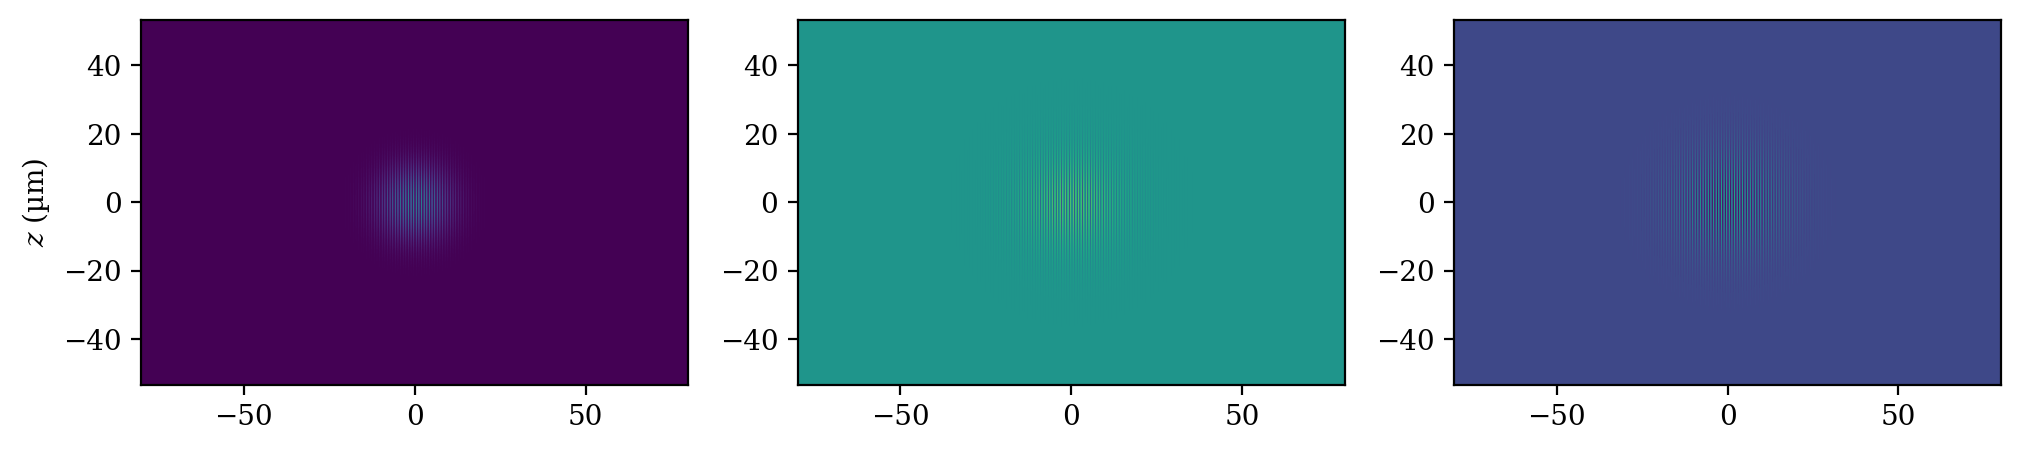

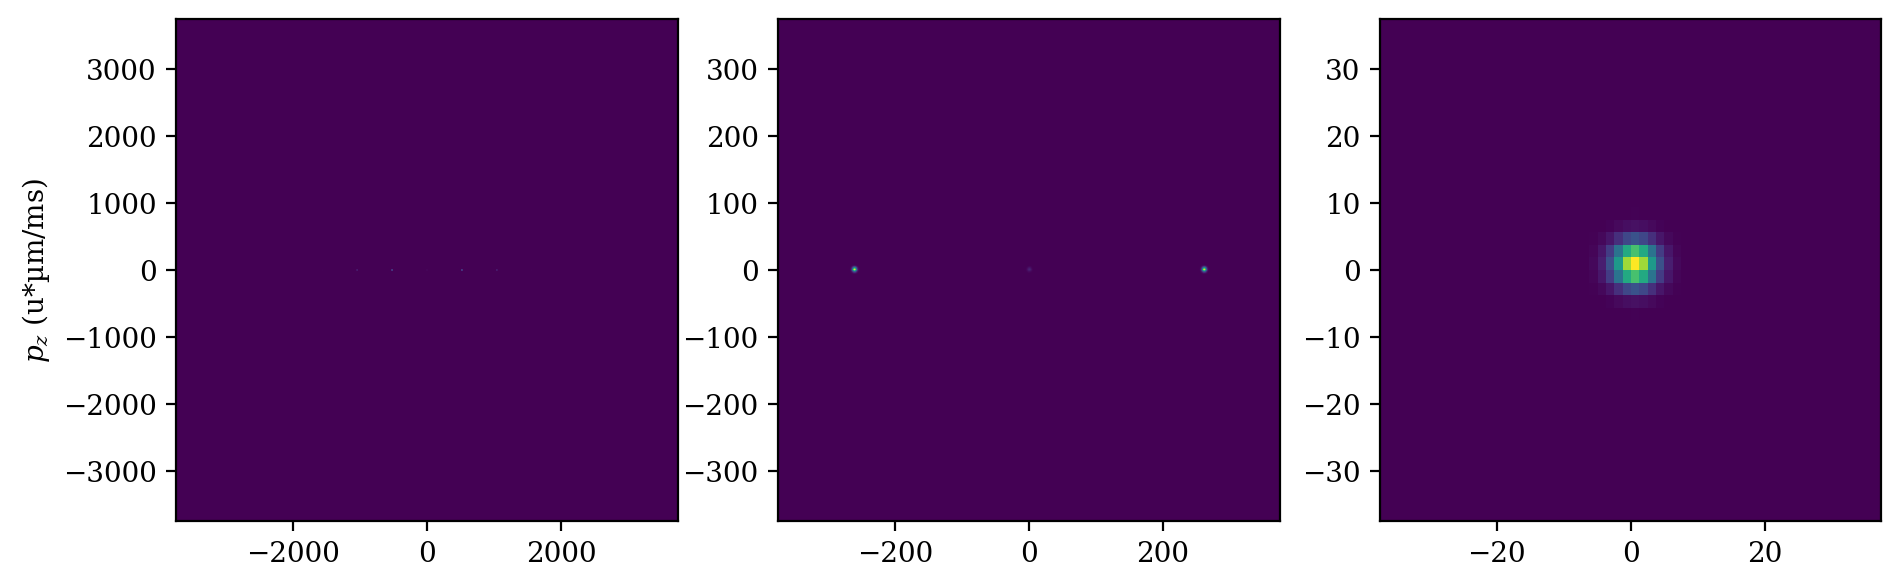

time = 1.55 µs
0.9999999999999504 |psi|^2


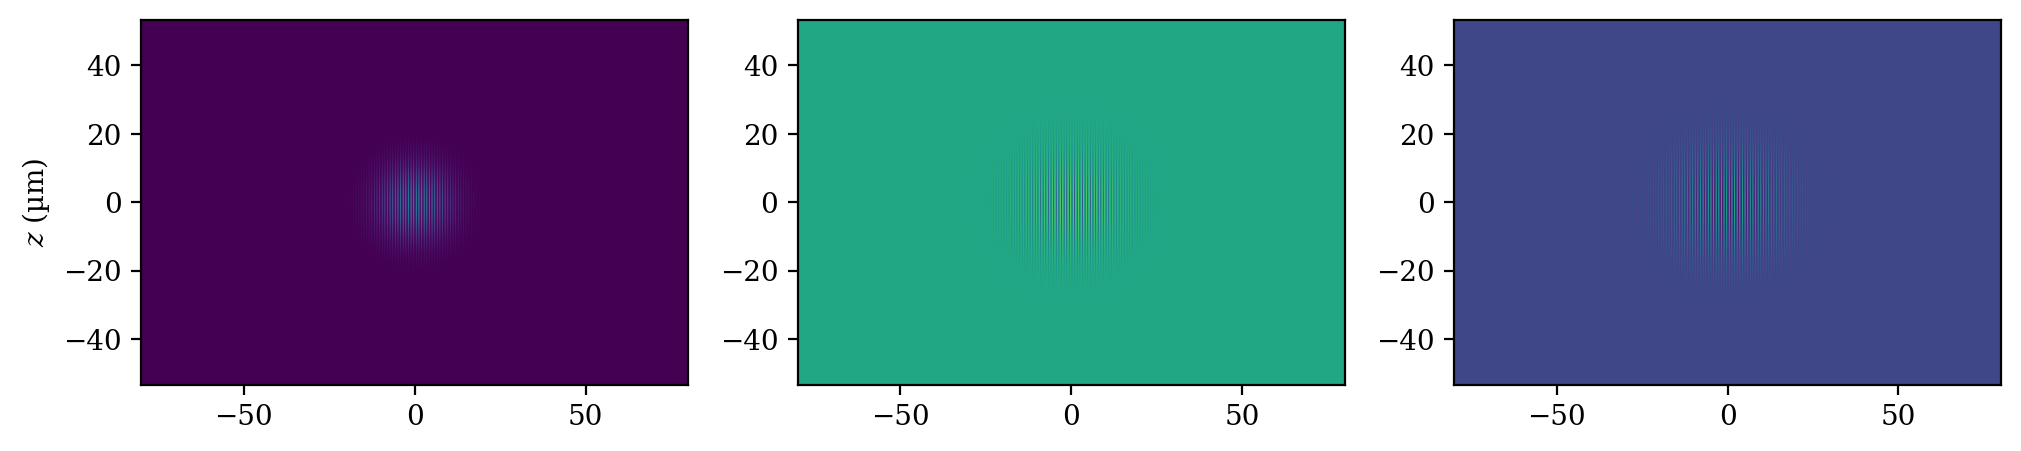

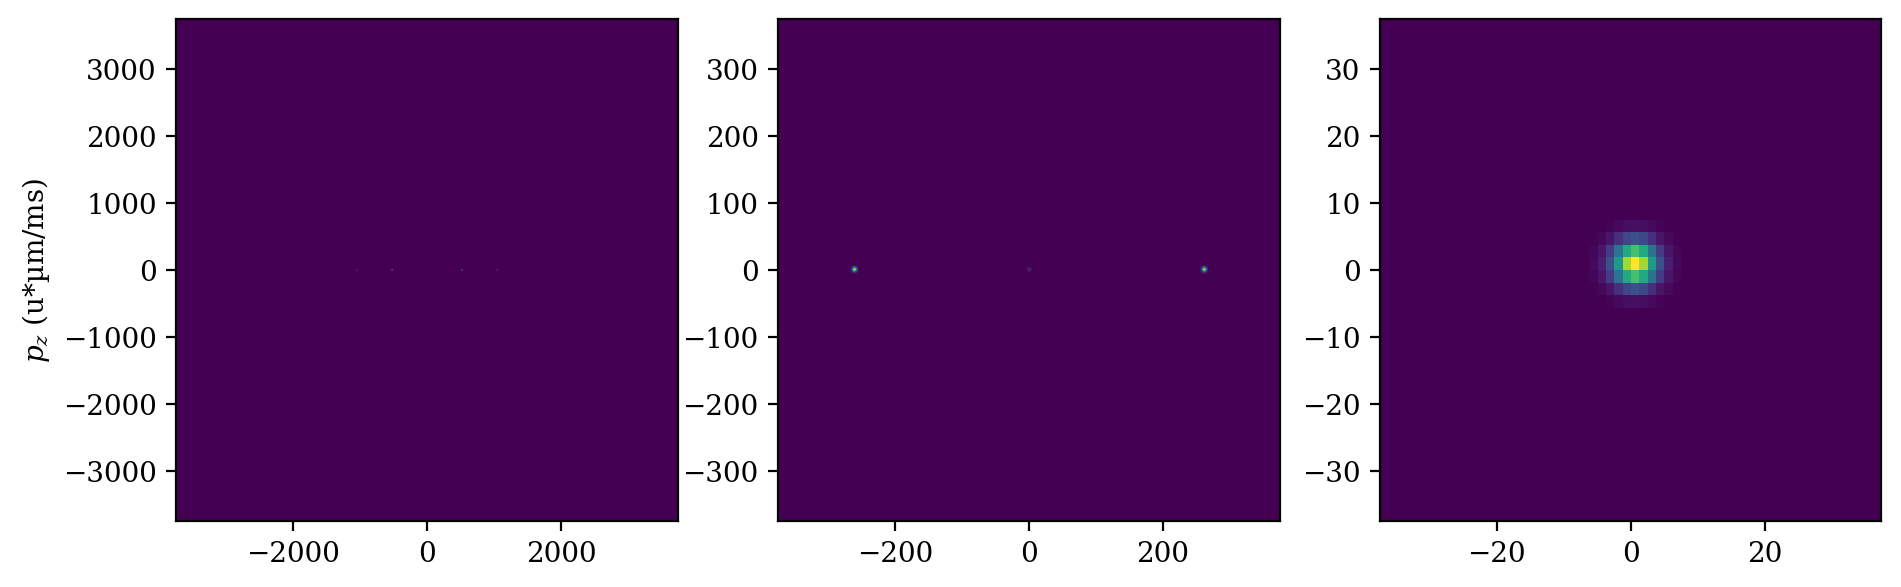

time = 1.6 µs
0.99999999999995 |psi|^2


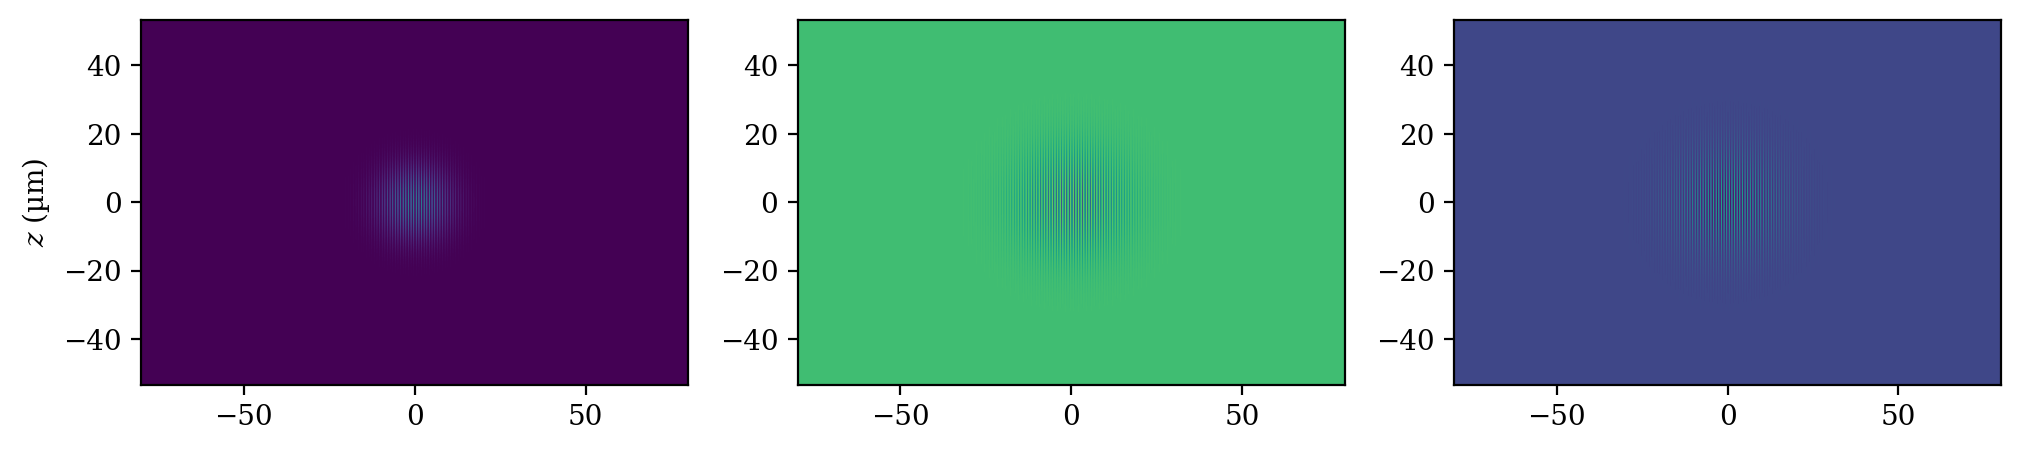

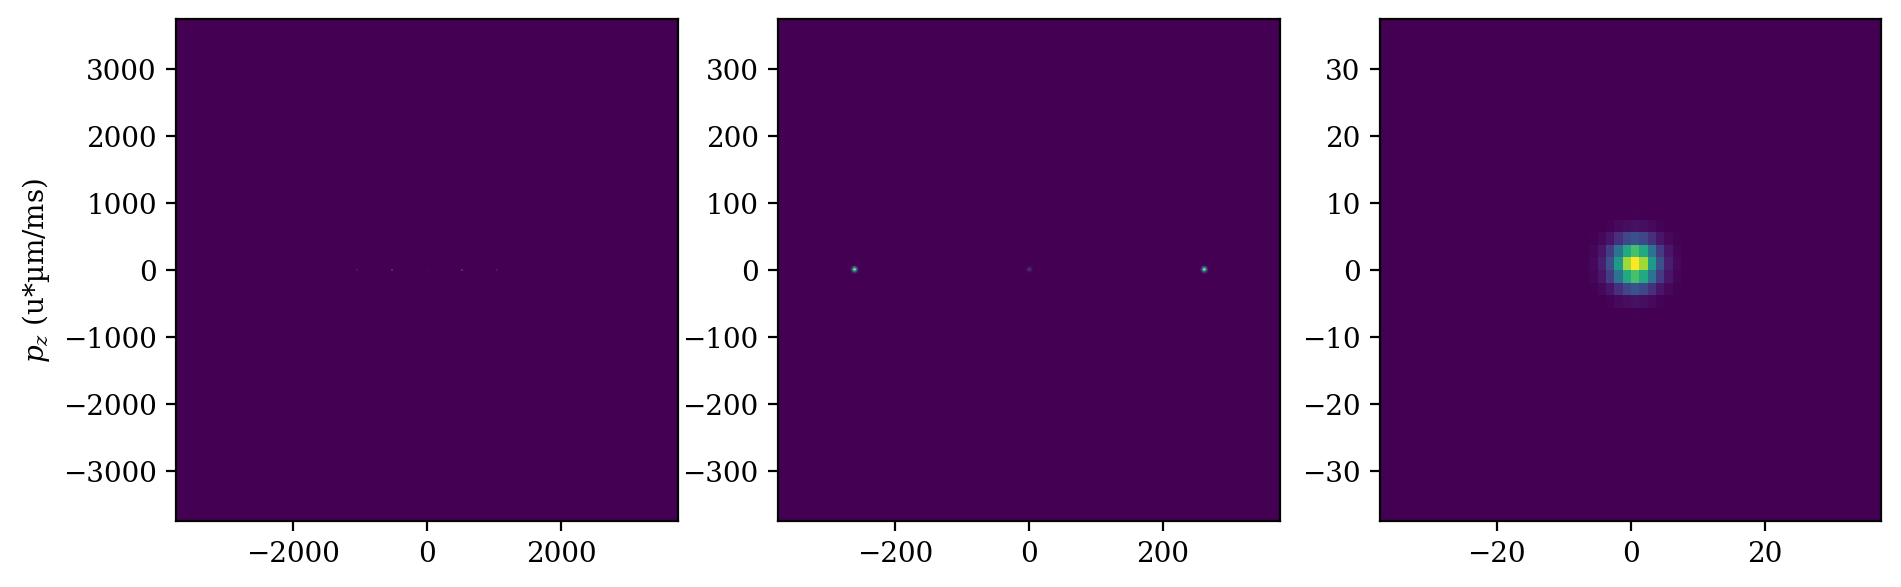

time = 1.65 µs
0.99999999999995 |psi|^2


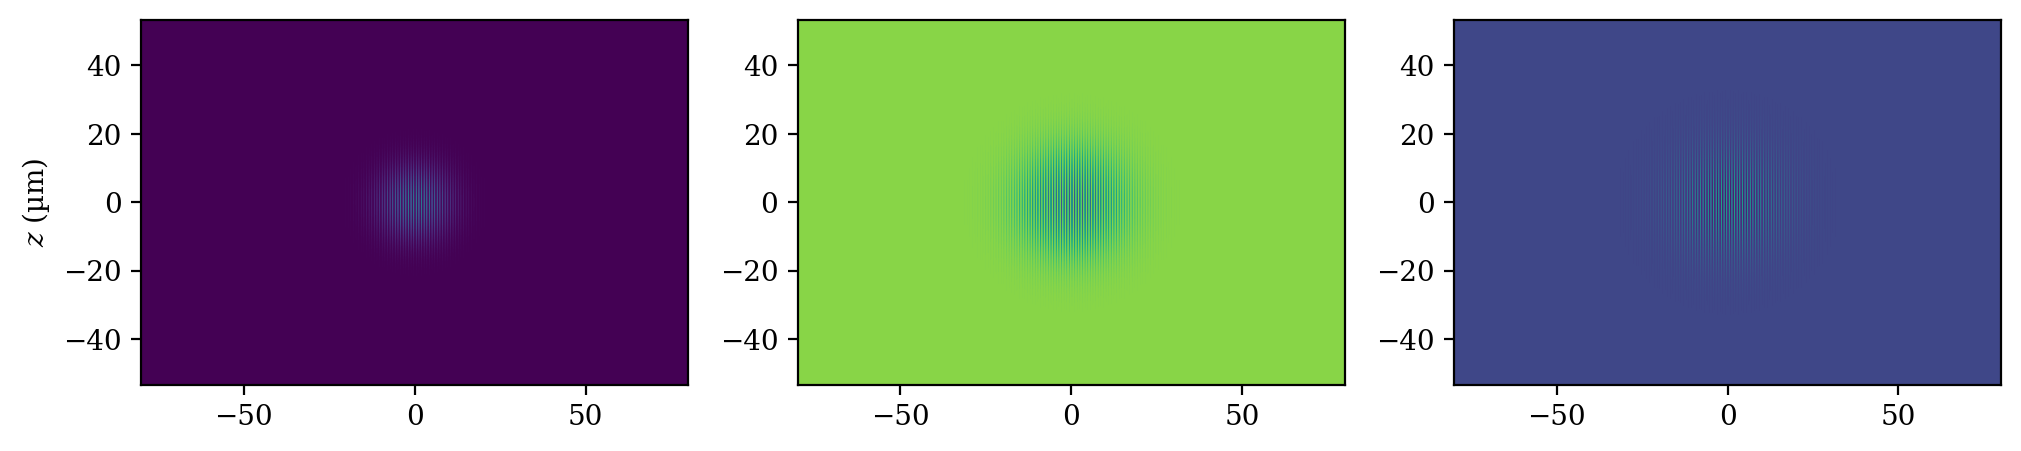

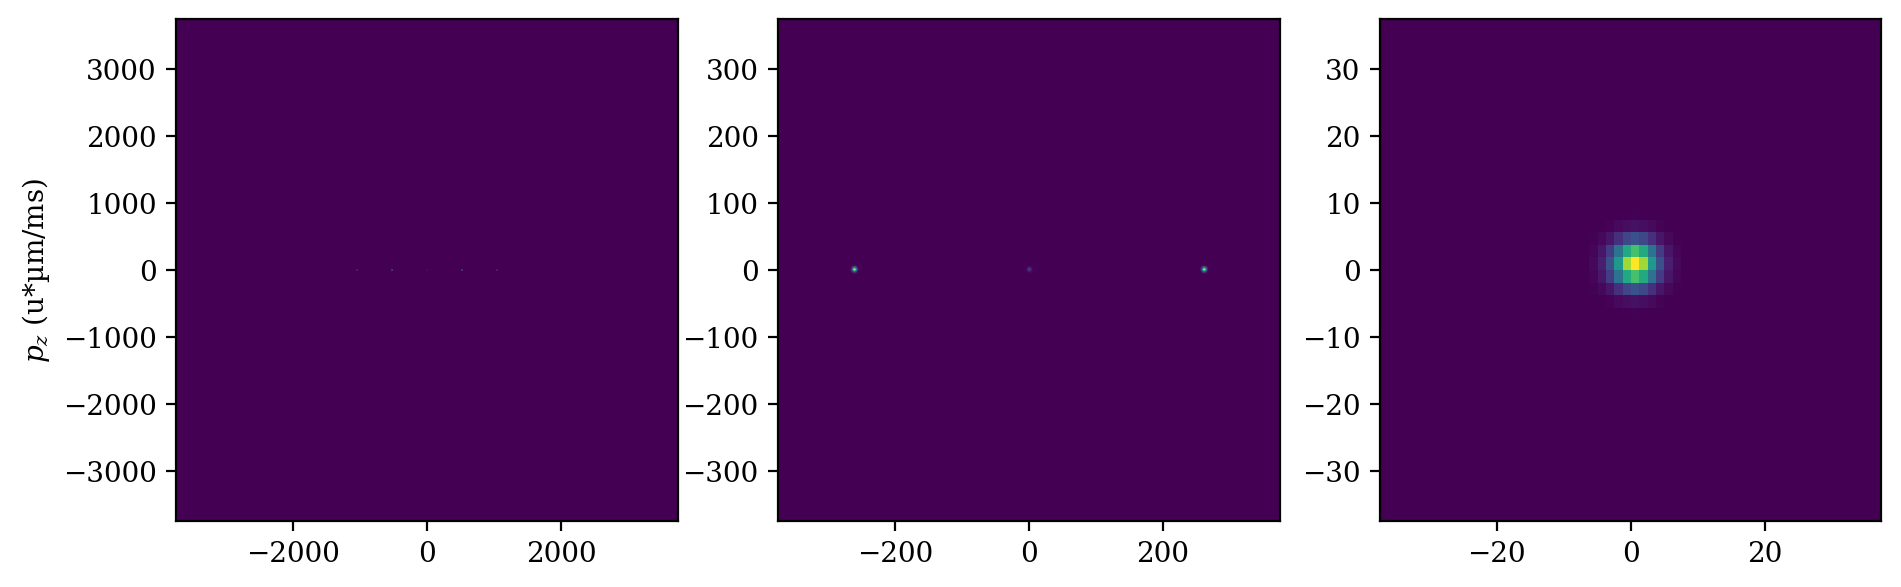

time = 1.7 µs
0.9999999999999498 |psi|^2


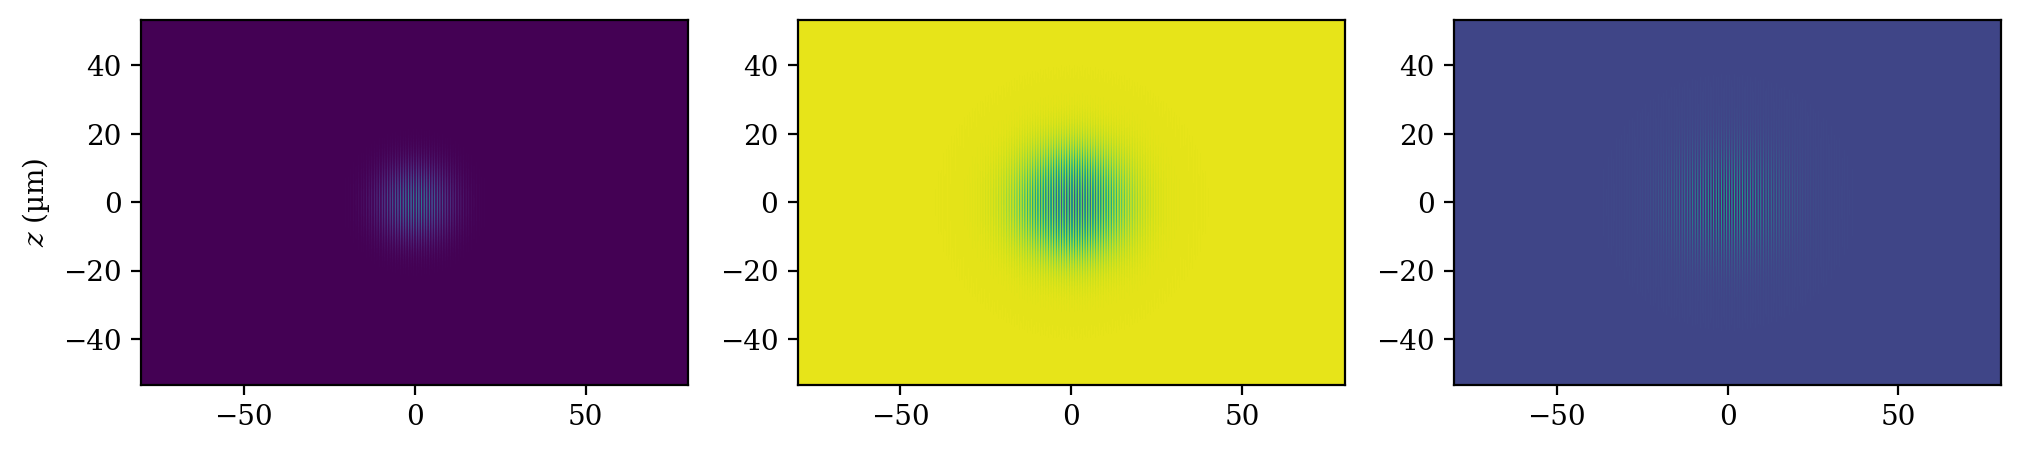

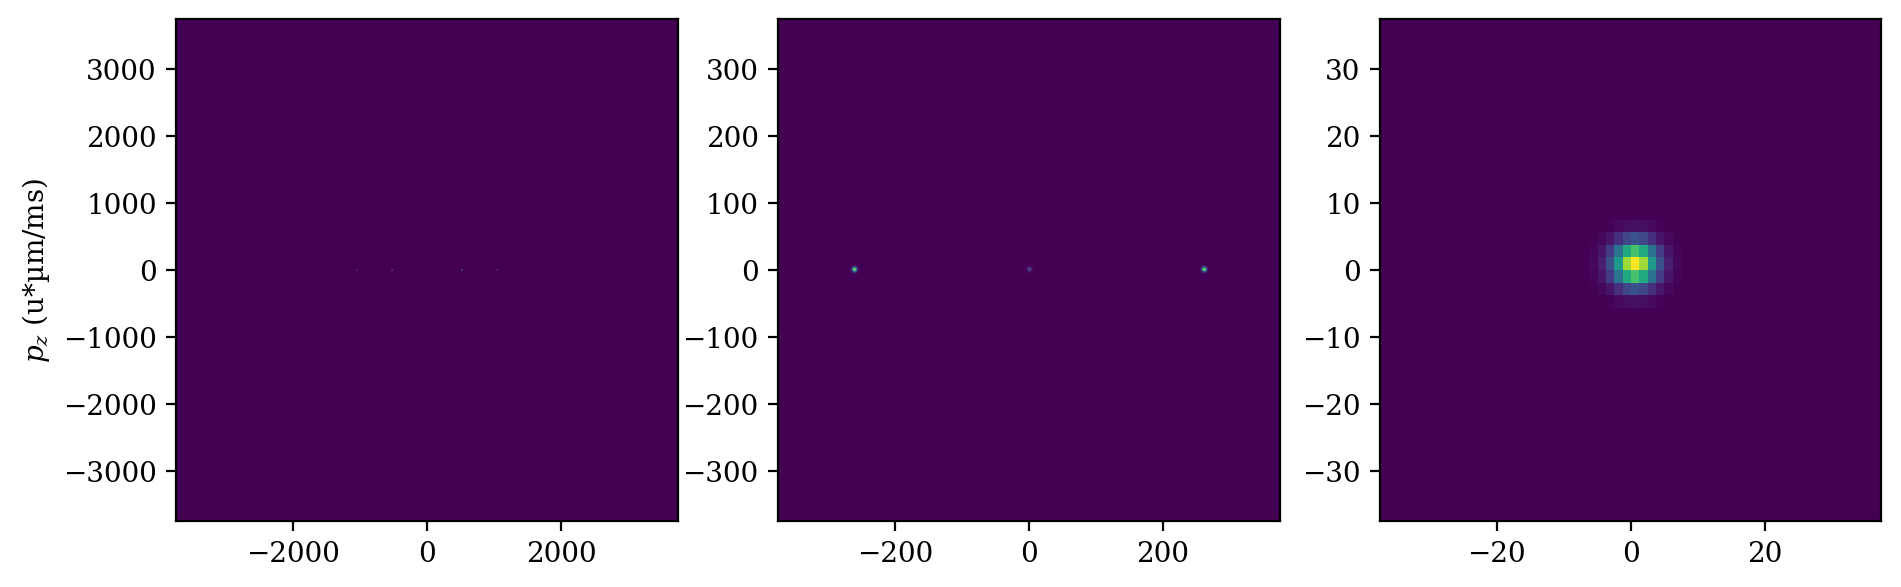

time = 1.75 µs
0.9999999999999494 |psi|^2


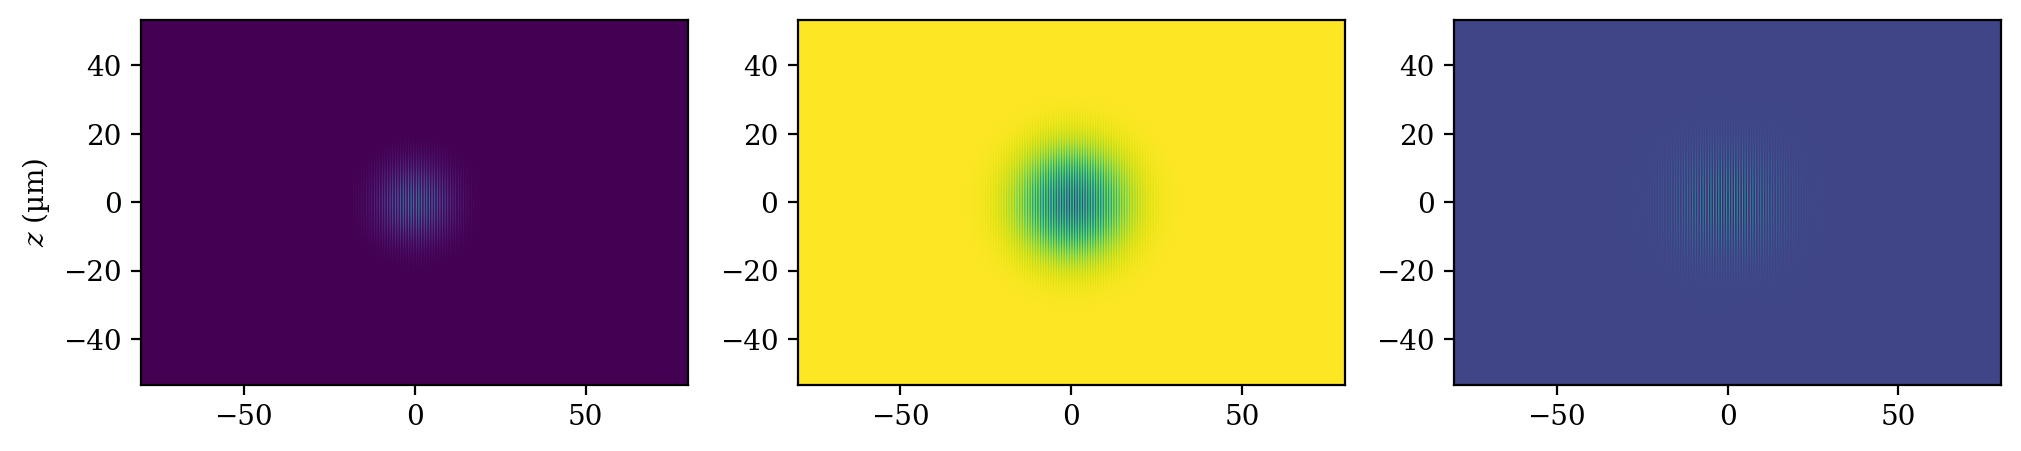

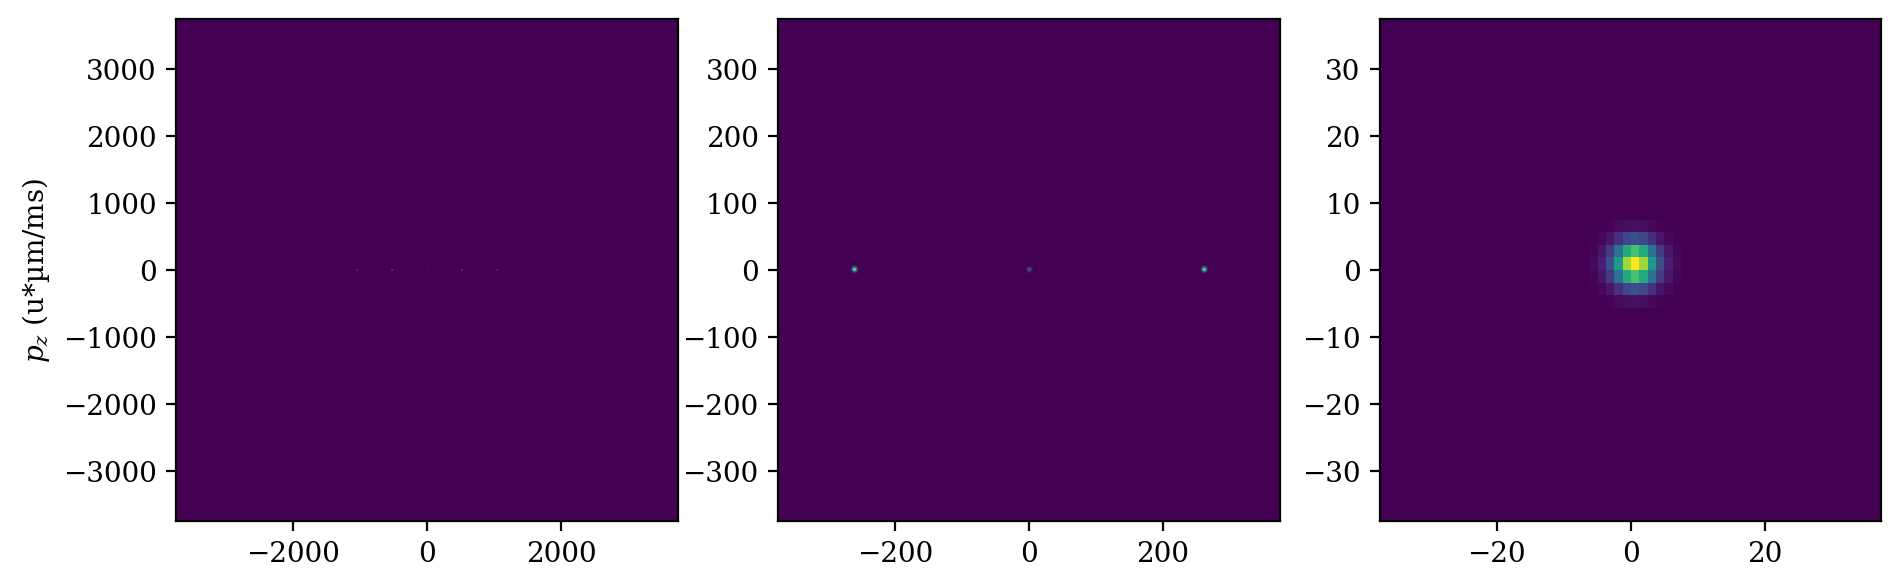

time = 1.8 µs
0.9999999999999489 |psi|^2


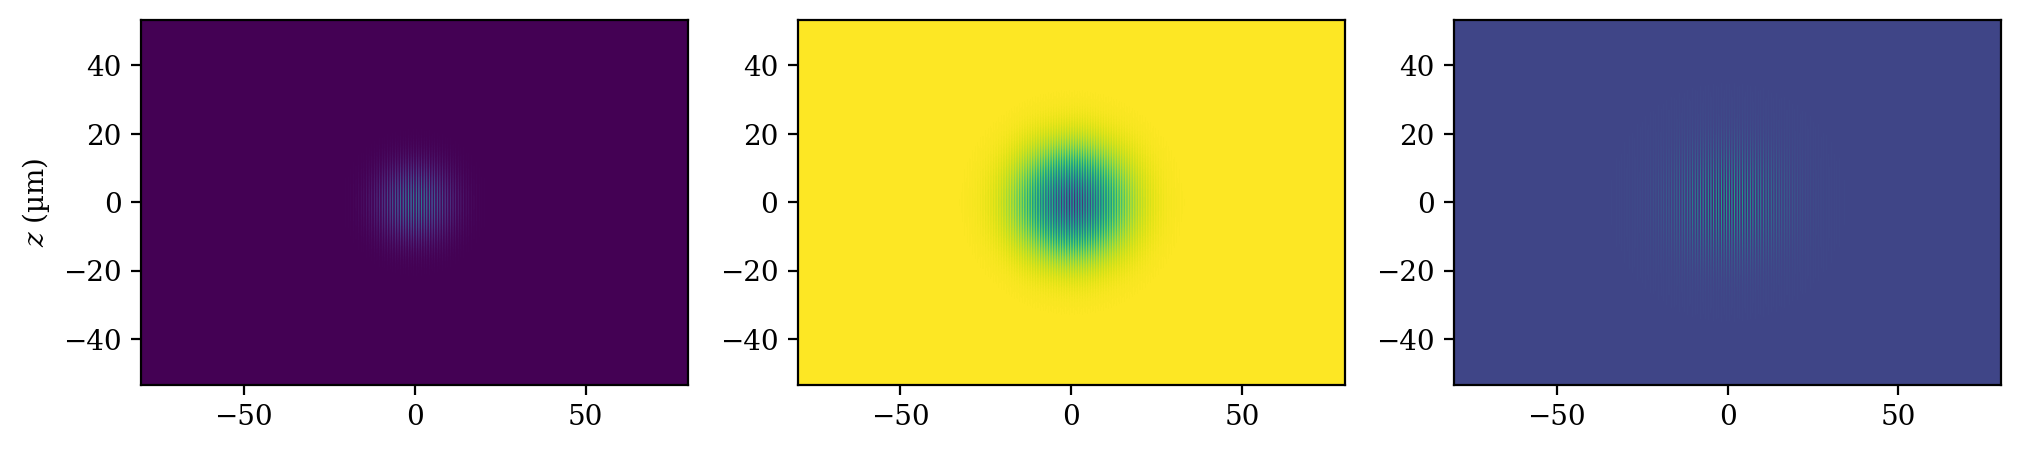

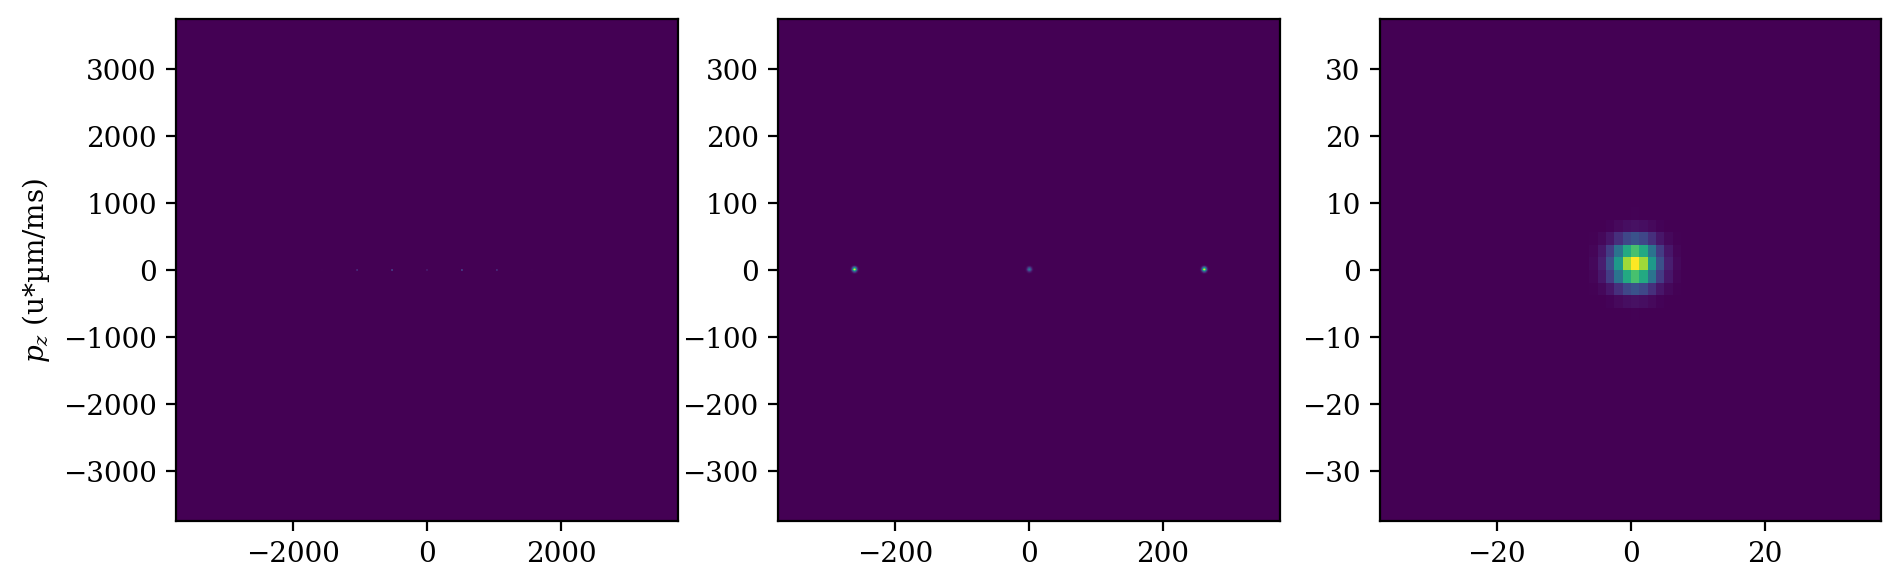

time = 1.85 µs
0.9999999999999487 |psi|^2


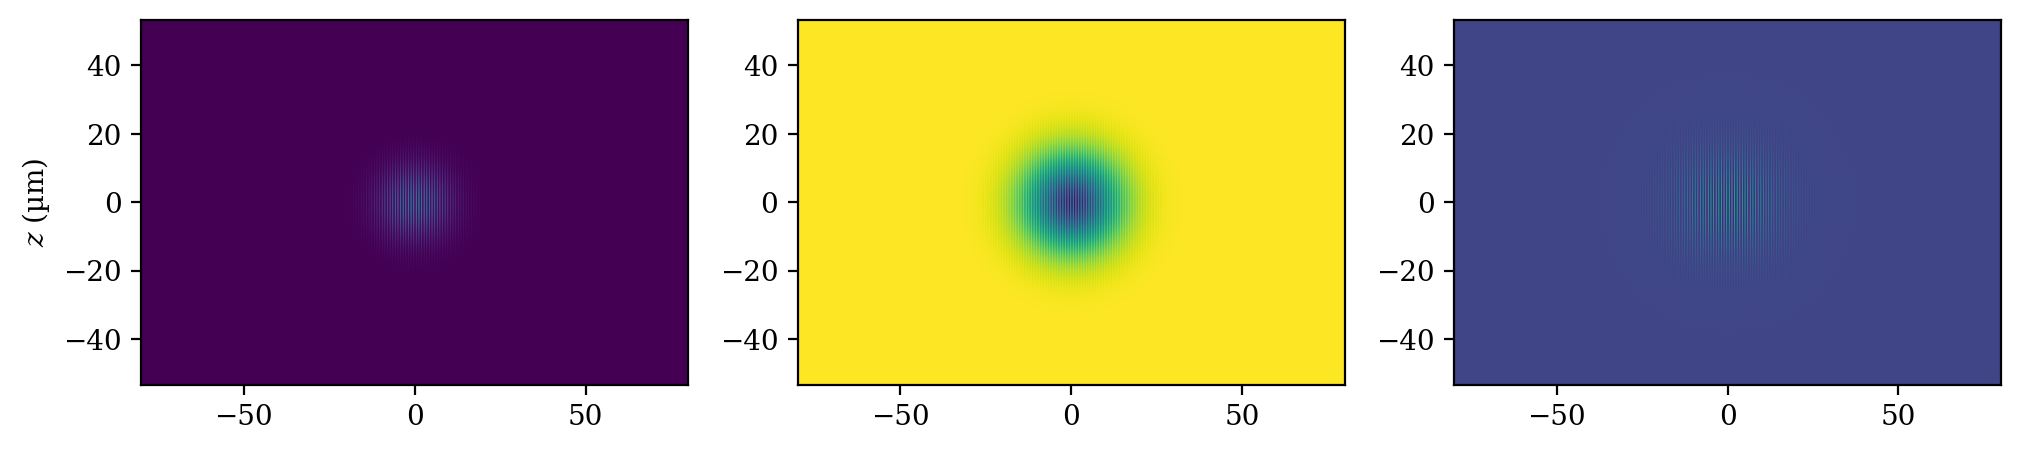

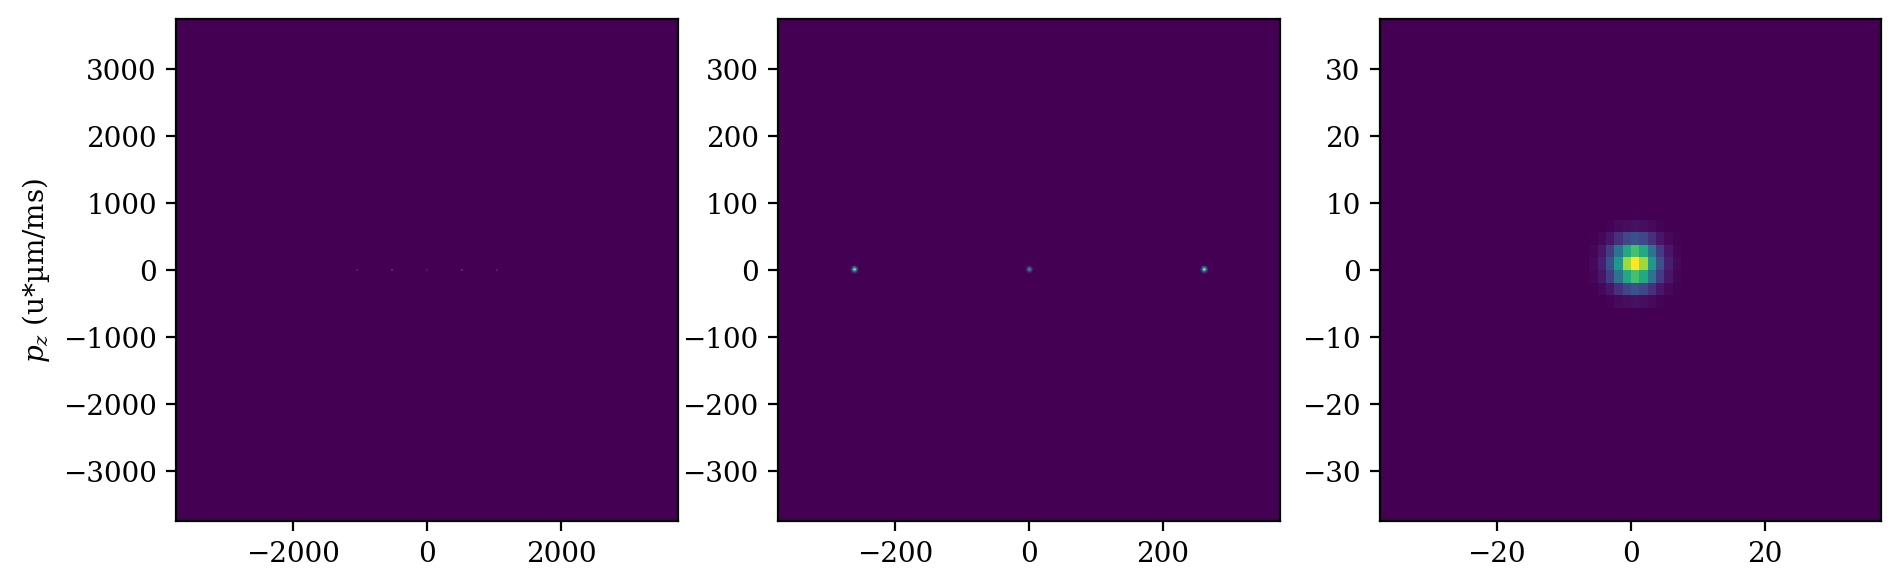

time = 1.9 µs
0.9999999999999484 |psi|^2


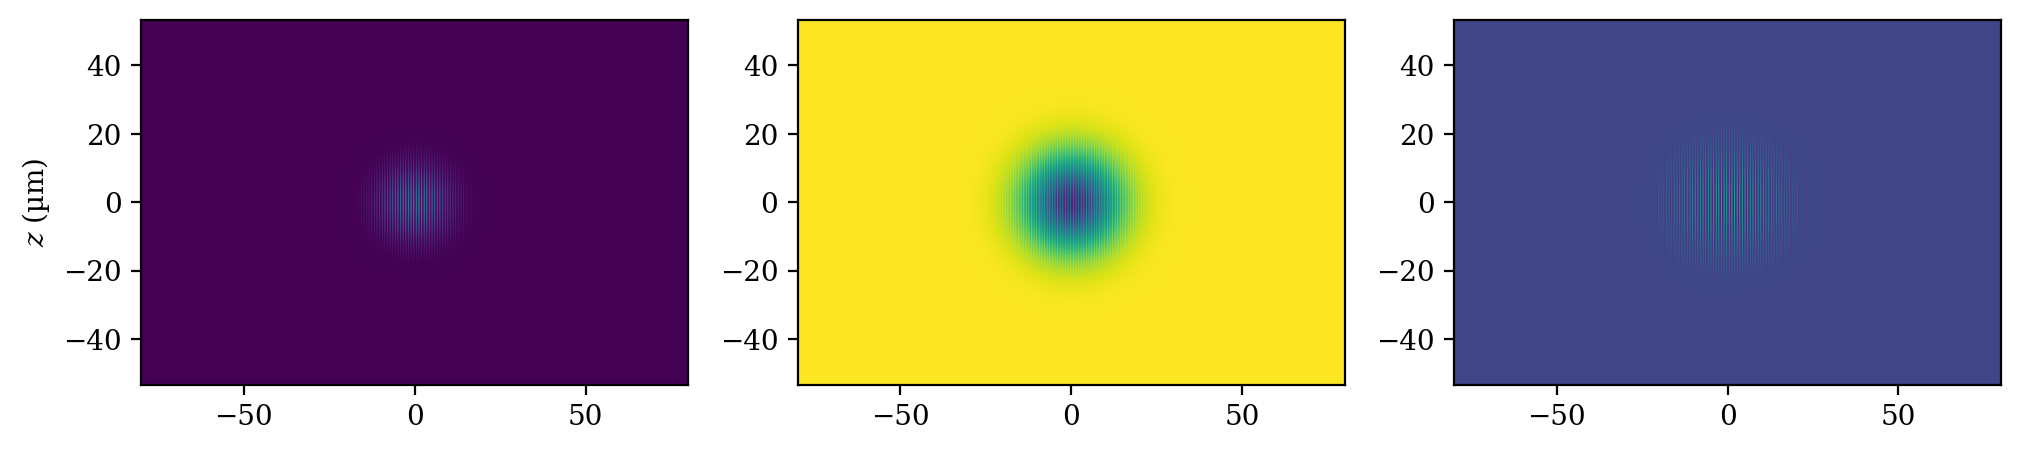

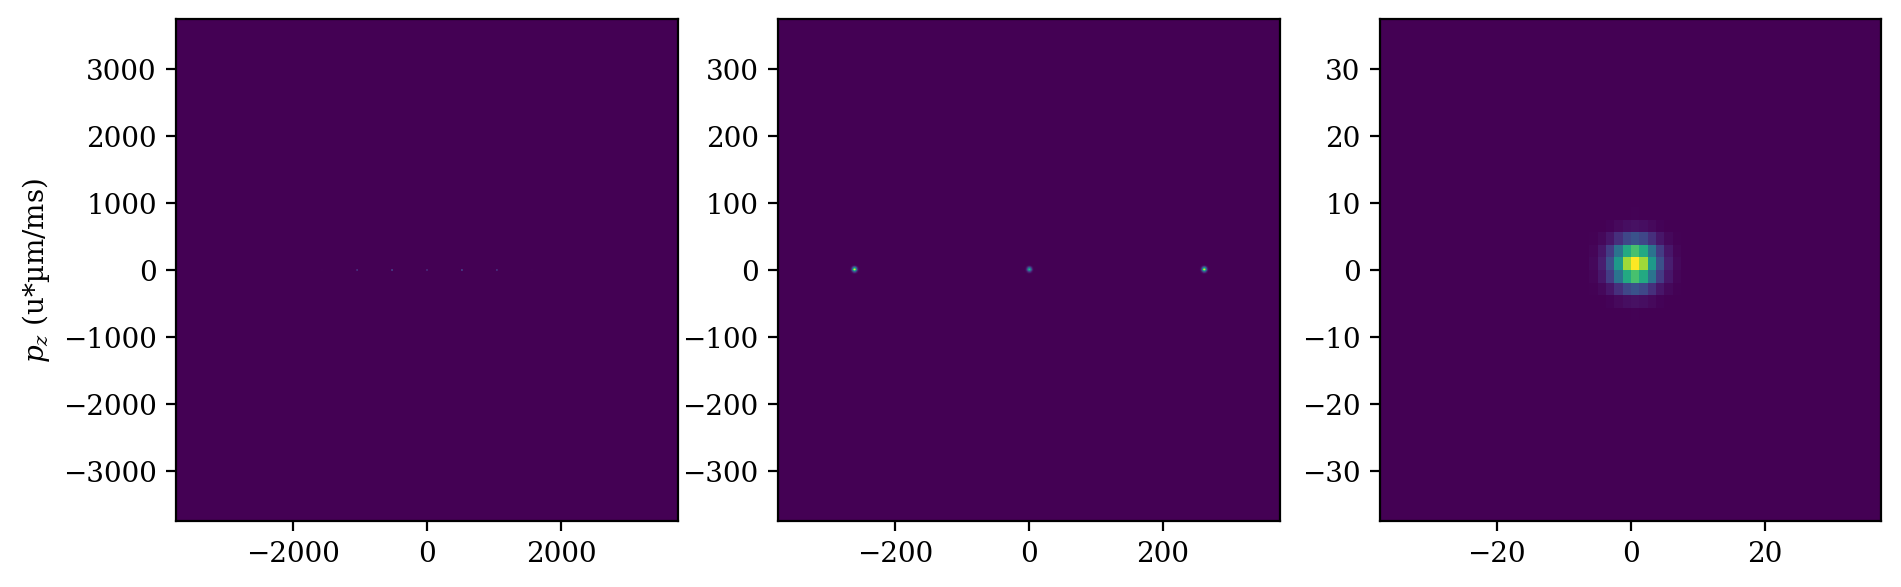

time = 1.95 µs
0.9999999999999478 |psi|^2


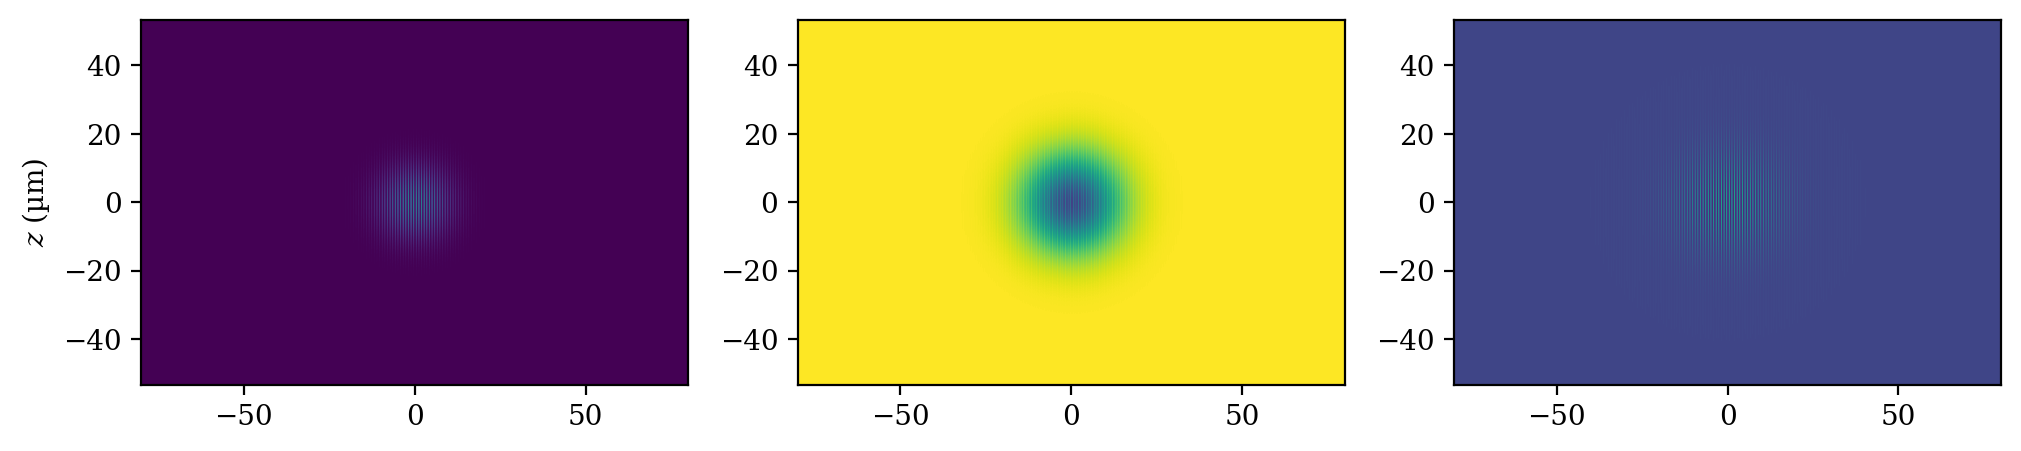

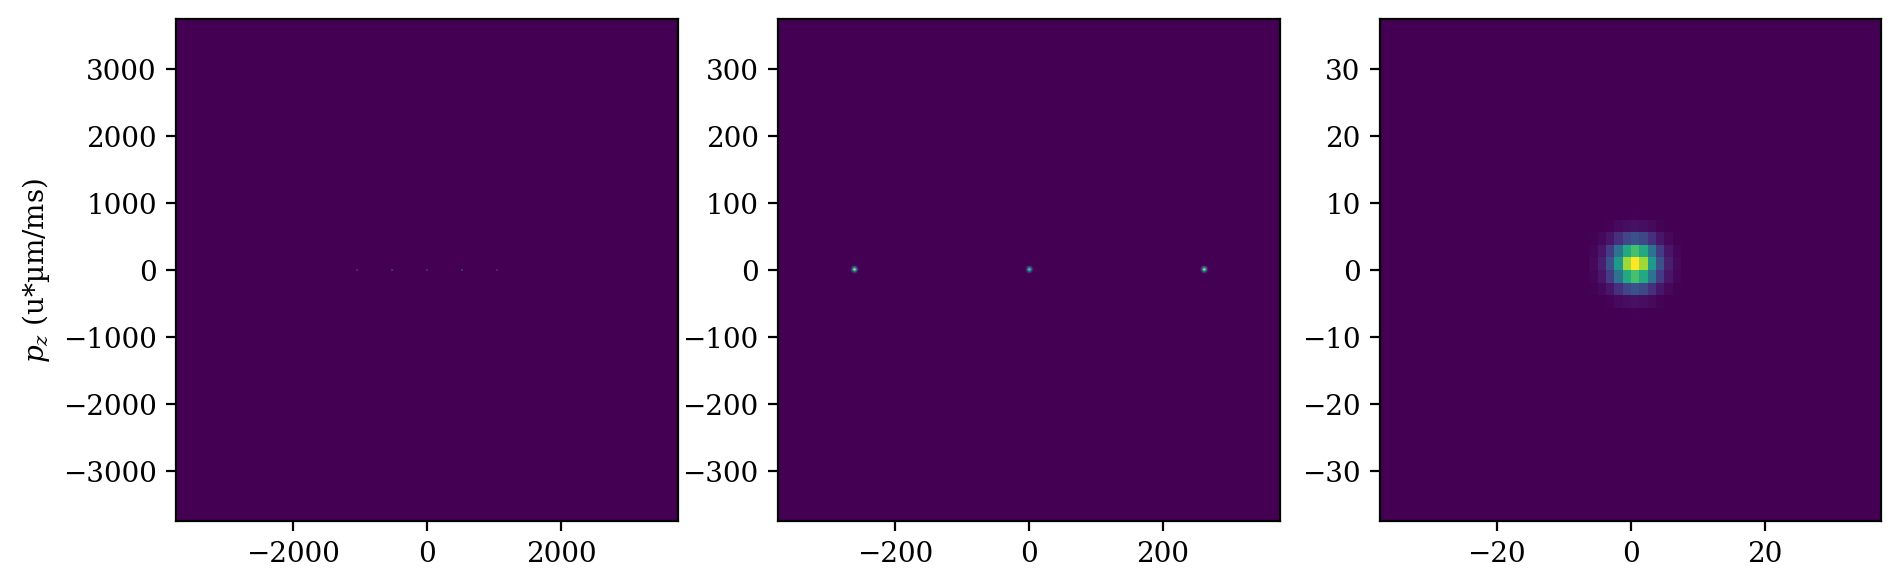

time = 2.0 µs
0.9999999999999474 |psi|^2


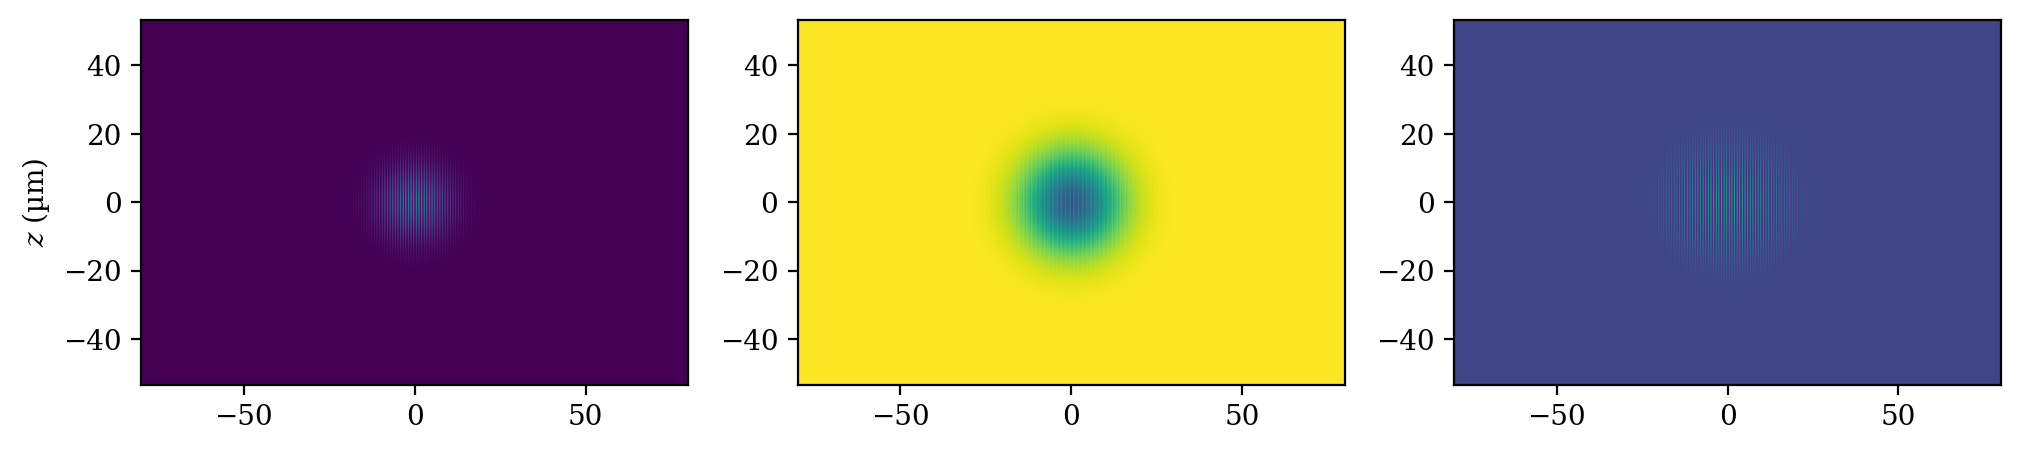

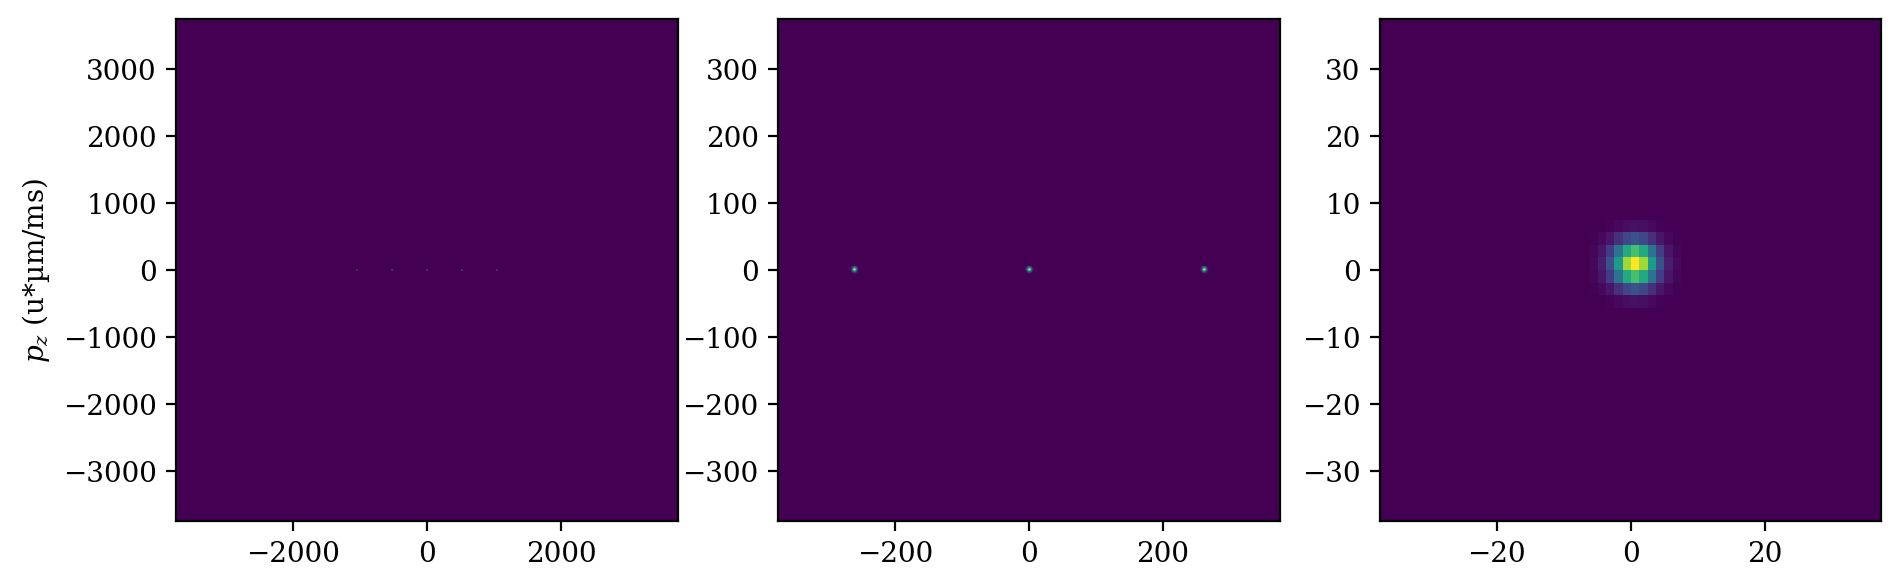

time = 2.05 µs
0.9999999999999467 |psi|^2


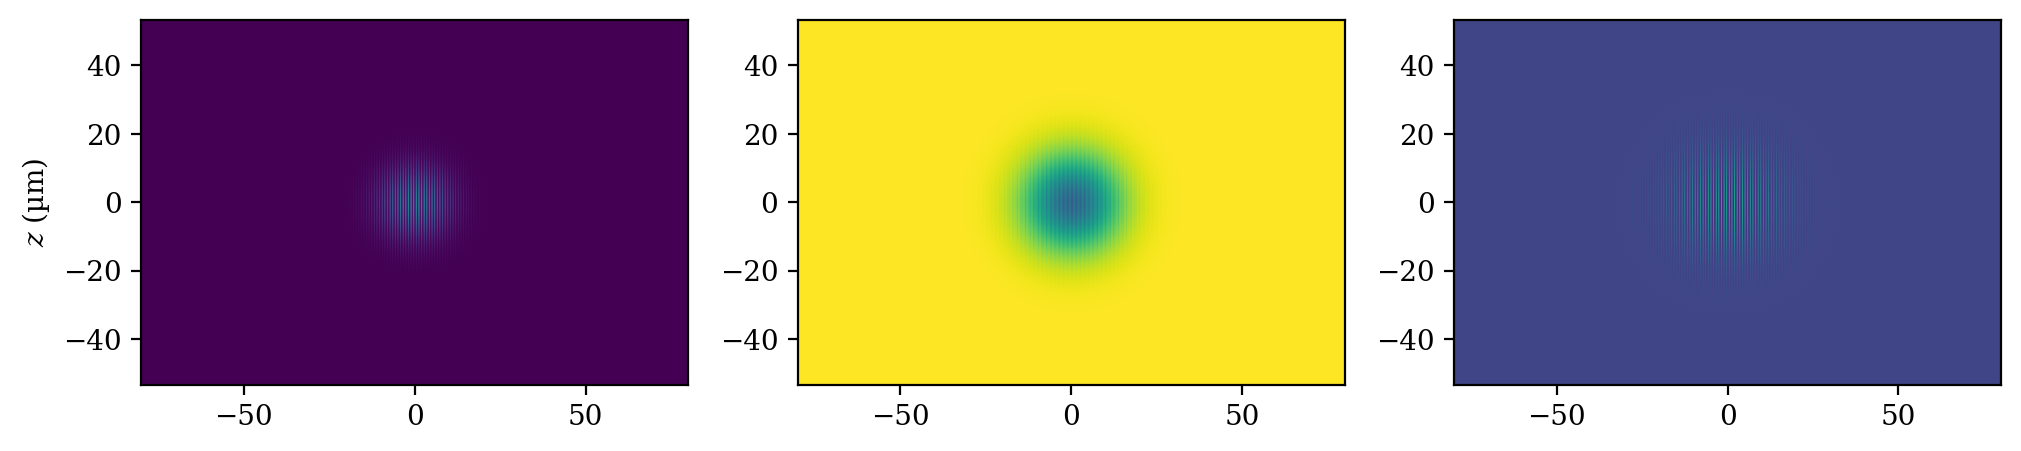

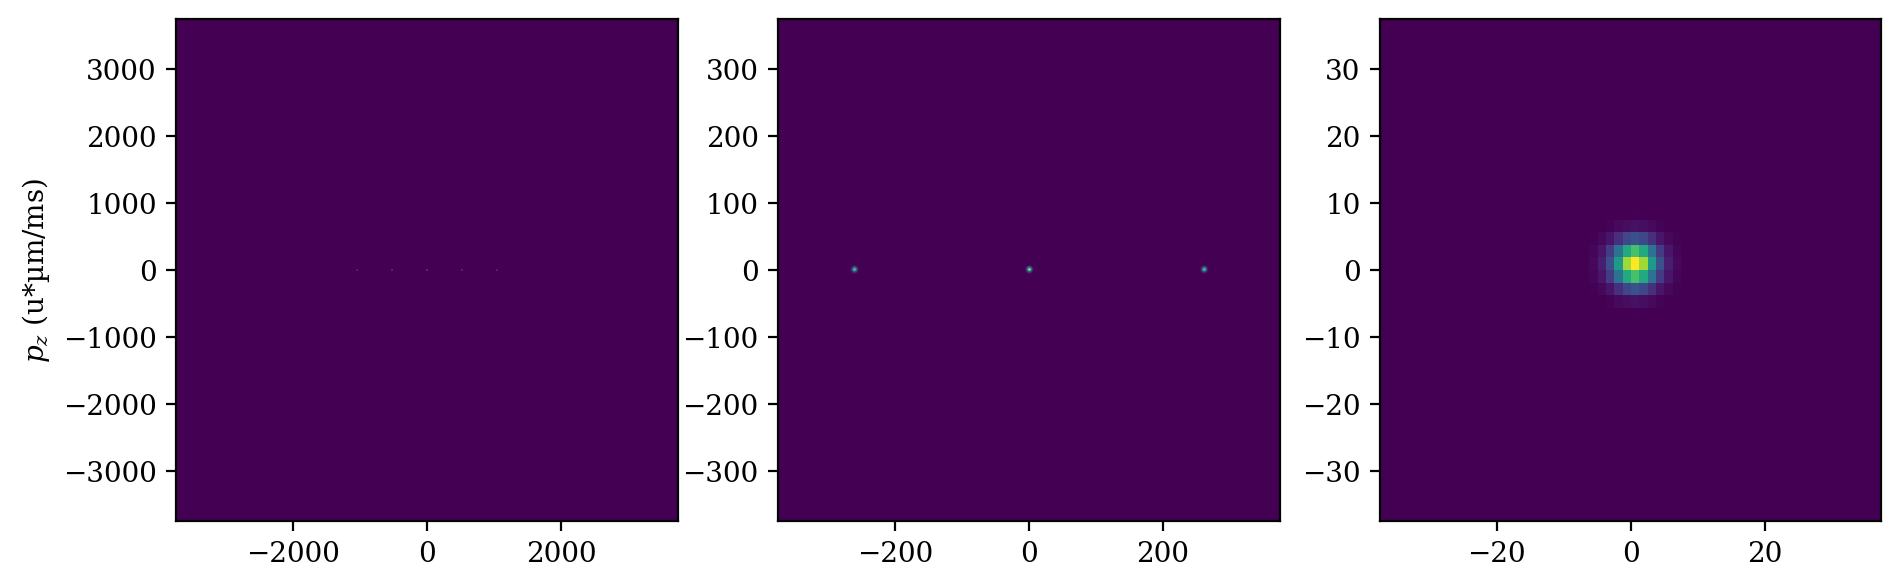

time = 2.1 µs
0.9999999999999465 |psi|^2


KeyboardInterrupt: 

In [635]:
# @njit(parallel=True)
for step in tqdm(range(500)):
    psi *= VxExpGrid
    phi = np.fliplr(np.fft.fftshift(pyfftw.interfaces.numpy_fft.fft2(psi,threads=nthreads)))
    phi *= expPGrid
    psi = pyfftw.interfaces.numpy_fft.ifft2(np.fft.ifftshift(np.fliplr(phi)),threads=nthreads)
    psi *= VxExpGrid
    
    if step % 5 == 0:
        print("time =", round(t*1000,4), "µs")
        print(np.trapz(np.trapz(np.abs(psi)**2,xlin,axis=0),zlin),"|psi|^2")
        plot_psi(psi)
        plot_mom(psi)
    
    t += dt

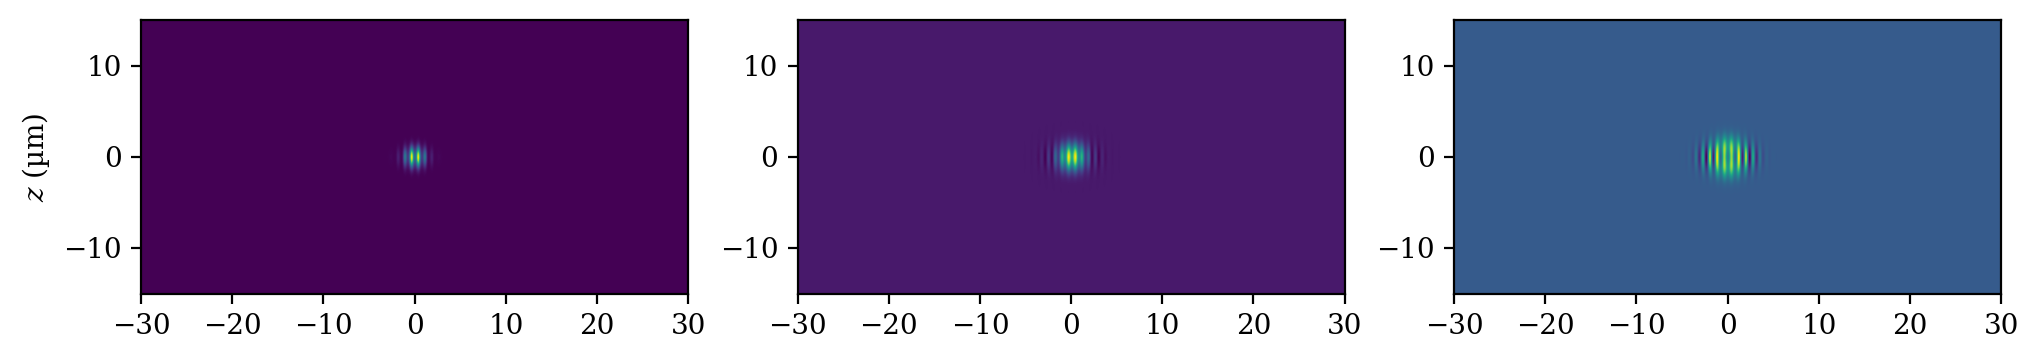

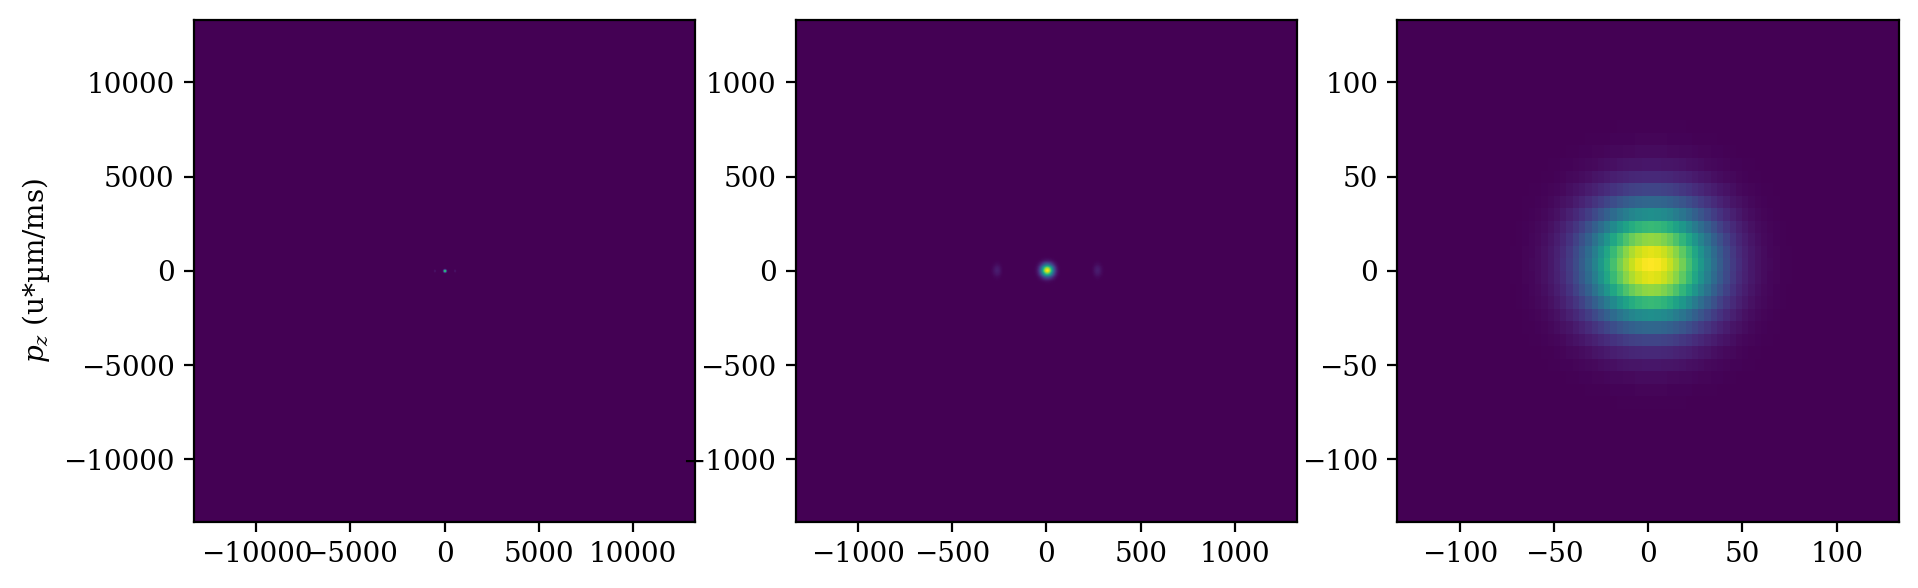

In [341]:
plot_psi(psi)
plot_mom(psi)

In [311]:
# for step in range(3000):
# #     psi *= VxExpGrid
#     phi = np.fliplr(np.fft.fftshift(pyfftw.interfaces.numpy_fft.fft2(psi)))
#     phi *= expPGrid
#     psi = pyfftw.interfaces.numpy_fft.ifft2(np.fft.ifftshift(np.fliplr(phi)))
# #     psi *= VxExpGrid
#     t += dt
#     if step % 200 == 0:
#         print("time =", round(t*1000,4), "µs")
#         print(np.trapz(np.trapz(np.abs(psi)**2,xlin,axis=0),zlin),"|psi|^2")
#         plot_psi(psi)
#         plot_mom(psi)

# Use propagator

In [343]:
def testDuration(t=0.001*15):
    steps = int(t/dt)
    print("duration tau =",t, ", steps =", steps, ", dt =",dt)
    psi = psi0np(2,2,0,0)
    t = 0    
    for i in tqdm(range(steps)):
        psi *= VxExpGrid
        phi = np.fliplr(np.fft.fftshift(pyfftw.interfaces.numpy_fft.fft2(psi,threads=nthreads)))
        phi *= expPGrid
        psi = pyfftw.interfaces.numpy_fft.ifft2(np.fft.ifftshift(np.fliplr(phi)),threads=nthreads)
        psi *= VxExpGrid
        t += dt
    plot_psi(psi)
    plot_mom(psi)
    return (t,psi)

In [345]:
# (t,psi) = testDuration(0.001*15)

duration tau = 0.02 , steps = 200 , dt = 0.0001


  0%|          | 0/200 [00:00<?, ?it/s]

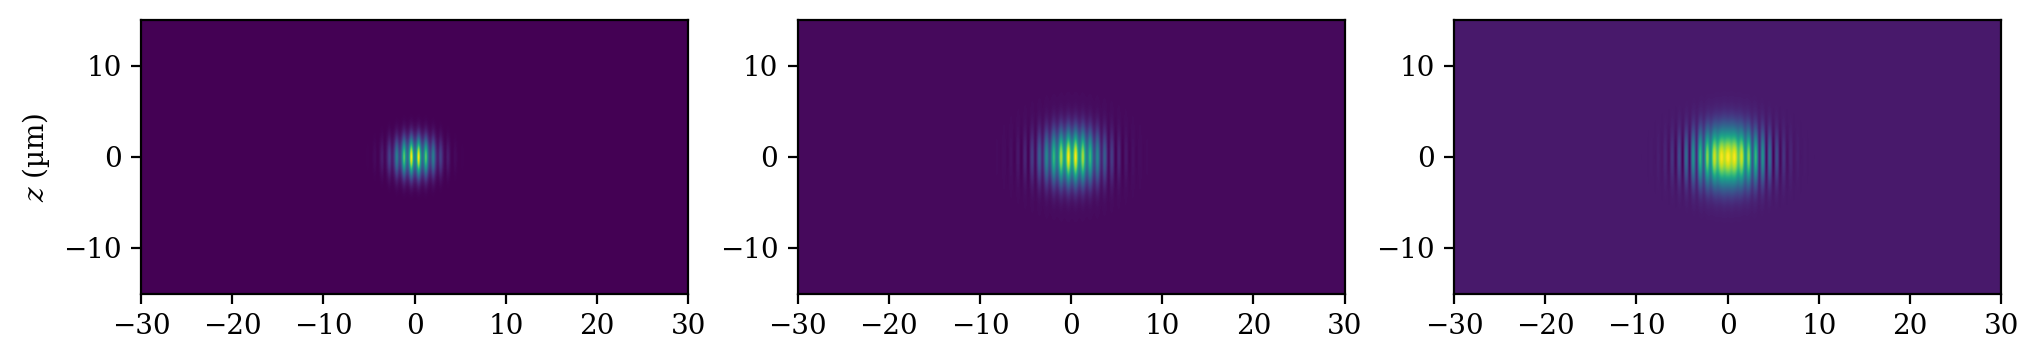

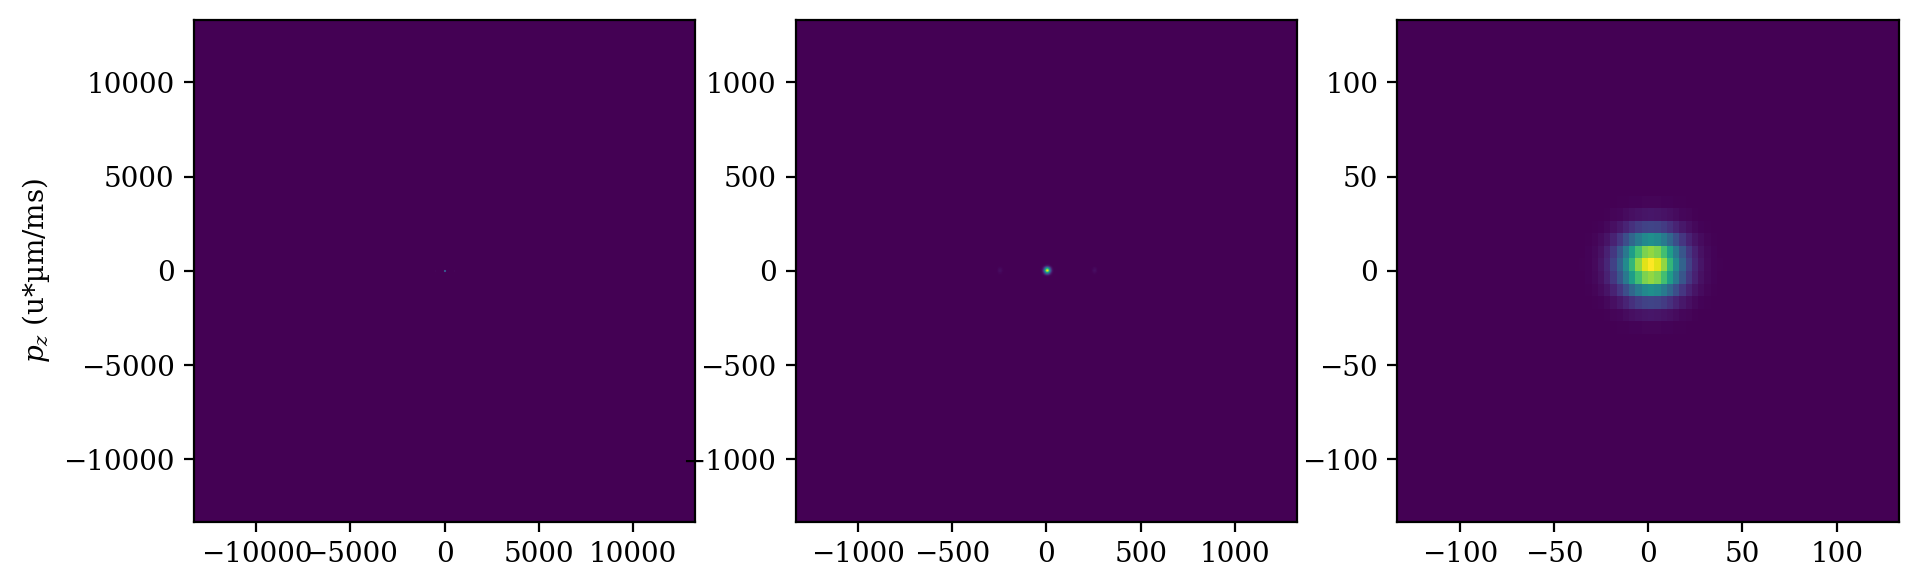

In [346]:
(t,psi) = testDuration(0.001*20)

In [342]:
2*hb*k

521.0668902307921

In [85]:
phi = np.fliplr(np.fft.fftshift(pyfftw.interfaces.numpy_fft.fft2(psi,threads=nthreads)))

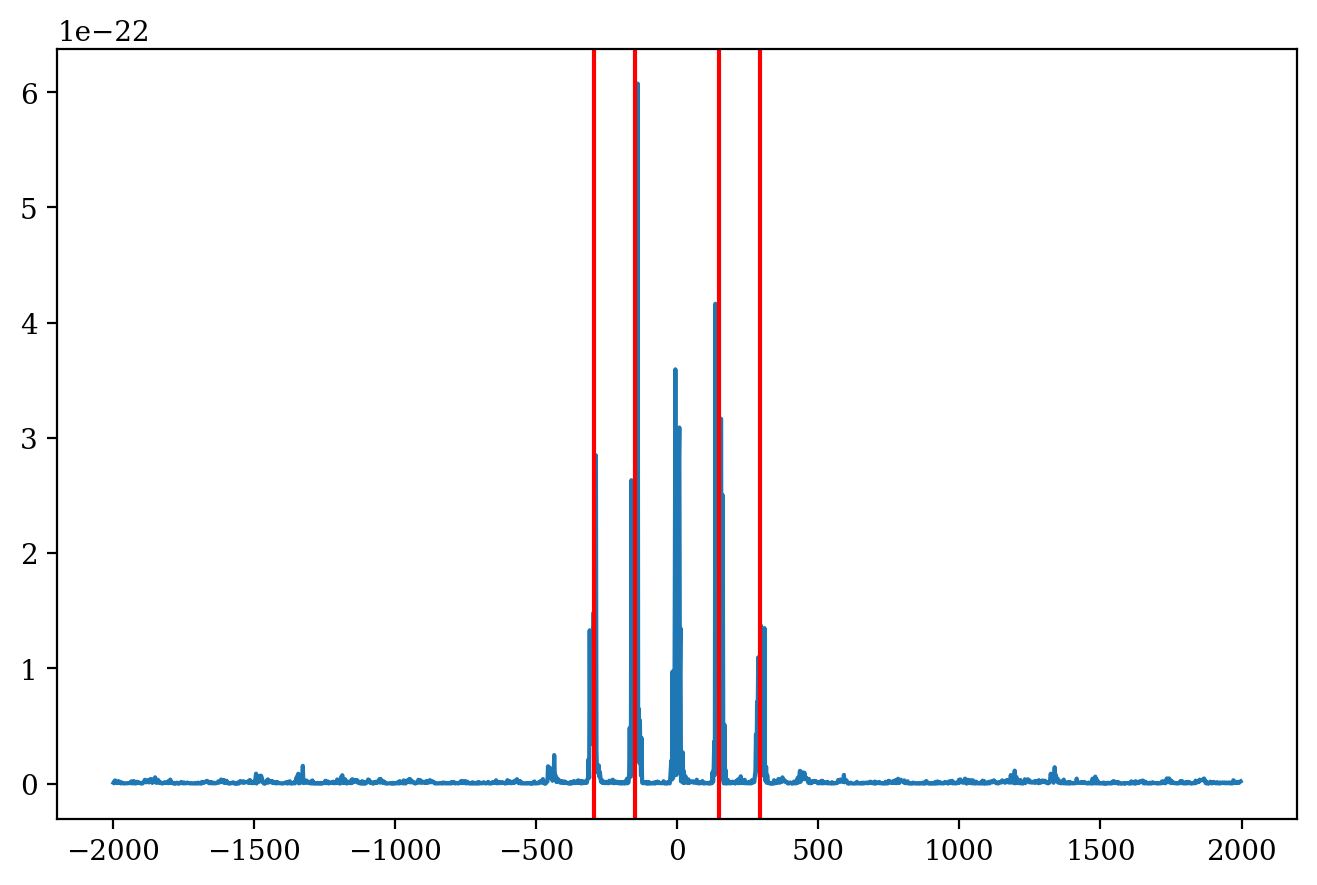

In [106]:
plt.plot(pxlin, np.abs(np.trapz(phi,axis=1))**2)
plt.axvline(x=+2*k*hb,color='r')
plt.axvline(x=-2*k*hb,color='r')
plt.axvline(x=+4*k*hb,color='r')
plt.axvline(x=-4*k*hb,color='r')
plt.show()

147.37997261359178

In [71]:
def testAngle(ang=pi/2):
    steps = int(15*0.001/dt)
    print("duration tau =",15*0.001, ", steps =", steps, ", dt =",dt)
    print("angle =", ang)
    psi = psi0np(5,5,p*cos(ang),p*sin(p))
    t = 0    
    for i in tqdm(range(steps)):
        psi *= VxExpGrid
        phi = np.fliplr(np.fft.fftshift(pyfftw.interfaces.numpy_fft.fft2(psi,threads=nthreads)))
        phi *= expPGrid
        psi = pyfftw.interfaces.numpy_fft.ifft2(np.fft.ifftshift(np.fliplr(phi)),threads=nthreads)
        psi *= VxExpGrid
        t += dt
    plot_psi(psi)
    plot_mom(psi)

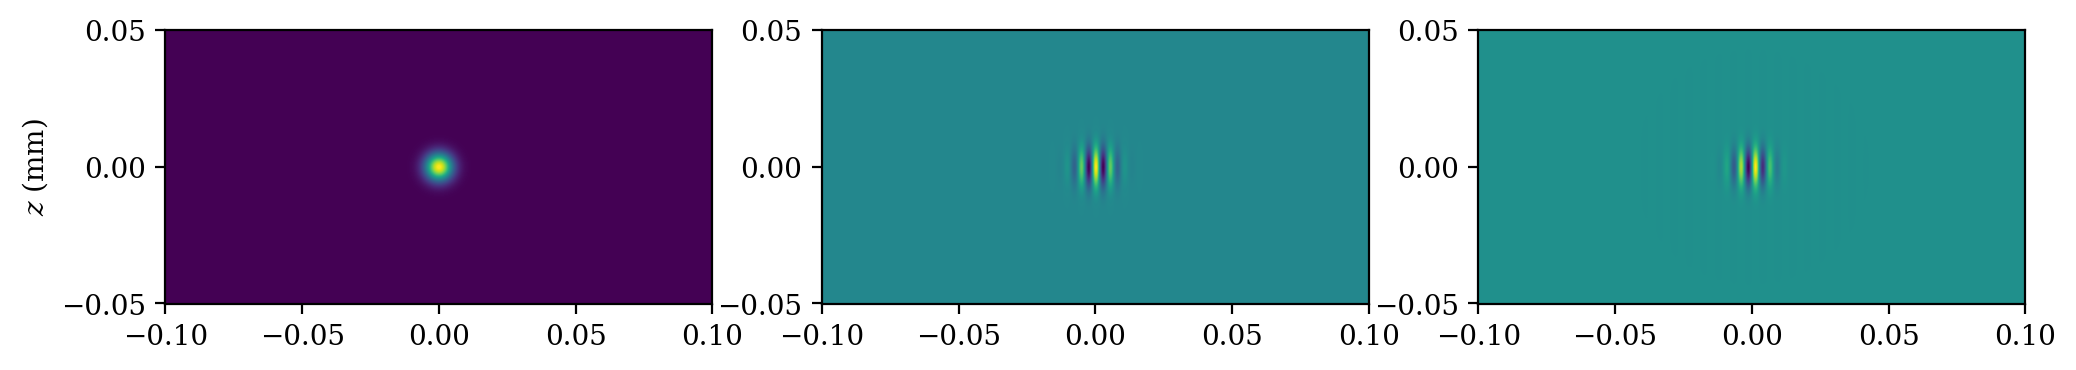

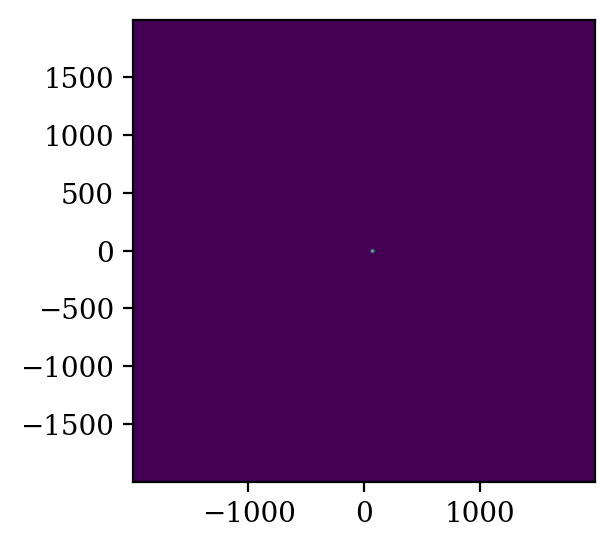

In [76]:
psi = psi0np(5,5,p)
plot_psi(psi)
plot_mom(psi)

duration tau = 0.015 , steps = 150 , dt = 0.0001
angle = 0.0


  0%|          | 0/150 [00:00<?, ?it/s]

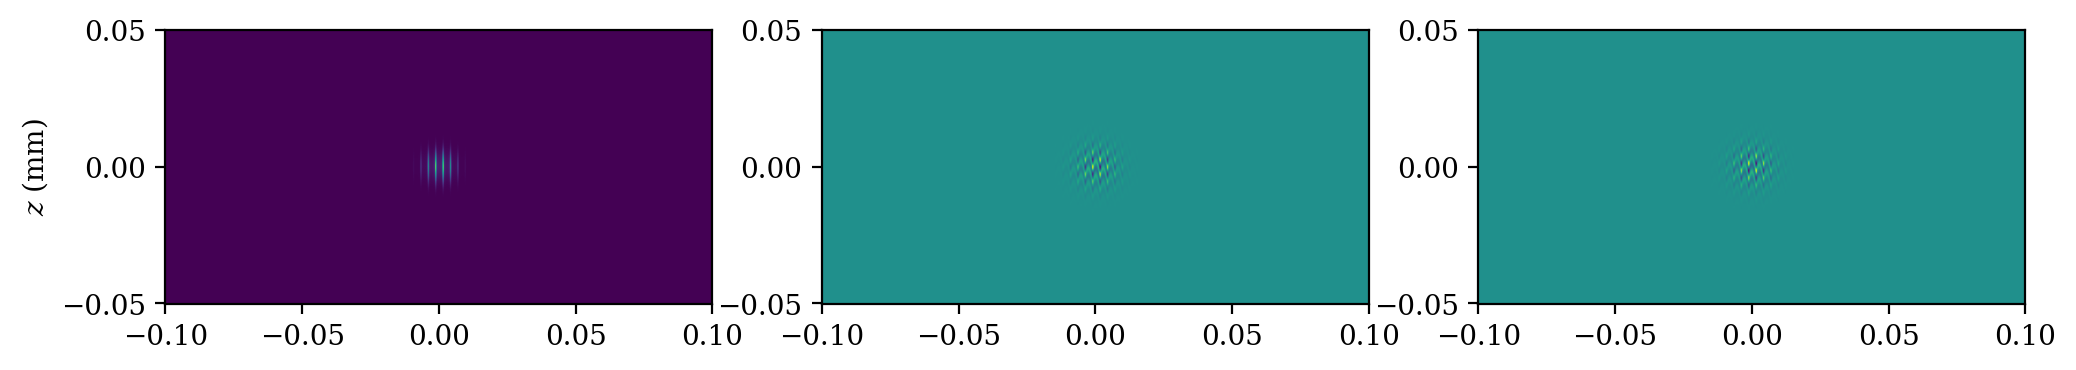

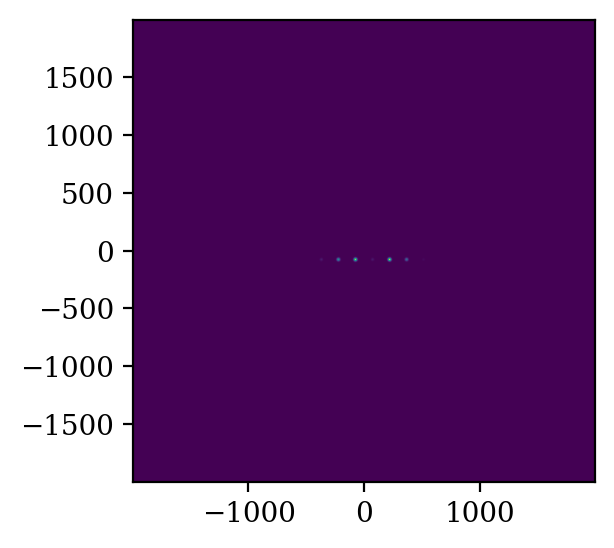

duration tau = 0.015 , steps = 150 , dt = 0.0001
angle = 0.7853981633974483


  0%|          | 0/150 [00:00<?, ?it/s]

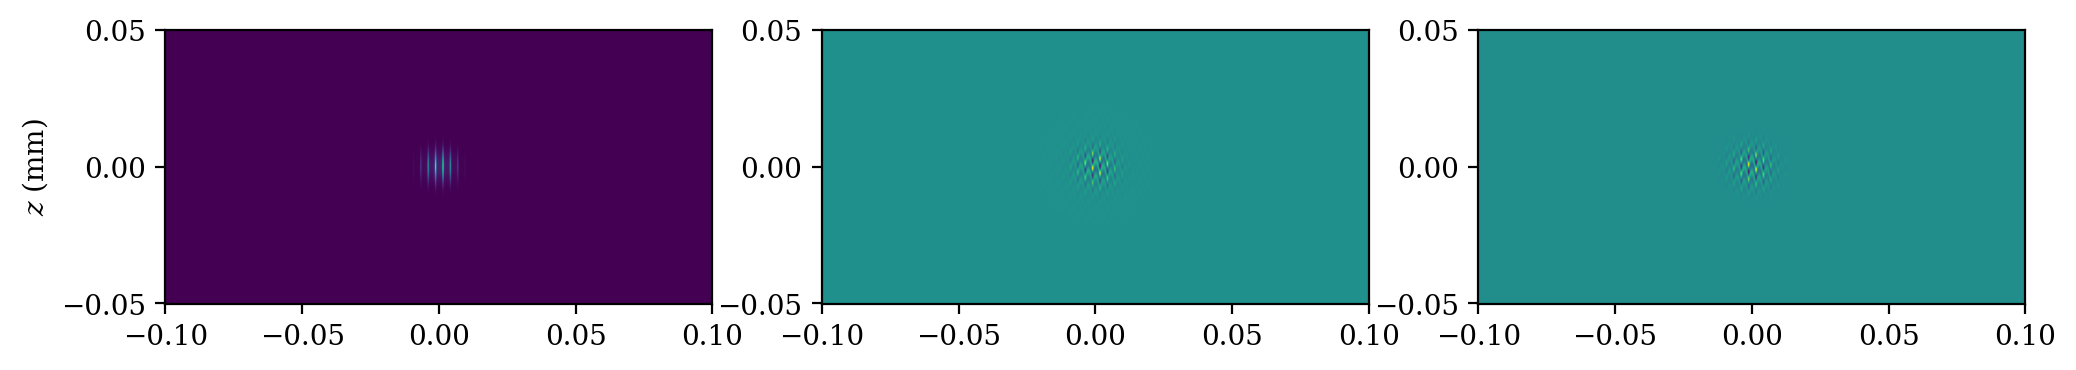

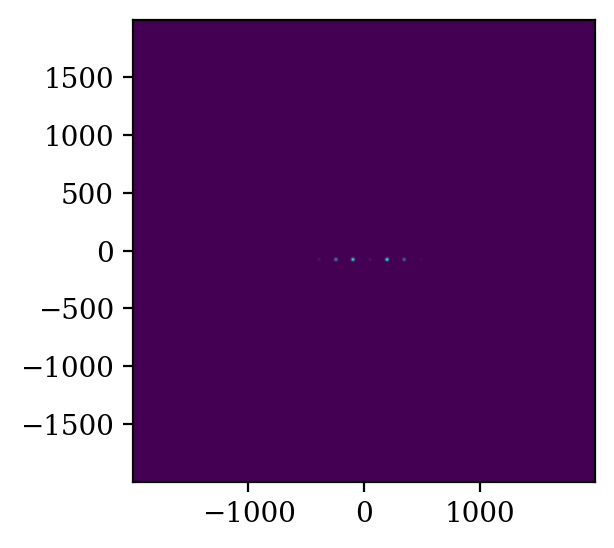

duration tau = 0.015 , steps = 150 , dt = 0.0001
angle = 1.5707963267948966


  0%|          | 0/150 [00:00<?, ?it/s]

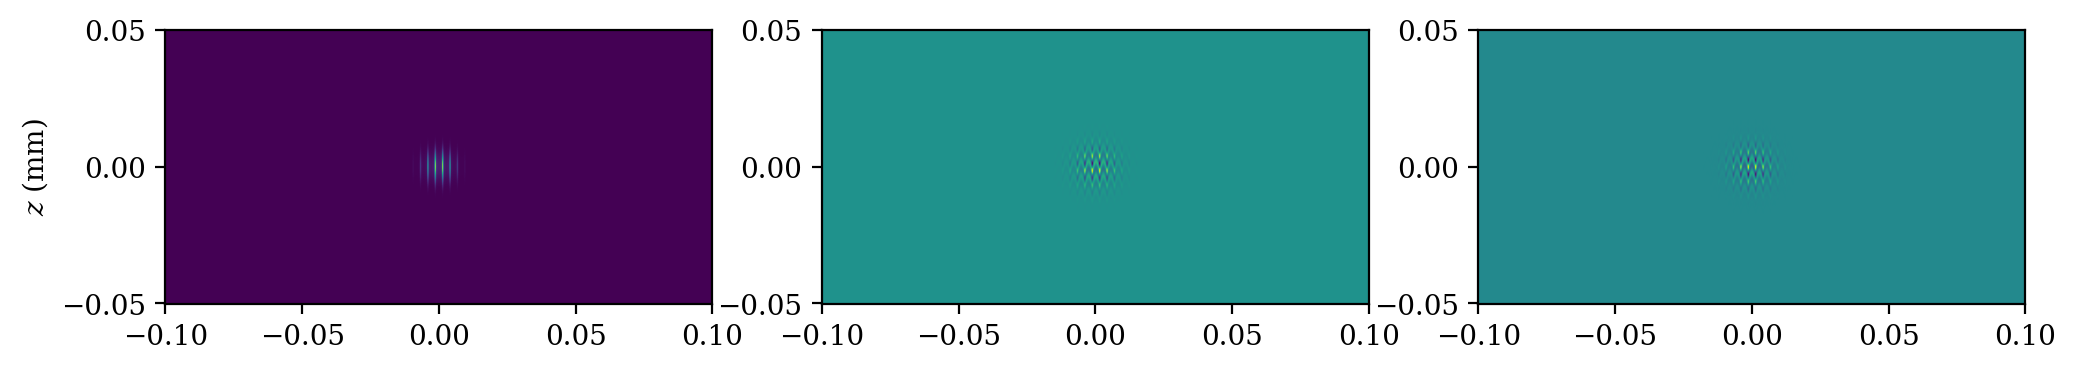

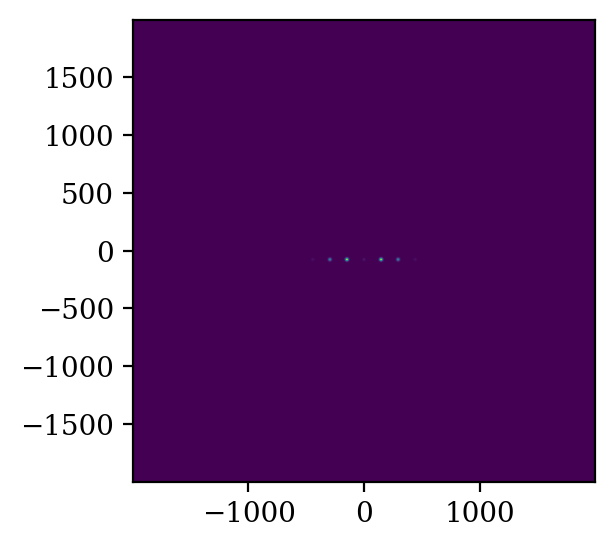

duration tau = 0.015 , steps = 150 , dt = 0.0001
angle = 3.141592653589793


  0%|          | 0/150 [00:00<?, ?it/s]

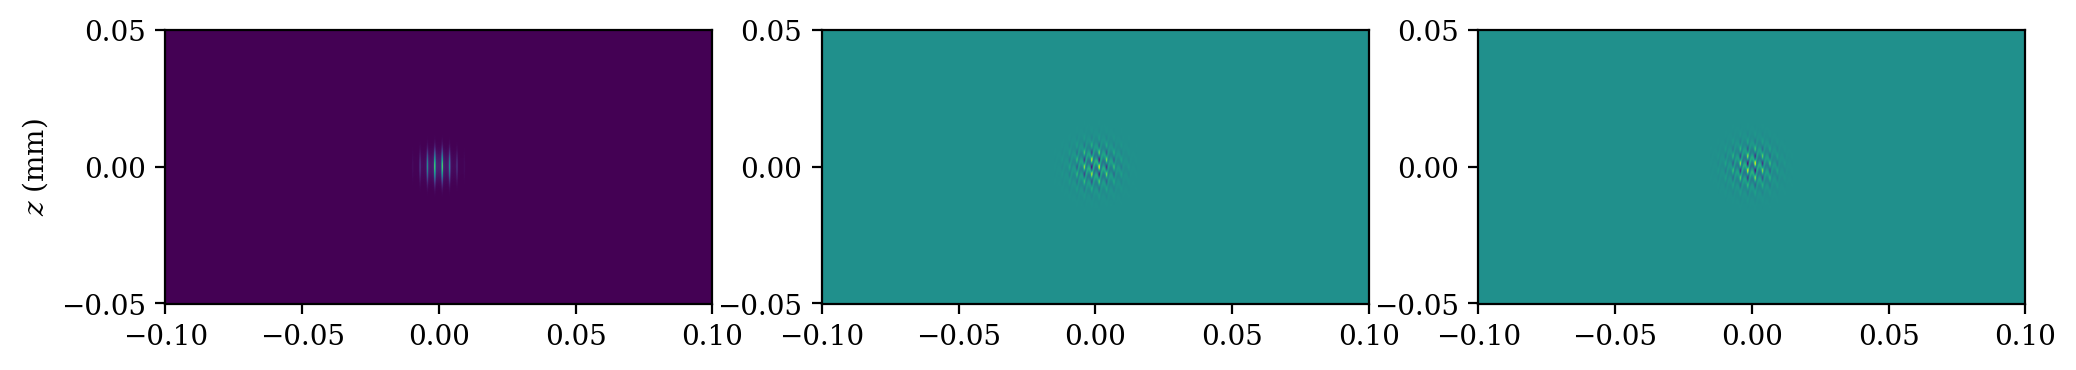

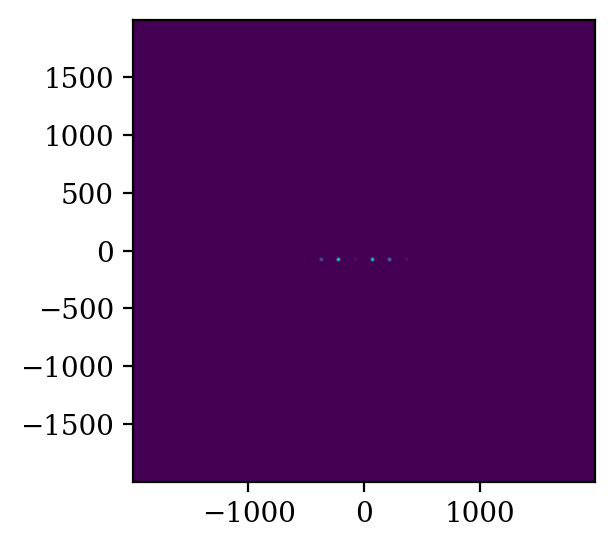

In [73]:
testAngle(0*pi)
testAngle(pi/4)
testAngle(pi/2)
testAngle(pi)

In [ ]:
print(dt)
print(dt*100)
print(dt*1000)
print(dt*1000*10)
print(dt*1000*100)